# Analysis Notebook – Analisys of CV3-Fv simulation with metad and all-atom MD data

**Author:** Matteo Cagiada  

**Date:** November, 2025 

**Version:** v1.0

**Contact email:** matteo.cagiada@bio.ku.dk / matteo.cagiada@stats.ku.dk

---

## Overview

This Jupyter notebook accompanies the paper:

> **Uncovering the flexibility of CDR loops in antibodies and TCRs through large-scale molecular dynamics**  
> Matteo Cagiada, Fabian C. Spoendlin, King Ifashe, Charlotte M. Deane
> biorxiv - 2025

---

## How to Run

To run this notebook, clone the GitHub repository and run it. Then download the all-atom trajectories from the Zenodo repository (https://doi.org/10.5281/zenodo.17525665) and copy them into the '/CDR_MD_simulations/src/aa_md' folder. The trajectories need to be merged. We used MDanalysis for this, discarding the first 150 ns of the simulation for each replica and obtaining a merged trajectory of 350 ns.

The remaining CG simulations are already in the correct folders.

### Requirements
- **Python version:** 3.9+  
- **Environment:** Conda
- **Dependencies:** numpy, MDanalysis, mdtraj, pandas, matplotlib, Biopython

## functions

In [394]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import json
import random
import re

from MDAnalysis.coordinates.memory import MemoryReader

import mdtraj as md
import MDAnalysis as mda
from MDAnalysis.analysis import align, rms
from MDAnalysis import Merge
import MDAnalysis.analysis.diffusionmap as diffusionmap
from MDAnalysis.analysis.distances import distance_array

from Bio.PDB import PDBParser, PPBuilder

In [6]:
def calc_rmsd(u,uref,select='all',f_out=None,step=1):
    # print('First alignment')
    aligner = align.AlignTraj(u, uref, select=select, in_memory=True).run(step=step) # align to crystal structure
    Rref = rms.RMSD(u,uref,select=select) # get RMSD to reference
    Rref.run(step=step)
    coords = u.trajectory.timeseries(u.atoms,step=step) 
    coords_mean = coords.mean(axis=1) # get mean structure
    u_mean = Merge(u.atoms) # new universe from mean structure
    u_mean.load_new(coords_mean[:, None, :], order="afc")

    # print('Second alignment')
    aligner = align.AlignTraj(u, u_mean, select=select, in_memory=True).run(step=step) # align to mean structure
    coords = u.trajectory.timeseries(u.atoms,step=step) # get coords
    coords_mean = coords.mean(axis=1) # get new mean
    u_mean2 = Merge(u.atoms)
    u_mean2.load_new(coords_mean[:, None, :], order="afc")
    
    Rmean = rms.RMSD(u,u_mean2,select=select) # get RMSD to new mean structure
    Rmean.run(step=step)
    print('done')
    return Rref.results.rmsd.T,Rmean.results.rmsd.T

In [14]:
def extract_cdr_coord(dict_loc,chain,cdr_boundaries):
    with open(dict_loc,'r') as f:
        img_cv3_map=json.load(f)
    return [img_cv3_map[chain][str(elem)+'.0'] for elem in cdr_boundaries]

In [18]:
# Function to extract sequences by chain
def extract_sequences_by_chain(pdb_file):
    parser = PDBParser(QUIET=True)  # Create a parser
    structure = parser.get_structure('structure', pdb_file)  # Parse the PDB file

    sequences = {}
    ppb = PPBuilder()  # Peptide bond builder

    # Iterate through each chain in the structure
    for model in structure:
        for chain in model:
            # Build the sequence for the chain
            seq = ''
            for pp in ppb.build_peptides(chain):
                seq += pp.get_sequence()
            # Add to the dictionary, key is the chain ID
            sequences[chain.id] = seq

    return sequences

In [19]:
def calc_rmsd_pdb(u_pdb,u_md,select_md,select_pdb,chain_id):
    # print('First alignment')
    # Select specific atoms (e.g., chain L, resid 24–42, CA)
    chain2 = u_pdb.select_atoms(f'segid {chain_id}')
    sel2=chain2.select_atoms(select_pdb)
    sel1 = u_md.select_atoms(select_md)

    # Extract Cα coordinates for all frames
    coords1 = np.array([sel1.positions.copy() for ts in u_md.trajectory])
    mean_coords = coords1.mean(axis=0)[None, ...]  # shape (1, n_atoms, 3)

    coords2 = np.array([sel2.positions.copy() for ts in u_pdb.trajectory])
    
    # Concatenate the coordinates along time
    combined_coords = np.concatenate([mean_coords, coords2], axis=0)
    
    # Build a new Universe with only CA atoms
    merged_top = mda.Merge(sel1)  # use sel1's topology
    merged_traj = MemoryReader(combined_coords, dt=u_md.trajectory.dt)
    merged_top.trajectory = merged_traj
    # Save trajectory (e.g., to XTC)
    
    aligner = align.AlignTraj(merged_top, merged_top, select="name CA", reference_frame=0, in_memory=True)
    aligner.run()
    
    with mda.Writer("../../mean_plus_u2.xtc", merged_top.atoms.n_atoms) as W:
        for ts in merged_top.trajectory:
            W.write(merged_top.atoms)
    
    # Save PDB (topology)
    merged_top.atoms.write("../../mean_plus_u2_top.pdb")

    
    rmsd= rms.RMSD(merged_top, merged_top, select="name CA", ref_frame=0)
    rmsd.run()

    return rmsd.results.rmsd[1:, 2].T

In [20]:
def extract_number(filename):
    match = re.search(r'(\d+)(?=\.pdb$)', filename)
    return int(match.group(1)) if match else -1  # fallback in case no match


In [22]:
def dist_trajs(u_merged,select="name CA",start_frame=0):
    
    aligner = align.AlignTraj(u_merged, u_merged, select=select, reference_frame=start_frame, in_memory=True)
    aligner.run(start=start_frame)

    dist_matrix = diffusionmap.DistanceMatrix(u_merged, select=select).run(start=start_frame)
    dmatrix=dist_matrix.results.dist_matrix
    
    return np.array(dmatrix[np.triu_indices_from(dmatrix, k=1)])


In [23]:
def calc_rmsd_from_pdb(u_pdb,u_md,select_md,select_pdb,chain_id):
    
    out_rmsd=[]
    
    chain2 = u_pdb.select_atoms(f'segid {chain_id}')
    sel2=chain2.select_atoms(select_pdb)
    sel1 = u_md.select_atoms(select_md)

    # Extract Cα coordinates for all frames
    coords1 = np.array([sel1.positions.copy() for ts in u_md.trajectory])
    mean_coords = coords1.mean(axis=0)[None, ...]  # shape (1, n_atoms, 3)

    coords2 = np.array([sel2.positions.copy() for ts in u_pdb.trajectory])
    number_pdbs=len(coords2)
    total_len=len(coords1)+len(coords2)
    print(total_len)
    # Concatenate the coordinates along time
    combined_coords = np.concatenate([coords1, coords2], axis=0)
    
    # Build a new Universe with only CA atoms
    merged_top = mda.Merge(sel1)  # use sel1's topology
    merged_traj = MemoryReader(combined_coords, dt=u_md.trajectory.dt)
    merged_top.trajectory = merged_traj
    # Save trajectory (e.g., to XTC)
    
    aligner = align.AlignTraj(merged_top, merged_top, select="name CA", reference_frame=0, in_memory=True)
    aligner.run()
    for ref in range(number_pdbs):
        rmsd= rms.RMSD(merged_top, merged_top, select="name CA", ref_frame=(total_len-number_pdbs+ref-1))
        rmsd.run()
        out_rmsd.append(rmsd.results.rmsd[:-(number_pdbs), 2].T)
    return np.array(out_rmsd)

In [24]:
def com_distance_array(traj: md.Trajectory, res1_range: tuple, res2_range: tuple) -> np.ndarray:
    """
    Calculate the distance between the center of mass of two residue groups 
    over all frames of a trajectory.

    Parameters:
    - traj: mdtraj.Trajectory object
    - res1_range: tuple (start, end) for first residue group (inclusive)
    - res2_range: tuple (start, end) for second residue group (inclusive)

    Returns:
    - distances: np.ndarray of shape (n_frames,), distance in nm
    """
    # Select atoms in the specified residue ranges
    group1_atoms = traj.topology.select(f"name CA and resid {res1_range[0]} to {res1_range[1]}")
    group2_atoms = traj.topology.select(f"name CA and resid {res2_range[0]} to {res2_range[1]}")
    
    # Get masses (if available, otherwise assume equal mass)
    try:
        masses = np.array([atom.element.mass for atom in traj.topology.atoms])
    except:
        masses = np.ones(traj.n_atoms)

    # Compute center of mass for each group across all frames
    def compute_com(atom_indices):
        m = masses[atom_indices]
        coords = traj.xyz[:, atom_indices, :]  # shape (n_frames, n_atoms, 3)
        weighted = coords * m[None, :, None]
        return weighted.sum(axis=1) / m.sum()

    com1 = compute_com(group1_atoms)
    com2 = compute_com(group2_atoms)

    # Compute distance between COMs per frame
    distances = np.linalg.norm(com1 - com2, axis=1)  # shape (n_frames,)

    return distances  # in nm (MDTraj units)

In [26]:
cdrs_list=[[27,38],[56,65],[105,117]]

In [27]:
dict_charged_amino_3to1={'Cyx':'C','Hip':'H','Hie':'H','Hid':'H','Glh':'E'}

## 2Y07 - bound pept

#### load starting pdb

In [28]:
dict_cv2imgt='../src/sims_cv3fv/2y07_HL/2y07_dict_Fv_HL.txt'

pdb_start=os.path.abspath('../src/sims_cv3fv/2y07_HL/2y07_Fv_HL.pdb')

chain_list='HL'

In [29]:
chain_list

'HL'

In [31]:
os.listdir('../src/metaD_clusters/2Y07_clusters/')

['cluster_4.pdb',
 'cluster_5.pdb',
 'cluster_2.pdb',
 'cluster_3.pdb',
 'cluster_1.pdb',
 'cluster_0.pdb']

In [32]:
n_cluster=len(os.listdir('../src/metaD_clusters/2Y07_clusters/'))

In [33]:
dict_prob_cluster={'cluster_0.pdb':0.52,'cluster_1.pdb':0.34,'cluster_2.pdb':0.07,'cluster_3.pdb':0.04,'cluster_4.pdb':0.02,'cluster_5.pdb':0.01}

In [34]:
cluster_pdb_list=os.listdir('../src/metaD_clusters/2Y07_clusters/')
cluster_chain_list=['HL','HL','HL','HL','HL']
cluster_folder_pdbs='../src/metaD_clusters/2Y07_clusters/'
cluster_pdb_prob=np.array([dict_prob_cluster[cluster] for cluster in cluster_pdb_list])

In [37]:
sys_name='2y07'
pdb_trajectories = [md.load(os.path.join('../src/metaD_clusters/2Y07_clusters/',pdb_name)) for pdb_name in os.listdir('../src/metaD_clusters/2Y07_clusters/')]

# Step 2: Concatenate all into a single trajectory
pdb_traj = md.join(pdb_trajectories)
pdb_traj.save_xtc(f"../src/metaD_clusters/imgt_traj_clusters/{sys_name}_joined_pdbs.xtc")

pdb_traj = mda.Universe('../src/metaD_clusters/2Y07_clusters/cluster_0.pdb',f"../src/metaD_clusters/imgt_traj_clusters/{sys_name}_joined_pdbs.xtc")


/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/XDR.py:240: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


In [38]:
pdb_traj

<Universe with 6348 atoms>

In [39]:
rmsd_all_dist={}
rmsd_all_dist['sim']={'heavy':{},'light':{}}
rmsd_all_dist['metad']={'heavy':{},'light':{}}

In [40]:
chain_cluster=['H','L']
for chain_idx,chain_type in enumerate(['heavy','light']):
    for idx_cdr, cdr in enumerate(cdrs_list):
        rmsd_all_dist['metad'][chain_type][idx_cdr]=dist_trajs(pdb_traj,select=f'segid {chain_cluster[chain_idx]} and name CA and resid {cdr[0]-1}:{cdr[1]+1}')
        if len(rmsd_all_dist['metad'][chain_type][idx_cdr]) ==0:
            rmsd_all_dist['metad'][chain_type][idx_cdr]=np.array([0])

### load simulations

In [41]:
top_file = '../src/sims_cv3fv/2y07_HL/2y07_Fv_HL.pdb'  # Path to your PDB file
chain_sequences = extract_sequences_by_chain(top_file)

# Print sequences for each chain
for chain_id, sequence in chain_sequences.items():
    print(f"Chain {chain_id} {len(sequence)}: {sequence}")
    if chain_id == 'H':
        res_heavy=sequence
    if chain_id == 'L':
        res_light=sequence

Chain H 122: QVQLQQPGAELVKPGASVKLSCKASGYTFTSYWMHWVKQRPGRGLEWIGRIDPNSGGTAYNEKFKSKATLTVDKPSSTAYMALSSLTSADSAVYYCARYDYYGGSYFDYWGQGTTLTVSSGG
Chain L 112: QAVVTQESALTTSPGETVTLTCRSSTGAVTTSNYANWVQEKPDHLFTGLIGGTNNRAPGVPARFSGSLIGDKAALTITGGQTEDEAIYFCALWYSNHWVFGGGTALTVLGQP


In [42]:
sel_pdb='2y07_Fv_HL.pdb'
sel_chain='HL'
topology_fa = "../src/sims_cv3fv/2y07_HL/2y07_Fv_HL_top.pdb"

top_pdb=mda.Universe(topology_fa,topology_fa)

dict_imgt2cv='../src/sims_cv3fv/2y07_HL/2y07_dict_Fv_HL.txt'

In [44]:
prefix_sim=os.path.abspath('../src/sims_cv3fv/2y07_HL/2y07_Fv_HL')
topology_fa= os.path.join(prefix_sim+"_top.pdb")
xtc_file = os.path.join(prefix_sim+"_aligned.xtc")

mobile = mda.Universe(topology_fa,xtc_file)
ref = mda.Universe(topology_fa,xtc_file)

mobile.trajectory  # set mobile trajectory to last frame
ref.trajectory[0]  # set reference trajectory to first frame

##dict_loc,chain,cdr_boundaries

cv3_cdrs_light_sim=[extract_cdr_coord(dict_imgt2cv,sel_chain[1],cdrs_list[0]),extract_cdr_coord(dict_imgt2cv,sel_chain[1],cdrs_list[1]),extract_cdr_coord(dict_imgt2cv,sel_chain[1],cdrs_list[2])]
cv3_cdrs_heavy_sim=[extract_cdr_coord(dict_imgt2cv,sel_chain[0],cdrs_list[0]),extract_cdr_coord(dict_imgt2cv,sel_chain[0],cdrs_list[1]),extract_cdr_coord(dict_imgt2cv,sel_chain[0],cdrs_list[2])]

<ResidueGroup [<Residue THR, 148>, <Residue GLY, 149>, <Residue ALA, 150>, <Residue VAL, 151>, <Residue THR, 152>, <Residue THR, 153>, <Residue SER, 154>, <Residue ASN, 155>, <Residue TYR, 156>]>
(1010, 9)
insi v2 (1010, 18)
<ResidueGroup [<Residue GLY, 174>, <Residue THR, 175>, <Residue ASN, 176>]>


/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/analysis/dihedrals.py:315: DeprecationWarning: The `angle` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.angles` instead
  warnings.warn(wmsg, DeprecationWarning)


(1010, 3)
insi v2 (1010, 6)
<ResidueGroup [<Residue ALA, 213>, <Residue LEU, 214>, <Residue TRP, 215>, <Residue TYR, 216>, <Residue SER, 217>, <Residue ASN, 218>, <Residue HIS, 219>, <Residue TRP, 220>, <Residue VAL, 221>]>
(1010, 9)
insi v2 (1010, 18)
<ResidueGroup [<Residue GLY, 26>, <Residue TYR, 27>, <Residue THR, 28>, <Residue PHE, 29>, <Residue THR, 30>, <Residue SER, 31>, <Residue TYR, 32>, <Residue TRP, 33>]>
(1010, 8)
insi v2 (1010, 16)
<ResidueGroup [<Residue ILE, 51>, <Residue ASP, 52>, <Residue PRO, 53>, <Residue ASN, 54>, <Residue SER, 55>, <Residue GLY, 56>, <Residue GLY, 57>, <Residue THR, 58>]>
(1010, 8)
insi v2 (1010, 16)
<ResidueGroup [<Residue ALA, 97>, <Residue ARG, 98>, <Residue TYR, 99>, ..., <Residue PHE, 107>, <Residue ASP, 108>, <Residue TYR, 109>]>
(1010, 13)
insi v2 (1010, 26)


In [45]:
Rref_cdr1_light,Rmean_cdr1_light=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_light_sim[0][0]}:{cv3_cdrs_light_sim[0][1]}')
Rref_cdr2_light,Rmean_cdr2_light=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_light_sim[1][0]}:{cv3_cdrs_light_sim[1][1]}')
Rref_cdr3_light,Rmean_cdr3_light=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_light_sim[2][0]}:{cv3_cdrs_light_sim[2][1]}')

Rref_cdr1_heavy,Rmean_cdr1_heavy=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_heavy_sim[0][0]}:{cv3_cdrs_heavy_sim[0][1]}')
Rref_cdr2_heavy,Rmean_cdr2_heavy=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_heavy_sim[1][0]}:{cv3_cdrs_heavy_sim[1][1]}')
Rref_cdr3_heavy,Rmean_cdr3_heavy=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_heavy_sim[2][0]}:{cv3_cdrs_heavy_sim[2][1]}')


/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/memory.py:535: DeprecationWarning: asel argument to timeseries will be renamed to'atomgroup' in 3.0, see #3911
  warnings.warn(


done
done
done
done
done
done


In [46]:
trajectory = md.load(xtc_file
, top=topology_fa)  # Adjust file names/paths as needed

# Light chain
atom_indices = trajectory.topology.select('name CA and chainid 0')
# Restrict the trajectory to the selected atoms
sub_traj = trajectory.atom_slice(atom_indices)
sub_traj.center_coordinates()
rmsf_sim = md.rmsf(sub_traj, sub_traj, 0, precentered=True) *10
rmsd_sim = md.rmsd(sub_traj, sub_traj, 0, precentered=True) *10

rmsf_sim_heavy=rmsf_sim[:len(res_heavy)]
rmsf_sim_light=rmsf_sim[-(len(res_light)):]



In [47]:
# Light chain
atom_indices = trajectory.topology.select(f'name CA and resid >= {cv3_cdrs_light_sim[2][0]} and resid <= {cv3_cdrs_light_sim[2][1]}')
# Restrict the trajectory to the selected atoms
sub_traj_CDRL3_sim = trajectory.atom_slice(atom_indices)
sub_traj_CDRL3_sim.center_coordinates()

# Light chain
atom_indices = trajectory.topology.select(f'name CA and resid >= {cv3_cdrs_heavy_sim[2][0]} and resid <= {cv3_cdrs_heavy_sim[2][1]}')
# Restrict the trajectory to the selected atoms
sub_traj_CDRH3_sim = trajectory.atom_slice(atom_indices)
sub_traj_CDRH3_sim.center_coordinates()

<mdtraj.Trajectory with 1010 frames, 13 atoms, 13 residues, and unitcells at 0x31522c8e0>

In [48]:
rmsf_cdr1_light_sim=rmsf_sim[(cv3_cdrs_light_sim[0][0]-1):(cv3_cdrs_light_sim[0][1])]
rmsf_cdr2_light_sim=rmsf_sim[(cv3_cdrs_light_sim[1][0]-1):(cv3_cdrs_light_sim[1][1])]
rmsf_cdr3_light_sim=rmsf_sim[(cv3_cdrs_light_sim[2][0]-1):(cv3_cdrs_light_sim[2][1])]

rmsf_cdr1_heavy_sim=rmsf_sim[(cv3_cdrs_heavy_sim[0][0]-1):(cv3_cdrs_heavy_sim[0][1])]
rmsf_cdr2_heavy_sim=rmsf_sim[(cv3_cdrs_heavy_sim[1][0]-1):(cv3_cdrs_heavy_sim[1][1])]
rmsf_cdr3_heavy_sim=rmsf_sim[(cv3_cdrs_heavy_sim[2][0]-1):(cv3_cdrs_heavy_sim[2][1])]

#### rmsd pdbs

In [49]:
Rmean_cdr1_light_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[0][0]-1}:{cv3_cdrs_light_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', chain_list[1])
Rmean_cdr2_light_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[1][0]-1}:{cv3_cdrs_light_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', chain_list[1])
Rmean_cdr3_light_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[2][0]-1}:{cv3_cdrs_light_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', chain_list[1])

Rmean_cdr1_heavy_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[0][0]-1}:{cv3_cdrs_heavy_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', chain_list[0])
Rmean_cdr2_heavy_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[1][0]-1}:{cv3_cdrs_heavy_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', chain_list[0])
Rmean_cdr3_heavy_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[2][0]-1}:{cv3_cdrs_heavy_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', chain_list[0])

/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:777: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


In [50]:
Rref_cdr1_light_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_light_sim[0][0]-1}:{cv3_cdrs_light_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', chain_list[1])
Rref_cdr2_light_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_light_sim[1][0]-1}:{cv3_cdrs_light_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', chain_list[1])
Rref_cdr3_light_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_light_sim[2][0]-1}:{cv3_cdrs_light_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', chain_list[1])

Rref_cdr1_heavy_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_heavy_sim[0][0]-1}:{cv3_cdrs_heavy_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', chain_list[0])
Rref_cdr2_heavy_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_heavy_sim[1][0]-1}:{cv3_cdrs_heavy_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', chain_list[0])
Rref_cdr3_heavy_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_heavy_sim[2][0]-1}:{cv3_cdrs_heavy_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', chain_list[0])

/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/base.py:725: UserWarning: Reader has no dt information, set to 1.0 ps
  return self.ts.dt


In [51]:
Rmetad_cdr1_light_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[0][0]-1}:{cv3_cdrs_light_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', 'L')
Rmetad_cdr2_light_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[1][0]-1}:{cv3_cdrs_light_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', 'L')
Rmetad_cdr3_light_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[2][0]-1}:{cv3_cdrs_light_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', 'L')

Rmetad_cdr1_heavy_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[0][0]-1}:{cv3_cdrs_heavy_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', 'H')
Rmetad_cdr2_heavy_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[1][0]-1}:{cv3_cdrs_heavy_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', 'H')
Rmetad_cdr3_heavy_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[2][0]-1}:{cv3_cdrs_heavy_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', 'H')

1016
1016
1016
1016
1016
1016


In [52]:
chain_sim=['P000','P001']
cdr_sim=[cv3_cdrs_heavy_sim,cv3_cdrs_light_sim]
for chain_idx,chain_type in enumerate(['heavy','light']):
    for idx_cdr, cdr in enumerate(cdrs_list):
        rmsd_all_dist['sim'][chain_type][idx_cdr]=dist_trajs(mobile,select=f'segid {chain_sim[chain_idx]} and name CA and resid {cdr_sim[chain_idx][chain_idx][0]-1}:{cdr_sim[chain_idx][idx_cdr][1]+1}').flatten()

### plots

In [55]:
size_clusters=np.array([250*np.sqrt(dict_prob_cluster[cluster_file]) for cluster_file in reversed(os.listdir('../src/metaD_clusters/2Y07_clusters/'))])

In [60]:
cluster_dot_size=[]
for cluster in os.listdir('../src/metaD_clusters/2Y07_clusters/'):
    cluster_dot_size.append(dict_prob_cluster[cluster])
cluster_dot_size=np.array(cluster_dot_size)

In [61]:
np.array(list(dict_prob_cluster.values()))*20

array([10.4,  6.8,  1.4,  0.8,  0.4,  0.2])

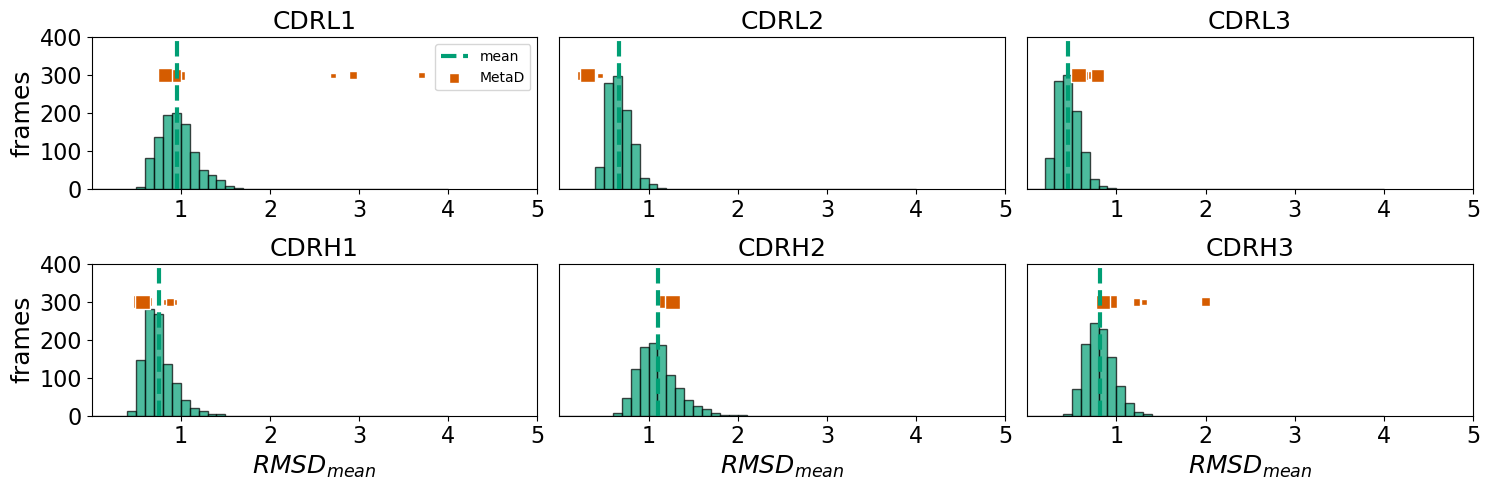

In [63]:
system_name='2Y07'

fig,(axs)=plt.subplots(2,3,figsize=(15,5))

axs=axs.flatten()

counts=axs[0].hist(Rmean_cdr1_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[0].plot([np.mean(Rmean_cdr1_light[2,:]),np.mean(Rmean_cdr1_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='mean')
axs[0].scatter([Rmean_cdr1_light_pdb],[[300 for i in Rmean_cdr1_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00',label='MetaD')
axs[0].legend()

axs[0].set_title('CDRL1',fontsize=18)

counts=axs[1].hist(Rmean_cdr2_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[1].plot([np.mean(Rmean_cdr2_light[2,:]),np.mean(Rmean_cdr2_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[1].scatter([Rmean_cdr2_light_pdb],[[300 for i in Rmean_cdr2_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[1].set_title('CDRL2',fontsize=18)


counts=axs[2].hist(Rmean_cdr3_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[2].plot([np.mean(Rmean_cdr3_light[2,:]),np.mean(Rmean_cdr3_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[2].scatter([Rmean_cdr3_light_pdb],[[300 for i in Rmean_cdr3_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[2].set_title('CDRL3',fontsize=18)


counts=axs[3].hist(Rmean_cdr1_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[3].plot([np.mean(Rmean_cdr1_heavy[2,:]),np.mean(Rmean_cdr1_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[3].scatter([Rmean_cdr1_heavy_pdb],[[300 for i in Rmean_cdr1_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[3].set_title('CDRH1',fontsize=18)


counts=axs[4].hist(Rmean_cdr2_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[4].plot([np.mean(Rmean_cdr2_heavy[2,:]),np.mean(Rmean_cdr2_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[4].scatter([Rmean_cdr2_heavy_pdb],[[300 for i in Rmean_cdr2_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[4].set_title('CDRH2',fontsize=18)


counts=axs[5].hist(Rmean_cdr3_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[5].plot([np.mean(Rmean_cdr3_heavy[2,:]),np.mean(Rmean_cdr3_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[5].scatter([Rmean_cdr3_heavy_pdb],[[300 for i in Rmean_cdr3_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[5].set_title('CDRH3',fontsize=18)

for ax in axs:

    ax.set_xlim(0,5)
    ax.set_ylim(0,400)
    ax.set_yticks([0,100,200,300,400])
    ax.set_yticklabels([0,100,200,300,400],fontsize=16)
    ax.set_yticks([0,100,200,300,400])
    ax.set_yticklabels([0,100,200,300,400],fontsize=16)
    ax.set_xticks([1,2,3,4,5])
    ax.set_xticklabels([1,2,3,4,5],fontsize=16)
    
axs[3].set_xlabel(r'$RMSD_{mean}$',fontsize=18)
axs[4].set_xlabel(r'$RMSD_{mean}$',fontsize=18)
axs[5].set_xlabel(r'$RMSD_{mean}$',fontsize=18)

axs[0].set_ylabel('frames',fontsize=18)
axs[3].set_ylabel('frames',fontsize=18)
axs[0].legend()

for ax in [axs[1],axs[2],axs[4],axs[5]]:
    ax.set_yticks([])


fig.tight_layout()
plt.savefig(f'../figures/{system_name}_restraints_rmsd_all_cdrs.pdf')

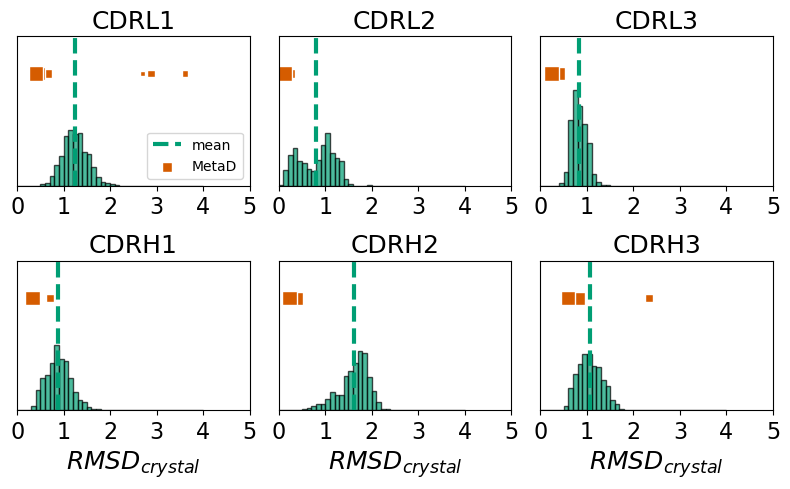

In [64]:
system_name='2Y07'

fig,(axs)=plt.subplots(2,3,figsize=(8,5))

axs=axs.flatten()

counts=axs[0].hist(Rref_cdr1_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[0].plot([np.mean(Rref_cdr1_light[2,:]),np.mean(Rref_cdr1_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='mean')
axs[0].scatter([Rref_cdr1_light_pdb],[[300 for i in Rref_cdr1_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00',label='MetaD')
axs[0].legend(fontsize=18)

axs[0].set_title('CDRL1',fontsize=18)

counts=axs[1].hist(Rref_cdr2_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[1].plot([np.mean(Rref_cdr2_light[2,:]),np.mean(Rref_cdr2_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[1].scatter([Rref_cdr2_light_pdb],[[300 for i in Rref_cdr2_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[1].set_title('CDRL2',fontsize=18)


counts=axs[2].hist(Rref_cdr3_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[2].plot([np.mean(Rref_cdr3_light[2,:]),np.mean(Rref_cdr3_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[2].scatter([Rref_cdr3_light_pdb],[[300 for i in Rref_cdr3_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[2].set_title('CDRL3',fontsize=18)


counts=axs[3].hist(Rref_cdr1_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[3].plot([np.mean(Rref_cdr1_heavy[2,:]),np.mean(Rref_cdr1_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[3].scatter([Rref_cdr1_heavy_pdb],[[300 for i in Rref_cdr1_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[3].set_title('CDRH1',fontsize=18)


counts=axs[4].hist(Rref_cdr2_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[4].plot([np.mean(Rref_cdr2_heavy[2,:]),np.mean(Rref_cdr2_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[4].scatter([Rref_cdr2_heavy_pdb],[[300 for i in Rref_cdr2_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[4].set_title('CDRH2',fontsize=18)


counts=axs[5].hist(Rref_cdr3_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[5].plot([np.mean(Rref_cdr3_heavy[2,:]),np.mean(Rref_cdr3_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[5].scatter([Rref_cdr3_heavy_pdb],[[300 for i in Rref_cdr3_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[5].set_title('CDRH3',fontsize=18)

for ax in axs:

    ax.set_xlim(0,5)
    ax.set_ylim(0,400)
    ax.set_xticks([0,1,2,3,4,5])
    ax.set_xticklabels([0,1,2,3,4,5],fontsize=16)
axs[3].set_xlabel(r'$RMSD_{crystal}$',fontsize=18)
axs[4].set_xlabel(r'$RMSD_{crystal}$',fontsize=18)
axs[5].set_xlabel(r'$RMSD_{crystal}$',fontsize=18)

axs[0].legend()

for ax in axs:
    ax.set_yticks([])
fig.tight_layout()
plt.savefig(f'../figures/{system_name}_restraints_rmsd_ref_cdrs.pdf')

In [66]:
order_cluster={}
for idx,cluster in enumerate(os.listdir('../src/metaD_clusters/2Y07_clusters/')):
    order_cluster[cluster]=idx
cluster_ordered=sorted(os.listdir('../src/metaD_clusters/2Y07_clusters/'), key=extract_number)

In [67]:
start_chain_light=len(res_heavy)

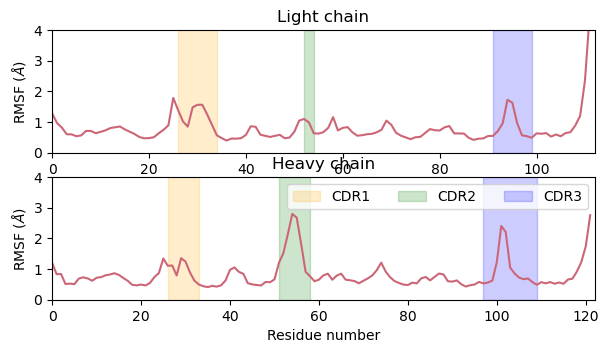

In [68]:
fig,(axs)=plt.subplots(2,1,figsize=(7,3.5))

axs[0].plot([i for i in range(len(res_light))],rmsf_sim_light,color='#CC6677')

axs[0].set_xlabel('Residue number')
axs[0].set_ylabel('RMSF ($\AA$)')
axs[0].axvspan(cv3_cdrs_light_sim[0][0]-start_chain_light,cv3_cdrs_light_sim[0][1]-start_chain_light, zorder=0, alpha=0.2, color='orange', label='CDR1')
axs[0].axvspan(cv3_cdrs_light_sim[1][0]-start_chain_light,cv3_cdrs_light_sim[1][1]-start_chain_light, zorder=0, alpha=0.2, color='green', label='CDR2')
axs[0].axvspan(cv3_cdrs_light_sim[2][0]-start_chain_light,cv3_cdrs_light_sim[2][1]-start_chain_light, zorder=0, alpha=0.2, color='blue', label='CDR3')
axs[0].set_ylim(0,4)
axs[0].set_xlim(0,len(res_light))


axs[1].plot([i for i in range(len(res_heavy))],rmsf_sim_heavy, color='#CC6677')

axs[1].set_xlabel('Residue number')
axs[1].set_ylabel('RMSF ($\AA$)')
axs[1].axvspan(cv3_cdrs_heavy_sim[0][0],cv3_cdrs_heavy_sim[0][1], zorder=0, alpha=0.2, color='orange', label='CDR1')
axs[1].axvspan(cv3_cdrs_heavy_sim[1][0],cv3_cdrs_heavy_sim[1][1], zorder=0, alpha=0.2, color='green', label='CDR2')
axs[1].axvspan(cv3_cdrs_heavy_sim[2][0],cv3_cdrs_heavy_sim[2][1], zorder=0, alpha=0.2, color='blue', label='CDR3')
axs[1].set_ylim(0,4)
axs[1].legend(ncol=3)
axs[1].set_xlim(0,len(res_heavy))

axs[1].set_title('Heavy chain')
axs[0].set_title('Light chain')

plt.savefig(f'../figures/{system_name}_restraints_rmsf_all.pdf')


/var/folders/8w/2dqxrgsd4vj00wv819dcz51w0000gn/T/ipykernel_44258/2441655020.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


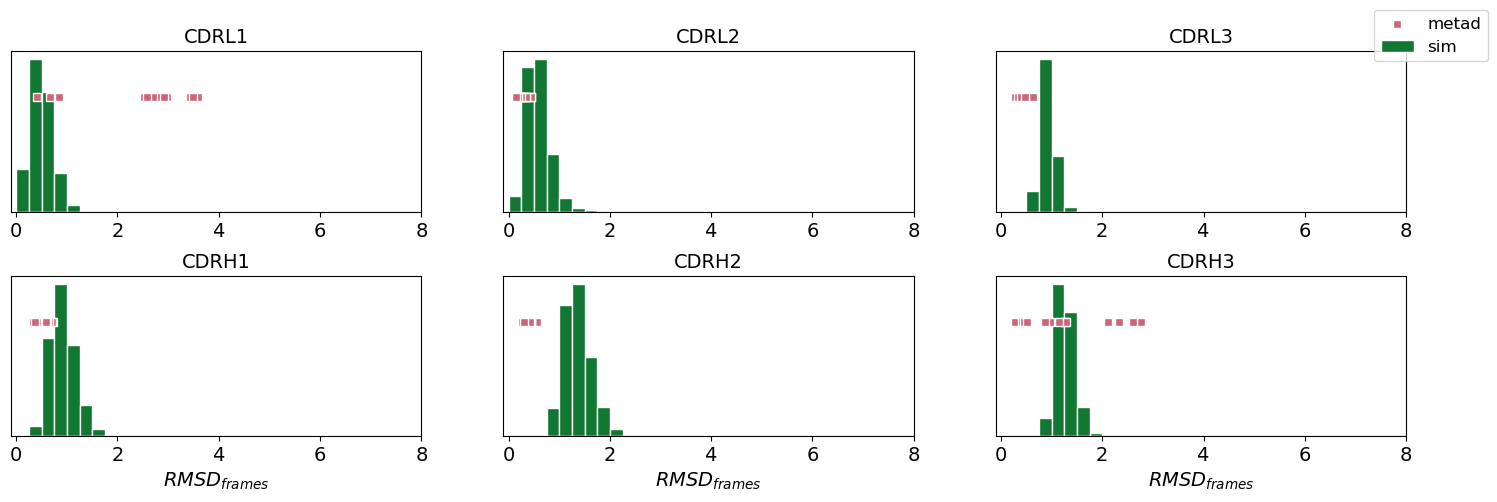

In [69]:
fig, axes = plt.subplots(2, 3, figsize=(18, 5), gridspec_kw={'hspace': 0.4, 'wspace': 0.2})
colors = ['#117733','#CC6677','#AB6D52','gray']  # One color per method
methods = list(rmsd_all_dist.keys())

# Ensure axes is 2D
axes = np.atleast_2d(axes)

for row_idx, chain in enumerate(['light','heavy']):
    for col_idx, cdr in enumerate([1, 2, 3]):
        ax = axes[row_idx, col_idx]

        for method_idx, method in enumerate(methods):
            try:
                data = rmsd_all_dist[method][chain][cdr-1]
                if method == 'pdbs':
                    y = [1.5*(len(methods)-1)] * len(data)
                    ax.scatter(data, y, facecolor=colors[method_idx], edgecolor='white',marker='s', 
                               label=method if row_idx == 0 else "")
                elif method == 'metad':
                    y = [1.5*(len(methods)-1.5)] * len(data)
                    ax.scatter(data, y, facecolor=colors[method_idx], edgecolor='white',marker='s', 
                               label=method if row_idx == 0 else "")
                else:

                    counts, bin_edges = np.histogram(data, bins=40, range=[0, 10.0])
                    pdf = counts / counts.max()
                    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
                    
                    # Plot
                    ax.bar(bin_centers, pdf, width=bin_edges[1] - bin_edges[0], 
                           color=colors[method_idx], edgecolor='w', 
                           label=method if row_idx == 0 else "", 
                           bottom=method_idx * 1.5)
                    ax.plot([0, 10], [method_idx * 1.5, method_idx * 1.5],  color='lightgray', alpha=0.2)
                    
            except KeyError:
                continue

        ax.set_xlim(-0.1, 8)
        ax.set_xticks([0,2,4,6,8])
        ax.set_xticklabels([0,2,4,6,8],fontsize=14)
        ax.set_yticks([])
        if row_idx == 1:
            ax.set_xlabel(r'$ RMSD_{frames}$',fontsize=14)
        
        ax.set_title(f"CDR{chain[0].upper()}{cdr}",fontsize=14)
# Add a legend only once
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.95, 0.98),fontsize=12)

plt.tight_layout()
plt.savefig(f'../figures/{system_name}_sim_metad_rmsd_matrix.pdf')

## 3G6D - bound

#### load starting pdb

In [70]:
dict_cv2imgt='../src/sims_cv3fv/3g6d_HL/3g6d_dict_Fv_HL.txt'

pdb_start=os.path.abspath('../src/sims_cv3fv/3g6d_HL/3g6d_Fv_HL.pdb')
chain_list='HL'

In [71]:
chain_list

'HL'

In [73]:
os.listdir('../src/metaD_clusters/3G6D_clusters/')

['cluster.CL-rep.c6.pdb',
 'cluster.CL-rep.c7.pdb',
 'cluster.CL-rep.c5.pdb',
 'cluster.CL-rep.c4.pdb',
 'cluster.CL-rep.c0.pdb',
 'cluster.CL-rep.c1.pdb',
 'cluster.CL-rep.c3.pdb',
 'cluster.CL-rep.c2.pdb']

In [74]:
n_cluster=len(os.listdir('../src/metaD_clusters/3G6D_clusters/'))

In [75]:
dict_prob_cluster={'cluster.CL-rep.c0.pdb':0.51,'cluster.CL-rep.c1.pdb':0.26,'cluster.CL-rep.c2.pdb':0.11,'cluster.CL-rep.c3.pdb':0.05,'cluster.CL-rep.c4.pdb':0.04,
                  'cluster.CL-rep.c5.pdb':0.02,'cluster.CL-rep.c6.pdb':0.008,'cluster.CL-rep.c7.pdb':0.002}

In [76]:
cluster_pdb_list=os.listdir('../src/metaD_clusters/3G6D_clusters/')
cluster_chain_list=['HL','HL','HL','HL','HL']
cluster_folder_pdbs='../src/metaD_clusters/3G6D_clusters/'
cluster_pdb_prob=np.array([dict_prob_cluster[cluster] for cluster in cluster_pdb_list])

In [77]:
sys_name='3g6d'
pdb_trajectories = [md.load(os.path.join('../src/metaD_clusters/3G6D_clusters/',pdb_name)) for pdb_name in os.listdir('../src/metaD_clusters/3G6D_clusters/')]

# Step 2: Concatenate all into a single trajectory
pdb_traj = md.join(pdb_trajectories)
pdb_traj.save_xtc(f"../src/metaD_clusters/imgt_traj_clusters/{sys_name}joined_pdbs.xtc")

pdb_traj = mda.Universe('../src/metaD_clusters/3G6D_clusters/cluster.CL-rep.c0.pdb',f"../src/metaD_clusters/imgt_traj_clusters/{sys_name}joined_pdbs.xtc")


/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/XDR.py:240: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


In [78]:
rmsd_all_dist={}
rmsd_all_dist['sim']={'heavy':{},'light':{}}
rmsd_all_dist['metad']={'heavy':{},'light':{}}

In [79]:
chain_cluster=['H','L']
for chain_idx,chain_type in enumerate(['heavy','light']):
    for idx_cdr, cdr in enumerate(cdrs_list):
        rmsd_all_dist['metad'][chain_type][idx_cdr]=dist_trajs(pdb_traj,select=f'segid {chain_cluster[chain_idx]} and name CA and resid {cdr[0]-1}:{cdr[1]+1}')
        if len(rmsd_all_dist['metad'][chain_type][idx_cdr]) ==0:
            rmsd_all_dist['metad'][chain_type][idx_cdr]=np.array([0])

### load simulations

In [80]:
top_file = '../src/sims_cv3fv/3g6d_HL/3g6d_Fv_HL.pdb'  # Path to your PDB file
chain_sequences = extract_sequences_by_chain(top_file)

# Print sequences for each chain
for chain_id, sequence in chain_sequences.items():
    print(f"Chain {chain_id} {len(sequence)}: {sequence}")
    if chain_id == 'H':
        res_heavy=sequence
    if chain_id == 'L':
        res_light=sequence

Chain H 124: QVQLVESGGGLVQPGGSLRLSCAASGFTFNSYWINWVRQAPGKGLEWVSGIAYDSSNTLYADSVKGRFTISRDNSKNTLYLQMNSLRAEDTAVYYCARGLGAFHWDMQPDYWGQGTLVTVSSAS
Chain L 110: SYELTQPPSVSVAPGQTARISCSGDNIGGTFVSWYQQKPGQAPVLVIYDDNDRPSGIPERFSGSNSGNTATLTISGTQAEDEADYYCGTWDMVTNNVFGGGTKLTVLGQP


In [81]:
sel_pdb='3g6d_Fv_HL.pdb'
sel_chain='HL'
topology_fa = "../src/sims_cv3fv/3g6d_HL/3g6d_Fv_HL_top.pdb"

top_pdb=mda.Universe(topology_fa,topology_fa)

dict_imgt2cv='../src/sims_cv3fv/3g6d_HL/3g6d_dict_Fv_HL.txt'

In [82]:
prefix_sim=os.path.abspath('../src/sims_cv3fv/3g6d_HL/3g6d_Fv_HL')
topology_fa= os.path.join(prefix_sim+"_top.pdb")


xtc_file= os.path.join(prefix_sim+"_aligned.xtc")

mobile = mda.Universe(topology_fa,xtc_file)
ref = mda.Universe(topology_fa,xtc_file)

mobile.trajectory  # set mobile trajectory to last frame
ref.trajectory[0]  # set reference trajectory to first frame

##dict_loc,chain,cdr_boundaries
cv3_cdrs_light_sim=[extract_cdr_coord(dict_imgt2cv,sel_chain[1],cdrs_list[0]),extract_cdr_coord(dict_imgt2cv,sel_chain[1],cdrs_list[1]),extract_cdr_coord(dict_imgt2cv,sel_chain[1],cdrs_list[2])]
cv3_cdrs_heavy_sim=[extract_cdr_coord(dict_imgt2cv,sel_chain[0],cdrs_list[0]),extract_cdr_coord(dict_imgt2cv,sel_chain[0],cdrs_list[1]),extract_cdr_coord(dict_imgt2cv,sel_chain[0],cdrs_list[2])]

In [83]:
Rref_cdr1_light,Rmean_cdr1_light=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_light_sim[0][0]}:{cv3_cdrs_light_sim[0][1]}')
Rref_cdr2_light,Rmean_cdr2_light=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_light_sim[1][0]}:{cv3_cdrs_light_sim[1][1]}')
Rref_cdr3_light,Rmean_cdr3_light=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_light_sim[2][0]}:{cv3_cdrs_light_sim[2][1]}')

Rref_cdr1_heavy,Rmean_cdr1_heavy=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_heavy_sim[0][0]}:{cv3_cdrs_heavy_sim[0][1]}')
Rref_cdr2_heavy,Rmean_cdr2_heavy=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_heavy_sim[1][0]}:{cv3_cdrs_heavy_sim[1][1]}')
Rref_cdr3_heavy,Rmean_cdr3_heavy=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_heavy_sim[2][0]}:{cv3_cdrs_heavy_sim[2][1]}')


/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/memory.py:535: DeprecationWarning: asel argument to timeseries will be renamed to'atomgroup' in 3.0, see #3911
  warnings.warn(


done
done
done
done
done
done


In [84]:
trajectory = md.load(xtc_file
, top=topology_fa)  # Adjust file names/paths as needed

# Light chain
atom_indices = trajectory.topology.select('name CA and chainid 0')
# Restrict the trajectory to the selected atoms
sub_traj = trajectory.atom_slice(atom_indices)
sub_traj.center_coordinates()
rmsf_sim = md.rmsf(sub_traj, sub_traj, 0, precentered=True) *10
rmsd_sim = md.rmsd(sub_traj, sub_traj, 0, precentered=True) *10

rmsf_sim_heavy=rmsf_sim[:len(res_heavy)]
rmsf_sim_light=rmsf_sim[-(len(res_light)):]

In [85]:
# Light chain
atom_indices = trajectory.topology.select(f'name CA and resid >= {cv3_cdrs_light_sim[2][0]} and resid <= {cv3_cdrs_light_sim[2][1]}')
# Restrict the trajectory to the selected atoms
sub_traj_CDRL3_sim = trajectory.atom_slice(atom_indices)
sub_traj_CDRL3_sim.center_coordinates()

# Light chain
atom_indices = trajectory.topology.select(f'name CA and resid >= {cv3_cdrs_heavy_sim[2][0]} and resid <= {cv3_cdrs_heavy_sim[2][1]}')
# Restrict the trajectory to the selected atoms
sub_traj_CDRH3_sim = trajectory.atom_slice(atom_indices)
sub_traj_CDRH3_sim.center_coordinates()

<mdtraj.Trajectory with 1010 frames, 15 atoms, 15 residues, and unitcells at 0x31a1122c0>

In [86]:
rmsf_cdr1_light_sim=rmsf_sim[(cv3_cdrs_light_sim[0][0]-1):(cv3_cdrs_light_sim[0][1])]
rmsf_cdr2_light_sim=rmsf_sim[(cv3_cdrs_light_sim[1][0]-1):(cv3_cdrs_light_sim[1][1])]
rmsf_cdr3_light_sim=rmsf_sim[(cv3_cdrs_light_sim[2][0]-1):(cv3_cdrs_light_sim[2][1])]

rmsf_cdr1_heavy_sim=rmsf_sim[(cv3_cdrs_heavy_sim[0][0]-1):(cv3_cdrs_heavy_sim[0][1])]
rmsf_cdr2_heavy_sim=rmsf_sim[(cv3_cdrs_heavy_sim[1][0]-1):(cv3_cdrs_heavy_sim[1][1])]
rmsf_cdr3_heavy_sim=rmsf_sim[(cv3_cdrs_heavy_sim[2][0]-1):(cv3_cdrs_heavy_sim[2][1])]

In [87]:
#### pdbs

In [88]:
Rmean_cdr1_light_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[0][0]-1}:{cv3_cdrs_light_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', chain_list[1])
Rmean_cdr2_light_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[1][0]-1}:{cv3_cdrs_light_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', chain_list[1])
Rmean_cdr3_light_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[2][0]-1}:{cv3_cdrs_light_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', chain_list[1])

Rmean_cdr1_heavy_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[0][0]-1}:{cv3_cdrs_heavy_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', chain_list[0])
Rmean_cdr2_heavy_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[1][0]-1}:{cv3_cdrs_heavy_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', chain_list[0])
Rmean_cdr3_heavy_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[2][0]-1}:{cv3_cdrs_heavy_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', chain_list[0])

/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:777: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


In [89]:
Rref_cdr1_light_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_light_sim[0][0]-1}:{cv3_cdrs_light_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', chain_list[1])
Rref_cdr2_light_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_light_sim[1][0]-1}:{cv3_cdrs_light_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', chain_list[1])
Rref_cdr3_light_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_light_sim[2][0]-1}:{cv3_cdrs_light_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', chain_list[1])

Rref_cdr1_heavy_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_heavy_sim[0][0]-1}:{cv3_cdrs_heavy_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', chain_list[0])
Rref_cdr2_heavy_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_heavy_sim[1][0]-1}:{cv3_cdrs_heavy_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', chain_list[0])
Rref_cdr3_heavy_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_heavy_sim[2][0]-1}:{cv3_cdrs_heavy_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', chain_list[0])

/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/base.py:725: UserWarning: Reader has no dt information, set to 1.0 ps
  return self.ts.dt


In [90]:
Rmetad_cdr1_light_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[0][0]-1}:{cv3_cdrs_light_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', 'L')
Rmetad_cdr2_light_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[1][0]-1}:{cv3_cdrs_light_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', 'L')
Rmetad_cdr3_light_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[2][0]-1}:{cv3_cdrs_light_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', 'L')

Rmetad_cdr1_heavy_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[0][0]-1}:{cv3_cdrs_heavy_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', 'H')
Rmetad_cdr2_heavy_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[1][0]-1}:{cv3_cdrs_heavy_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', 'H')
Rmetad_cdr3_heavy_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[2][0]-1}:{cv3_cdrs_heavy_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', 'H')

1018
1018
1018
1018
1018
1018


In [91]:
chain_sim=['P000','P001']
cdr_sim=[cv3_cdrs_heavy_sim,cv3_cdrs_light_sim]
for chain_idx,chain_type in enumerate(['heavy','light']):
    for idx_cdr, cdr in enumerate(cdrs_list):
        rmsd_all_dist['sim'][chain_type][idx_cdr]=dist_trajs(mobile,select=f'segid {chain_sim[chain_idx]} and name CA and resid {cdr_sim[chain_idx][chain_idx][0]-1}:{cdr_sim[chain_idx][idx_cdr][1]+1}').flatten()

### plots

In [92]:
size_clusters=np.array([250*np.sqrt(dict_prob_cluster[cluster_file]) for cluster_file in reversed(os.listdir('../src/metaD_clusters/3G6D_clusters/'))])

In [94]:
start_chain_light=len(res_heavy)

In [95]:
np.array(list(dict_prob_cluster.values()))*20

array([10.2 ,  5.2 ,  2.2 ,  1.  ,  0.8 ,  0.4 ,  0.16,  0.04])

In [96]:
cluster_dot_size=[]
for cluster in os.listdir('../src/metaD_clusters/3G6D_clusters/'):
    cluster_dot_size.append(dict_prob_cluster[cluster])
cluster_dot_size=np.array(cluster_dot_size)

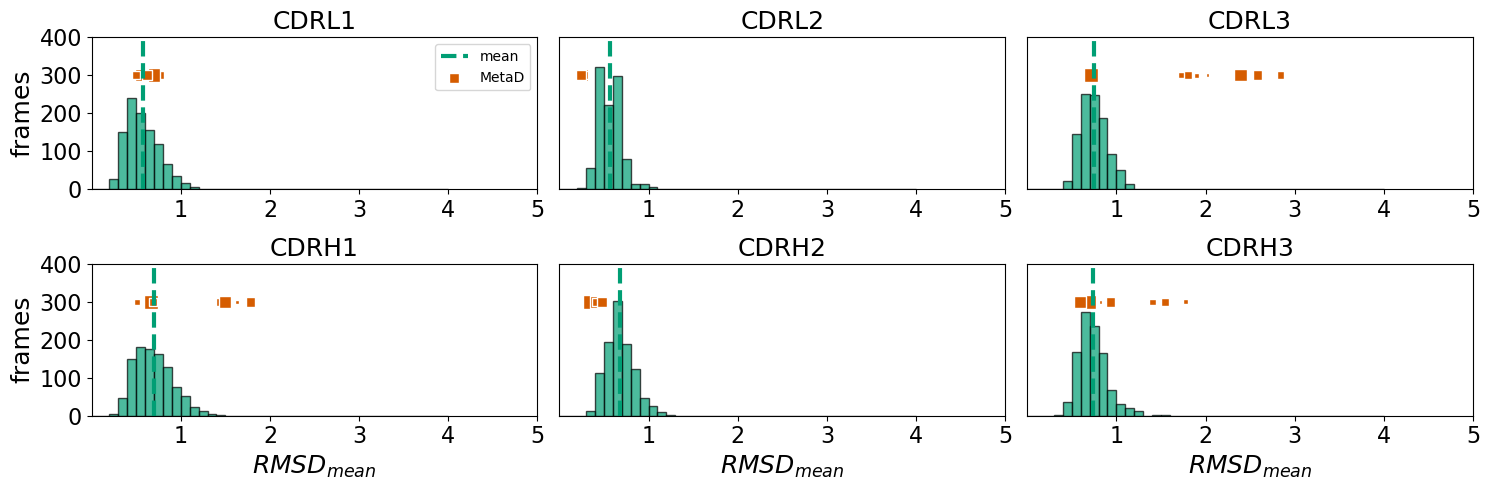

In [97]:
system_name='3G6D'

fig,(axs)=plt.subplots(2,3,figsize=(15,5))

axs=axs.flatten()

counts=axs[0].hist(Rmean_cdr1_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[0].plot([np.mean(Rmean_cdr1_light[2,:]),np.mean(Rmean_cdr1_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='mean')
axs[0].scatter([Rmean_cdr1_light_pdb],[[300 for i in Rmean_cdr1_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00',label='MetaD')
axs[0].legend()

axs[0].set_title('CDRL1',fontsize=18)

counts=axs[1].hist(Rmean_cdr2_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[1].plot([np.mean(Rmean_cdr2_light[2,:]),np.mean(Rmean_cdr2_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[1].scatter([Rmean_cdr2_light_pdb],[[300 for i in Rmean_cdr2_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[1].set_title('CDRL2',fontsize=18)


counts=axs[2].hist(Rmean_cdr3_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[2].plot([np.mean(Rmean_cdr3_light[2,:]),np.mean(Rmean_cdr3_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[2].scatter([Rmean_cdr3_light_pdb],[[300 for i in Rmean_cdr3_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[2].set_title('CDRL3',fontsize=18)


counts=axs[3].hist(Rmean_cdr1_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[3].plot([np.mean(Rmean_cdr1_heavy[2,:]),np.mean(Rmean_cdr1_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[3].scatter([Rmean_cdr1_heavy_pdb],[[300 for i in Rmean_cdr1_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[3].set_title('CDRH1',fontsize=18)


counts=axs[4].hist(Rmean_cdr2_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[4].plot([np.mean(Rmean_cdr2_heavy[2,:]),np.mean(Rmean_cdr2_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[4].scatter([Rmean_cdr2_heavy_pdb],[[300 for i in Rmean_cdr2_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[4].set_title('CDRH2',fontsize=18)


counts=axs[5].hist(Rmean_cdr3_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[5].plot([np.mean(Rmean_cdr3_heavy[2,:]),np.mean(Rmean_cdr3_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[5].scatter([Rmean_cdr3_heavy_pdb],[[300 for i in Rmean_cdr3_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[5].set_title('CDRH3',fontsize=18)

for ax in axs:

    ax.set_xlim(0,5)
    ax.set_ylim(0,400)
    ax.set_yticks([0,100,200,300,400])
    ax.set_yticklabels([0,100,200,300,400],fontsize=16)
    ax.set_xticks([1,2,3,4,5])
    ax.set_xticklabels([1,2,3,4,5],fontsize=16)
axs[3].set_xlabel(r'$RMSD_{mean}$',fontsize=18)
axs[4].set_xlabel(r'$RMSD_{mean}$',fontsize=18)
axs[5].set_xlabel(r'$RMSD_{mean}$',fontsize=18)

axs[0].set_ylabel('frames',fontsize=18)
axs[3].set_ylabel('frames',fontsize=18)
axs[0].legend()

for ax in [axs[1],axs[2],axs[4],axs[5]]:
    ax.set_yticks([])


fig.tight_layout()
plt.savefig(f'../figures/{system_name}_restraints_rmsd_all_cdrs.pdf')

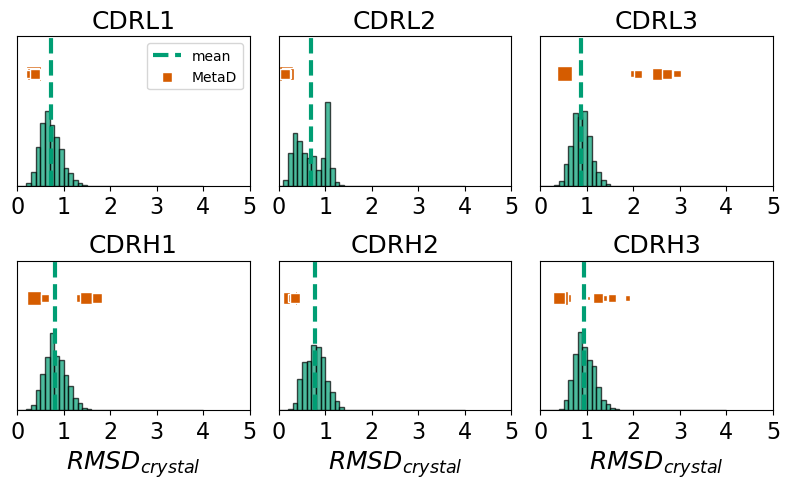

In [98]:
system_name='3GD6'

fig,(axs)=plt.subplots(2,3,figsize=(8,5))

axs=axs.flatten()

counts=axs[0].hist(Rref_cdr1_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[0].plot([np.mean(Rref_cdr1_light[2,:]),np.mean(Rref_cdr1_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='mean')
axs[0].scatter([Rref_cdr1_light_pdb],[[300 for i in Rref_cdr1_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00',label='MetaD')
axs[0].legend(fontsize=18)

axs[0].set_title('CDRL1',fontsize=18)

counts=axs[1].hist(Rref_cdr2_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[1].plot([np.mean(Rref_cdr2_light[2,:]),np.mean(Rref_cdr2_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[1].scatter([Rref_cdr2_light_pdb],[[300 for i in Rref_cdr2_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[1].set_title('CDRL2',fontsize=18)


counts=axs[2].hist(Rref_cdr3_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[2].plot([np.mean(Rref_cdr3_light[2,:]),np.mean(Rref_cdr3_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[2].scatter([Rref_cdr3_light_pdb],[[300 for i in Rref_cdr3_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[2].set_title('CDRL3',fontsize=18)


counts=axs[3].hist(Rref_cdr1_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[3].plot([np.mean(Rref_cdr1_heavy[2,:]),np.mean(Rref_cdr1_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[3].scatter([Rref_cdr1_heavy_pdb],[[300 for i in Rref_cdr1_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[3].set_title('CDRH1',fontsize=18)


counts=axs[4].hist(Rref_cdr2_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[4].plot([np.mean(Rref_cdr2_heavy[2,:]),np.mean(Rref_cdr2_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[4].scatter([Rref_cdr2_heavy_pdb],[[300 for i in Rref_cdr2_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[4].set_title('CDRH2',fontsize=18)


counts=axs[5].hist(Rref_cdr3_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[5].plot([np.mean(Rref_cdr3_heavy[2,:]),np.mean(Rref_cdr3_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[5].scatter([Rref_cdr3_heavy_pdb],[[300 for i in Rref_cdr3_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[5].set_title('CDRH3',fontsize=18)

for ax in axs:

    ax.set_xlim(0,5)
    ax.set_ylim(0,400)
    ax.set_xticks([0,1,2,3,4,5])
    ax.set_xticklabels([0,1,2,3,4,5],fontsize=16)
axs[3].set_xlabel(r'$RMSD_{crystal}$',fontsize=18)
axs[4].set_xlabel(r'$RMSD_{crystal}$',fontsize=18)
axs[5].set_xlabel(r'$RMSD_{crystal}$',fontsize=18)

axs[0].legend()

for ax in axs:
    ax.set_yticks([])
fig.tight_layout()
plt.savefig(f'../figures/{system_name}_restraints_rmsd_ref_cdrs.pdf')

In [99]:
order_cluster={}
for idx,cluster in enumerate(os.listdir('../src/metaD_clusters/3G6D_clusters/')):
    order_cluster[cluster]=idx
cluster_ordered=sorted(os.listdir('../src/metaD_clusters/3G6D_clusters/'), key=extract_number)

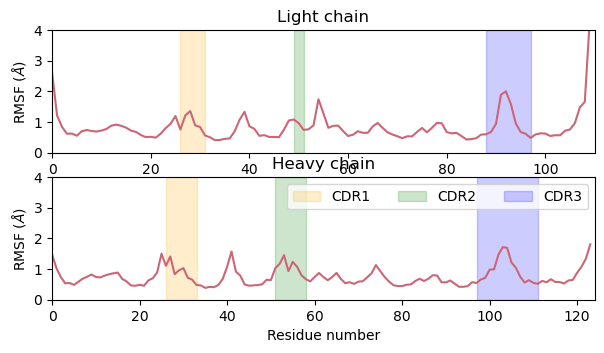

In [100]:
fig,(axs)=plt.subplots(2,1,figsize=(7,3.5))

axs[0].plot([i for i in range(len(res_light))],rmsf_sim_light,color='#CC6677')

axs[0].set_xlabel('Residue number')
axs[0].set_ylabel('RMSF ($\AA$)')
axs[0].axvspan(cv3_cdrs_light_sim[0][0]-start_chain_light,cv3_cdrs_light_sim[0][1]-start_chain_light, zorder=0, alpha=0.2, color='orange', label='CDR1')
axs[0].axvspan(cv3_cdrs_light_sim[1][0]-start_chain_light,cv3_cdrs_light_sim[1][1]-start_chain_light, zorder=0, alpha=0.2, color='green', label='CDR2')
axs[0].axvspan(cv3_cdrs_light_sim[2][0]-start_chain_light,cv3_cdrs_light_sim[2][1]-start_chain_light, zorder=0, alpha=0.2, color='blue', label='CDR3')
axs[0].set_ylim(0,4)
axs[0].set_xlim(0,len(res_light))


axs[1].plot([i for i in range(len(res_heavy))],rmsf_sim_heavy, color='#CC6677')

axs[1].set_xlabel('Residue number')
axs[1].set_ylabel('RMSF ($\AA$)')
axs[1].axvspan(cv3_cdrs_heavy_sim[0][0],cv3_cdrs_heavy_sim[0][1], zorder=0, alpha=0.2, color='orange', label='CDR1')
axs[1].axvspan(cv3_cdrs_heavy_sim[1][0],cv3_cdrs_heavy_sim[1][1], zorder=0, alpha=0.2, color='green', label='CDR2')
axs[1].axvspan(cv3_cdrs_heavy_sim[2][0],cv3_cdrs_heavy_sim[2][1], zorder=0, alpha=0.2, color='blue', label='CDR3')
axs[1].set_ylim(0,4)
axs[1].legend(ncol=3)
axs[1].set_xlim(0,len(res_heavy))

axs[1].set_title('Heavy chain')
axs[0].set_title('Light chain')

plt.savefig(f'../figures/{system_name}_restraints_rmsf_all.pdf')

/var/folders/8w/2dqxrgsd4vj00wv819dcz51w0000gn/T/ipykernel_44258/2441655020.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


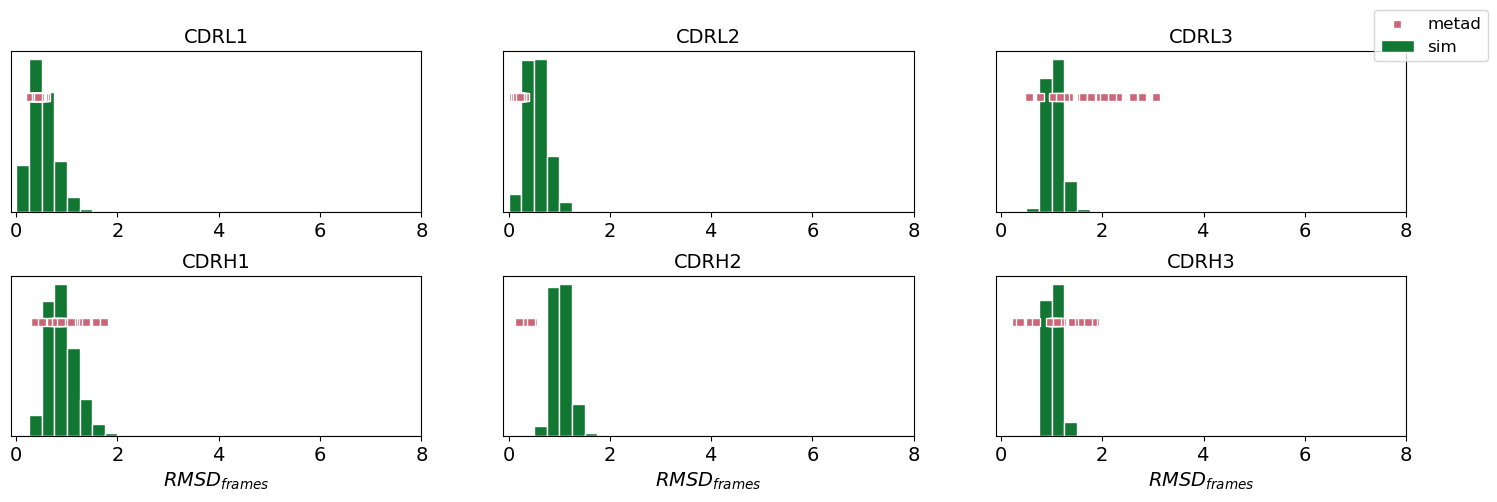

In [101]:
fig, axes = plt.subplots(2, 3, figsize=(18, 5), gridspec_kw={'hspace': 0.4, 'wspace': 0.2})
colors = ['#117733','#CC6677','#AB6D52','gray']  # One color per method
methods = list(rmsd_all_dist.keys())

# Ensure axes is 2D
axes = np.atleast_2d(axes)

for row_idx, chain in enumerate(['light','heavy']):
    for col_idx, cdr in enumerate([1, 2, 3]):
        ax = axes[row_idx, col_idx]

        for method_idx, method in enumerate(methods):
            try:
                data = rmsd_all_dist[method][chain][cdr-1]
                if method == 'pdbs':
                    y = [1.5*(len(methods)-1)] * len(data)
                    ax.scatter(data, y, facecolor=colors[method_idx], edgecolor='white',marker='s', 
                               label=method if row_idx == 0 else "")
                elif method == 'metad':
                    y = [1.5*(len(methods)-1.5)] * len(data)
                    ax.scatter(data, y, facecolor=colors[method_idx], edgecolor='white',marker='s', 
                               label=method if row_idx == 0 else "")
                else:

                    counts, bin_edges = np.histogram(data, bins=40, range=[0, 10.0])
                    pdf = counts / counts.max()
                    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
                    
                    # Plot
                    ax.bar(bin_centers, pdf, width=bin_edges[1] - bin_edges[0], 
                           color=colors[method_idx], edgecolor='w', 
                           label=method if row_idx == 0 else "", 
                           bottom=method_idx * 1.5)
                    ax.plot([0, 10], [method_idx * 1.5, method_idx * 1.5],  color='lightgray', alpha=0.2)
                    
            except KeyError:
                continue

        ax.set_xlim(-0.1, 8)
        ax.set_xticks([0,2,4,6,8])
        ax.set_xticklabels([0,2,4,6,8],fontsize=14)
        ax.set_yticks([])
        if row_idx == 1:
            ax.set_xlabel(r'$ RMSD_{frames}$',fontsize=14)
        
        ax.set_title(f"CDR{chain[0].upper()}{cdr}",fontsize=14)
# Add a legend only once
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.95, 0.98),fontsize=12)

plt.tight_layout()
plt.savefig(f'../figures/{system_name}_sim_metad_rmsd_matrix.pdf')

## 3V6F - unbound

#### load starting pdb

In [102]:
dict_cv2imgt='../src/sims_cv3fv/3v6f_HL/3v6f_dict_Fv_HL.txt'

pdb_start=os.path.abspath('../src/sims_cv3fv/3v6f_HL/3v6f_Fv_HL.pdb')

chain_list='HL'

In [103]:
pdb_list=['3v6f_Fv_HL.pdb']
chain_list=['HL']

In [104]:
chain_list

['HL']

In [105]:
os.listdir('../src/metaD_clusters/3V6F_clusters/')

['cluster_8.pdb',
 'cluster_4.pdb',
 'cluster_5.pdb',
 'cluster_7.pdb',
 'cluster_6.pdb',
 'cluster_2.pdb',
 'cluster_3.pdb',
 'cluster_1.pdb',
 'cluster_0.pdb']

In [106]:
n_cluster=len(os.listdir('../src/metaD_clusters/3V6F_clusters/'))

In [107]:
dict_prob_cluster={'cluster_0.pdb':0.9,'cluster_1.pdb':0.8,'cluster_2.pdb':0.7,'cluster_3.pdb':0.6,'cluster_4.pdb':0.5,'cluster_5.pdb':0.4,
                  'cluster_6.pdb':0.3,'cluster_7.pdb':0.2,'cluster_8.pdb':0.1}

In [108]:
cluster_pdb_list=os.listdir('../src/metaD_clusters/3V6F_clusters/')
cluster_chain_list=['HL','HL','HL','HL','HL']
cluster_folder_pdbs='../src/metaD_clusters/3V6F_clusters/'
cluster_pdb_prob=np.array([dict_prob_cluster[cluster] for cluster in cluster_pdb_list])

In [109]:
sys_name='3v6f'
pdb_trajectories = [md.load(os.path.join('../src/metaD_clusters/3V6F_clusters/',pdb_name)) for pdb_name in os.listdir('../src/metaD_clusters/3V6F_clusters/')]

# Step 2: Concatenate all into a single trajectory
pdb_traj = md.join(pdb_trajectories)
pdb_traj.save_xtc(f"../src/metaD_clusters/imgt_traj_clusters/{sys_name}joined_pdbs.xtc")

pdb_traj = mda.Universe('../src/metaD_clusters/3V6F_clusters/cluster_0.pdb',f"../src/metaD_clusters/imgt_traj_clusters/{sys_name}joined_pdbs.xtc")


/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/XDR.py:240: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


In [110]:
rmsd_all_dist={}
rmsd_all_dist['sim']={'heavy':{},'light':{}}
rmsd_all_dist['metad']={'heavy':{},'light':{}}
rmsd_all_dist['fa']={'heavy':{},'light':{}}

In [111]:
chain_cluster=['H','L']
for chain_idx,chain_type in enumerate(['heavy','light']):
    for idx_cdr, cdr in enumerate(cdrs_list):
        rmsd_all_dist['metad'][chain_type][idx_cdr]=dist_trajs(pdb_traj,select=f'segid {chain_cluster[chain_idx]} and name CA and resid {cdr[0]-1}:{cdr[1]+1}')
        if len(rmsd_all_dist['metad'][chain_type][idx_cdr]) ==0:
            rmsd_all_dist['metad'][chain_type][idx_cdr]=np.array([0])

### load fa simulations

In [112]:
top_file = '../src/sims_cv3fv/3v6f_HL/3v6f_Fv_HL.pdb'  # Path to your PDB file
chain_sequences = extract_sequences_by_chain(top_file)

# Print sequences for each chain
for chain_id, sequence in chain_sequences.items():
    print(f"Chain {chain_id} {len(sequence)}: {sequence}")
    if chain_id == 'H':
        res_heavy=sequence
    if chain_id == 'L':
        res_light=sequence

Chain H 125: EVQLVESGGDLVKPGGSLKLSCAASGFTFSSYGMSWVRQTPDKRLEWVATISSGGNYIYYPDTVKGRFTISRDNAKNTLYLQMSSLKSEDTAMYYCTREGAYSGSSSYPMDYWGQGTSVTVSSAK
Chain L 117: NIMMTQSPSSLAVSAGEKVTMNCKSSQSVLYSSNQKNYLAWYQQKPGQSPKLLIYWASTRESGVPDRFTGSGSGTDFTLTISSVQTEDLAVYYCHQYLSSYMYTFGGGTKLEIKRAD


In [116]:
top_file = '../src/aa_md/3v6f.pdb'  # Path to your PDB file
xtc_file='../src/aa_md/3v6f_ion_strip_merged.xtc' ### traj need to be merged first, you can use mdanalysis for this

mobile = mda.Universe(top_file,xtc_file)
ref = mda.Universe(top_file,xtc_file)


In [117]:
cv3_cdrs_heavy_fa=[[26,33],[51,58],[97,112]]

In [118]:
cv3_cdrs_light_fa=[[242,253],[271,273],[310,319]]

In [119]:
Rref_cdr1_light_fa,Rmean_cdr1_light_fa=calc_rmsd(mobile,ref,select=f'backbone and resid {cv3_cdrs_light_fa[0][0]}:{cv3_cdrs_light_fa[0][1]}')
Rref_cdr2_light_fa,Rmean_cdr2_light_fa=calc_rmsd(mobile,ref,select=f'backbone and resid {cv3_cdrs_light_fa[1][0]}:{cv3_cdrs_light_fa[1][1]}')
Rref_cdr3_light_fa,Rmean_cdr3_light_fa=calc_rmsd(mobile,ref,select=f'backbone and resid {cv3_cdrs_light_fa[2][0]}:{cv3_cdrs_light_fa[2][1]}')

Rref_cdr1_heavy_fa,Rmean_cdr1_heavy_fa=calc_rmsd(mobile,ref,select=f'backbone and resid {cv3_cdrs_heavy_fa[0][0]}:{cv3_cdrs_heavy_fa[0][1]}')
Rref_cdr2_heavy_fa,Rmean_cdr2_heavy_fa=calc_rmsd(mobile,ref,select=f'backbone and resid {cv3_cdrs_heavy_fa[1][0]}:{cv3_cdrs_heavy_fa[1][1]}')
Rref_cdr3_heavy_fa,Rmean_cdr3_heavy_fa=calc_rmsd(mobile,ref,select=f'backbone and resid {cv3_cdrs_heavy_fa[2][0]}:{cv3_cdrs_heavy_fa[2][1]}')

/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/memory.py:535: DeprecationWarning: asel argument to timeseries will be renamed to'atomgroup' in 3.0, see #3911
  warnings.warn(


done
done
done
done
done
done


In [120]:
trajectory = md.load(xtc_file, top=top_file)  # Adjust file names/paths as needed
com_distances= com_distance_array(trajectory, (1,120), (218,333))

In [121]:
filtered_trajectory=filter_frames_by_distance(trajectory,com_distances, 4.)

In [122]:
# Light chain
atom_indices = filtered_trajectory.topology.select('name CA and chainid 0')
# Restrict the trajectory to the selected atoms
sub_traj = filtered_trajectory.atom_slice(atom_indices)
sub_traj.center_coordinates()
rmsf_fa = md.rmsf(sub_traj, sub_traj, 0, precentered=True) *10
rmsd_fa = md.rmsd(sub_traj, sub_traj, 0, precentered=True) *10

rmsf_fa_heavy=rmsf_fa[:215]
rmsf_fa_light=rmsf_fa[215:]

In [123]:
Rmean_cdr1_light_fa_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_fa[0][0]-1}:{cv3_cdrs_light_fa[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', 'L')
Rmean_cdr2_light_fa_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_fa[1][0]-1}:{cv3_cdrs_light_fa[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', 'L')
Rmean_cdr3_light_fa_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_fa[2][0]-1}:{cv3_cdrs_light_fa[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', 'L')

Rmean_cdr1_heavy_fa_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_fa[0][0]-1}:{cv3_cdrs_heavy_fa[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', 'H')
Rmean_cdr2_heavy_fa_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_fa[1][0]-1}:{cv3_cdrs_heavy_fa[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', 'H')
Rmean_cdr3_heavy_fa_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_fa[2][0]-1}:{cv3_cdrs_heavy_fa[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', 'H')

/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:777: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'chainIDs' Using default value of ''
  warnings.warn("Found no information for attr: '{}'"
/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: F

In [124]:
dict_chains={'heavy':'H', 'light':'L'}
cdr_sim=[cv3_cdrs_heavy_fa,cv3_cdrs_light_fa]

for chain_idx,chain_type in enumerate(['heavy','light']):
    for idx_cdr, cdr in enumerate(cdrs_list):
        try:
            print(idx_cdr)
            hist_counts=np.load(f'../src/aa_md/histogramed_data/{sys_name}_{chain_type}_{(idx_cdr+1)}_hist_fa.npy')
            rmsd_all_dist['fa'][chain_type][idx_cdr]=hist_counts
        except:
            print('na yet',cdr)
        

0
1
2
0
1
2


### load simulations

In [125]:
sel_pdb='3v6f_Fv_HL.pdb'
sel_chain='HL'
topology_fa = "../src/sims_cv3fv/3v6f_HL/3v6f_Fv_HL_top.pdb"

top_pdb=mda.Universe(topology_fa,topology_fa)

dict_imgt2cv='../src/sims_cv3fv/3v6f_HL/3v6f_dict_Fv_HL.txt'

In [126]:
prefix_sim=os.path.abspath('../src/sims_cv3fv/3v6f_HL/3v6f_Fv_HL')
topology_fa= os.path.join(prefix_sim+"_top.pdb")
xtc_file = os.path.join(prefix_sim+"_aligned.xtc")

output_chimera_file = os.path.join(prefix_sim+"_chimera_aligned.xtc")

mobile = mda.Universe(topology_fa,xtc_file)
ref = mda.Universe(topology_fa,xtc_file)

mobile.trajectory  # set mobile trajectory to last frame
ref.trajectory[0]  # set reference trajectory to first frame
        
##dict_loc,chain,cdr_boundaries
cv3_cdrs_light_sim=[extract_cdr_coord(dict_imgt2cv,sel_chain[1],cdrs_list[0]),extract_cdr_coord(dict_imgt2cv,sel_chain[1],cdrs_list[1]),extract_cdr_coord(dict_imgt2cv,sel_chain[1],cdrs_list[2])]
cv3_cdrs_heavy_sim=[extract_cdr_coord(dict_imgt2cv,sel_chain[0],cdrs_list[0]),extract_cdr_coord(dict_imgt2cv,sel_chain[0],cdrs_list[1]),extract_cdr_coord(dict_imgt2cv,sel_chain[0],cdrs_list[2])]

/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/XDR.py:240: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


In [127]:
cv3_cdrs_heavy_sim

[[26, 33], [51, 58], [97, 112]]

In [128]:
cv3_cdrs_light_sim

[[152, 163], [181, 183], [220, 229]]

In [129]:
Rref_cdr1_light,Rmean_cdr1_light=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_light_sim[0][0]}:{cv3_cdrs_light_sim[0][1]}')
Rref_cdr2_light,Rmean_cdr2_light=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_light_sim[1][0]}:{cv3_cdrs_light_sim[1][1]}')
Rref_cdr3_light,Rmean_cdr3_light=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_light_sim[2][0]}:{cv3_cdrs_light_sim[2][1]}')

Rref_cdr1_heavy,Rmean_cdr1_heavy=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_heavy_sim[0][0]}:{cv3_cdrs_heavy_sim[0][1]}')
Rref_cdr2_heavy,Rmean_cdr2_heavy=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_heavy_sim[1][0]}:{cv3_cdrs_heavy_sim[1][1]}')
Rref_cdr3_heavy,Rmean_cdr3_heavy=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_heavy_sim[2][0]}:{cv3_cdrs_heavy_sim[2][1]}')


/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/memory.py:535: DeprecationWarning: asel argument to timeseries will be renamed to'atomgroup' in 3.0, see #3911
  warnings.warn(


done
done
done
done
done
done


In [130]:
trajectory = md.load(xtc_file
, top=topology_fa)  # Adjust file names/paths as needed

# Light chain
atom_indices = trajectory.topology.select('name CA and chainid 0')
# Restrict the trajectory to the selected atoms
sub_traj = trajectory.atom_slice(atom_indices)
sub_traj.center_coordinates()
rmsf_sim = md.rmsf(sub_traj, sub_traj, 0, precentered=True) *10
rmsd_sim = md.rmsd(sub_traj, sub_traj, 0, precentered=True) *10

rmsf_sim_heavy=rmsf_sim[:len(res_heavy)]
rmsf_sim_light=rmsf_sim[-(len(res_light)):]

In [131]:
# Light chain
atom_indices = trajectory.topology.select(f'name CA and resid >= {cv3_cdrs_light_sim[2][0]} and resid <= {cv3_cdrs_light_sim[2][1]}')
# Restrict the trajectory to the selected atoms
sub_traj_CDRL3_sim = trajectory.atom_slice(atom_indices)
sub_traj_CDRL3_sim.center_coordinates()

# Light chain
atom_indices = trajectory.topology.select(f'name CA and resid >= {cv3_cdrs_heavy_sim[2][0]} and resid <= {cv3_cdrs_heavy_sim[2][1]}')
# Restrict the trajectory to the selected atoms
sub_traj_CDRH3_sim = trajectory.atom_slice(atom_indices)
sub_traj_CDRH3_sim.center_coordinates()

<mdtraj.Trajectory with 1010 frames, 16 atoms, 16 residues, and unitcells at 0x1200ac280>

In [132]:
rmsf_cdr1_light_sim=rmsf_sim[(cv3_cdrs_light_sim[0][0]-1):(cv3_cdrs_light_sim[0][1])]
rmsf_cdr2_light_sim=rmsf_sim[(cv3_cdrs_light_sim[1][0]-1):(cv3_cdrs_light_sim[1][1])]
rmsf_cdr3_light_sim=rmsf_sim[(cv3_cdrs_light_sim[2][0]-1):(cv3_cdrs_light_sim[2][1])]

rmsf_cdr1_heavy_sim=rmsf_sim[(cv3_cdrs_heavy_sim[0][0]-1):(cv3_cdrs_heavy_sim[0][1])]
vrmsf_cdr2_heavy_sim=rmsf_sim[(cv3_cdrs_heavy_sim[1][0]-1):(cv3_cdrs_heavy_sim[1][1])]
rmsf_cdr3_heavy_sim=rmsf_sim[(cv3_cdrs_heavy_sim[2][0]-1):(cv3_cdrs_heavy_sim[2][1])]

In [133]:
cdrs_res_labels={'L':{},'H':{}}

for idx_chain,cdr_chain_list in enumerate([cv3_cdrs_light_sim,cv3_cdrs_heavy_sim]):
    for cdr_idx in [0,1,2]:
    # Select the residues
        residues = mobile.select_atoms(f"resid {cdr_chain_list[cdr_idx][0]}:{cdr_chain_list[cdr_idx][1]}").residues
        # Now extract their names
        residue_idx= [res.resid for res in residues]
        residue_names = [res.resname for res in residues]
        
        with open(dict_imgt2cv,'r') as f:
            dict_tmp=json.load(f)
            if idx_chain ==0:
                dict_sim_to_imgt = {v : k for k, v in dict_tmp['L'].items()}
            else:
                dict_sim_to_imgt = {v : k for k, v in dict_tmp['H'].items()}
        
        cdr_labels=[]    
        
        for resid,resname in zip(residue_idx,residue_names):
            
            cdr_labels.append(resname+str(dict_sim_to_imgt[resid]))
        if idx_chain ==0:
            cdrs_res_labels['L'][cdr_idx+1]=cdr_labels
        else:
            cdrs_res_labels['H'][cdr_idx+1]=cdr_labels

#### rmsd pdbs

In [136]:
Rmean_cdr1_light_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[0][0]-1}:{cv3_cdrs_light_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', chain_list[0][1])
Rmean_cdr2_light_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[1][0]-1}:{cv3_cdrs_light_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', chain_list[0][1])
Rmean_cdr3_light_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[2][0]-1}:{cv3_cdrs_light_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', chain_list[0][1])

Rmean_cdr1_heavy_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[0][0]-1}:{cv3_cdrs_heavy_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', chain_list[0][0])
Rmean_cdr2_heavy_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[1][0]-1}:{cv3_cdrs_heavy_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', chain_list[0][0])
Rmean_cdr3_heavy_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[2][0]-1}:{cv3_cdrs_heavy_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', chain_list[0][0])

In [137]:
Rref_cdr1_light_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_light_sim[0][0]-1}:{cv3_cdrs_light_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', chain_list[0][1])
Rref_cdr2_light_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_light_sim[1][0]-1}:{cv3_cdrs_light_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', chain_list[0][1])
Rref_cdr3_light_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_light_sim[2][0]-1}:{cv3_cdrs_light_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', chain_list[0][1])

Rref_cdr1_heavy_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_heavy_sim[0][0]-1}:{cv3_cdrs_heavy_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', chain_list[0][0])
Rref_cdr2_heavy_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_heavy_sim[1][0]-1}:{cv3_cdrs_heavy_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', chain_list[0][0])
Rref_cdr3_heavy_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_heavy_sim[2][0]-1}:{cv3_cdrs_heavy_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', chain_list[0][0])

In [138]:
Rmetad_cdr1_light_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[0][0]-1}:{cv3_cdrs_light_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', 'L')
Rmetad_cdr2_light_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[1][0]-1}:{cv3_cdrs_light_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', 'L')
Rmetad_cdr3_light_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[2][0]-1}:{cv3_cdrs_light_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', 'L')

Rmetad_cdr1_heavy_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[0][0]-1}:{cv3_cdrs_heavy_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', 'H')
Rmetad_cdr2_heavy_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[1][0]-1}:{cv3_cdrs_heavy_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', 'H')
Rmetad_cdr3_heavy_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[2][0]-1}:{cv3_cdrs_heavy_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', 'H')

1019
1019
1019
1019
1019
1019


In [139]:
##RTEMOVE AT THE END
chain_sim=['P000','P001']
cdr_sim=[cv3_cdrs_heavy_sim,cv3_cdrs_light_sim]
for chain_idx,chain_type in enumerate(['heavy','light']):
    for idx_cdr, cdr in enumerate(cdrs_list):
        #try:
            print(idx_cdr)
            dist_array=dist_trajs(mobile,select=f'segid {chain_sim[chain_idx]} and name CA and resid {cdr_sim[chain_idx][idx_cdr][0]-1}:{cdr_sim[chain_idx][idx_cdr][1]+1}').flatten()
            hist_counts, bin_edges = np.histogram(dist_array, bins=40, range=(0, 5.0), density=True)
            hist_counts=np.array(list(hist_counts[2:])+[0.00000000e+00,0.00000000e+00])
            np.save(f'../src/aa_md/histogramed_data/{sys_name}_{chain_type}_{(idx_cdr+1)}_hist_cv3.npy',hist_counts)
        # except:
        #     print('dist array not found',cdr)
        

0
1
2
0
1
2


In [140]:
chain_sim=['P000','P001']
cdr_sim=[cv3_cdrs_heavy_sim,cv3_cdrs_light_sim]
for chain_idx,chain_type in enumerate(['heavy','light']):
    for idx_cdr, cdr in enumerate(cdrs_list):
        hist_counts=np.load(f'../src/aa_md/histogramed_data/{sys_name}_{chain_type}_{(idx_cdr+1)}_hist_cv3.npy')
        rmsd_all_dist['sim'][chain_type][idx_cdr]=hist_counts


### plots

In [141]:
size_clusters=np.array([150 for cluster_file in reversed(os.listdir('../src/metaD_clusters/3V6F_clusters/'))])

In [142]:
system_name='3V6F'


In [144]:
start_chain_light=len(res_heavy)

In [145]:
cluster_dot_size=[]
for cluster in os.listdir('../src/metaD_clusters/3V6F_clusters/'):
    cluster_dot_size.append(dict_prob_cluster[cluster])
cluster_dot_size=np.array(cluster_dot_size)

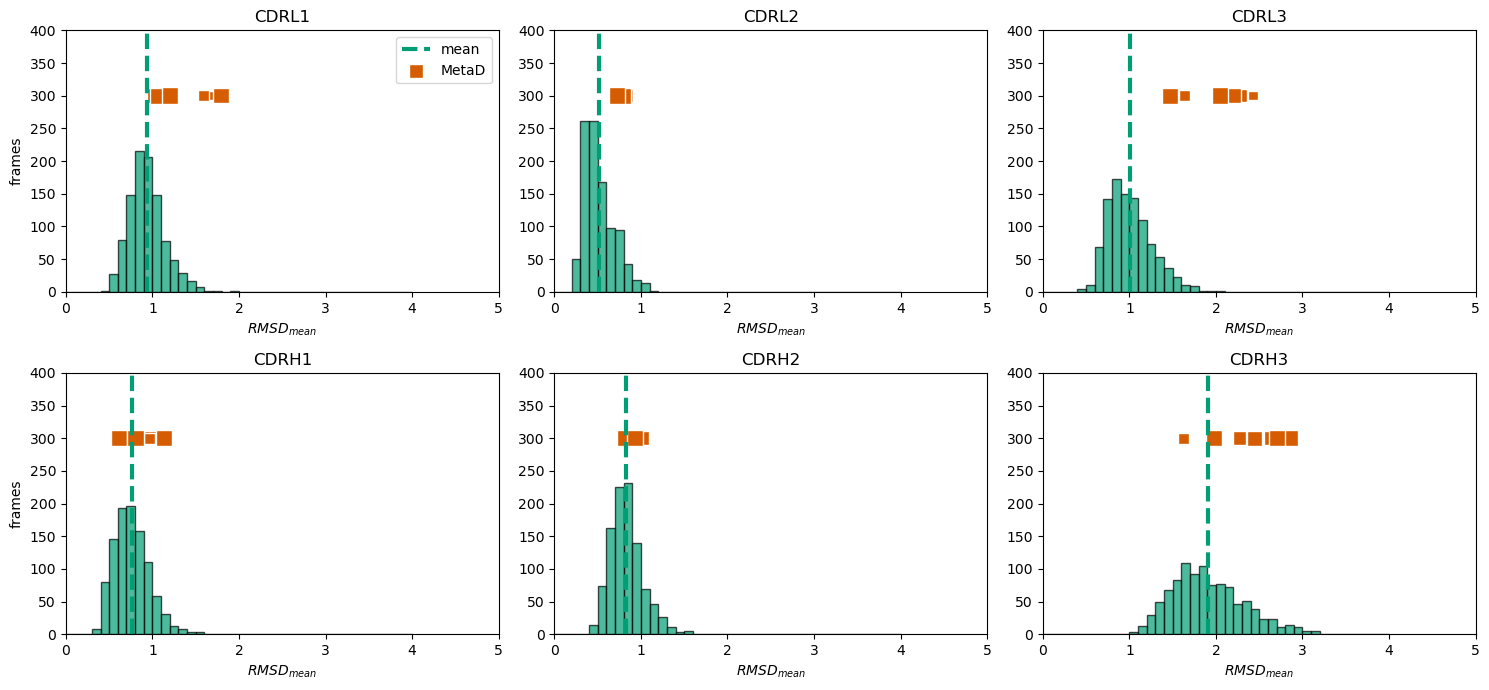

In [146]:
system_name='3V6F'

fig,(axs)=plt.subplots(2,3,figsize=(15,7))

axs=axs.flatten()

counts=axs[0].hist(Rmean_cdr1_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[0].plot([np.mean(Rmean_cdr1_light[2,:]),np.mean(Rmean_cdr1_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='mean')
axs[0].scatter([Rmean_cdr1_light_pdb],[[300 for i in Rmean_cdr1_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00',label='MetaD')
axs[0].legend()

axs[0].set_title('CDRL1')

counts=axs[1].hist(Rmean_cdr2_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[1].plot([np.mean(Rmean_cdr2_light[2,:]),np.mean(Rmean_cdr2_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[1].scatter([Rmean_cdr2_light_pdb],[[300 for i in Rmean_cdr2_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[1].set_title('CDRL2')


counts=axs[2].hist(Rmean_cdr3_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[2].plot([np.mean(Rmean_cdr3_light[2,:]),np.mean(Rmean_cdr3_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[2].scatter([Rmean_cdr3_light_pdb],[[300 for i in Rmean_cdr3_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[2].set_title('CDRL3')


counts=axs[3].hist(Rmean_cdr1_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[3].plot([np.mean(Rmean_cdr1_heavy[2,:]),np.mean(Rmean_cdr1_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[3].scatter([Rmean_cdr1_heavy_pdb],[[300 for i in Rmean_cdr1_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[3].set_title('CDRH1')


counts=axs[4].hist(Rmean_cdr2_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[4].plot([np.mean(Rmean_cdr2_heavy[2,:]),np.mean(Rmean_cdr2_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[4].scatter([Rmean_cdr2_heavy_pdb],[[300 for i in Rmean_cdr2_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[4].set_title('CDRH2')


counts=axs[5].hist(Rmean_cdr3_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[5].plot([np.mean(Rmean_cdr3_heavy[2,:]),np.mean(Rmean_cdr3_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[5].scatter([Rmean_cdr3_heavy_pdb],[[300 for i in Rmean_cdr3_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[5].set_title('CDRH3')

for ax in axs:

    ax.set_xlim(0,5)
    ax.set_xlabel(r'$RMSD_{mean}$')
    ax.set_ylim(0,400)
    
axs[0].set_ylabel('frames')
axs[3].set_ylabel('frames')
axs[0].legend()

fig.tight_layout()
plt.savefig(f'../figures/{system_name}_restraints_rmsd_all_cdrs.pdf')

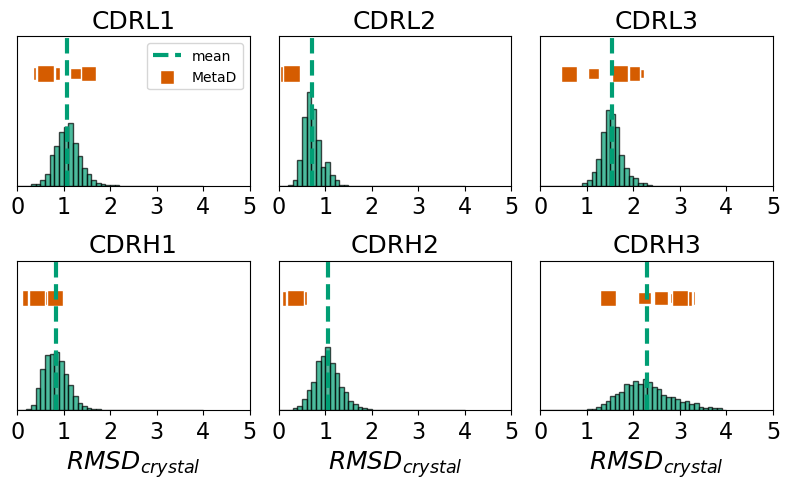

In [147]:
system_name='3V6F'

fig,(axs)=plt.subplots(2,3,figsize=(8,5))

axs=axs.flatten()

counts=axs[0].hist(Rref_cdr1_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[0].plot([np.mean(Rref_cdr1_light[2,:]),np.mean(Rref_cdr1_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='mean')
axs[0].scatter([Rref_cdr1_light_pdb],[[300 for i in Rref_cdr1_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00',label='MetaD')
axs[0].legend(fontsize=18)

axs[0].set_title('CDRL1',fontsize=18)

counts=axs[1].hist(Rref_cdr2_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[1].plot([np.mean(Rref_cdr2_light[2,:]),np.mean(Rref_cdr2_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[1].scatter([Rref_cdr2_light_pdb],[[300 for i in Rref_cdr2_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[1].set_title('CDRL2',fontsize=18)


counts=axs[2].hist(Rref_cdr3_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[2].plot([np.mean(Rref_cdr3_light[2,:]),np.mean(Rref_cdr3_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[2].scatter([Rref_cdr3_light_pdb],[[300 for i in Rref_cdr3_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[2].set_title('CDRL3',fontsize=18)


counts=axs[3].hist(Rref_cdr1_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[3].plot([np.mean(Rref_cdr1_heavy[2,:]),np.mean(Rref_cdr1_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[3].scatter([Rref_cdr1_heavy_pdb],[[300 for i in Rref_cdr1_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[3].set_title('CDRH1',fontsize=18)


counts=axs[4].hist(Rref_cdr2_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[4].plot([np.mean(Rref_cdr2_heavy[2,:]),np.mean(Rref_cdr2_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[4].scatter([Rref_cdr2_heavy_pdb],[[300 for i in Rref_cdr2_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[4].set_title('CDRH2',fontsize=18)


counts=axs[5].hist(Rref_cdr3_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[5].plot([np.mean(Rref_cdr3_heavy[2,:]),np.mean(Rref_cdr3_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[5].scatter([Rref_cdr3_heavy_pdb],[[300 for i in Rref_cdr3_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[5].set_title('CDRH3',fontsize=18)

for ax in axs:

    ax.set_xlim(0,5)
    ax.set_ylim(0,400)
    ax.set_xticks([0,1,2,3,4,5])
    ax.set_xticklabels([0,1,2,3,4,5],fontsize=16)
axs[3].set_xlabel(r'$RMSD_{crystal}$',fontsize=18)
axs[4].set_xlabel(r'$RMSD_{crystal}$',fontsize=18)
axs[5].set_xlabel(r'$RMSD_{crystal}$',fontsize=18)

axs[0].legend()

for ax in axs:
    ax.set_yticks([])
fig.tight_layout()
plt.savefig(f'../figures/{system_name}_restraints_rmsd_ref_cdrs.pdf')

In [148]:
data_cv3=[Rmean_cdr1_light[2,:],Rmean_cdr2_light[2,:],Rmean_cdr3_light[2,:],Rmean_cdr1_heavy[2,:],Rmean_cdr2_heavy[2,:],Rmean_cdr3_heavy[2,:]]
data_fa=[Rmean_cdr1_light_fa[2,15000:],Rmean_cdr2_light_fa[2,15000:],Rmean_cdr3_light_fa[2,15000:],Rmean_cdr1_heavy_fa[2,15000:],Rmean_cdr2_heavy_fa[2,15000:],Rmean_cdr3_heavy_fa[2,15000:]]
data_metad=[Rmean_cdr1_light_pdb,Rmean_cdr2_light_pdb,Rmean_cdr3_light_pdb,Rmean_cdr1_heavy_pdb,Rmean_cdr2_heavy_pdb,Rmean_cdr3_heavy_pdb]

0 0
0 1
0 2
1 0
1 1
1 2


/var/folders/8w/2dqxrgsd4vj00wv819dcz51w0000gn/T/ipykernel_44258/1371784255.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


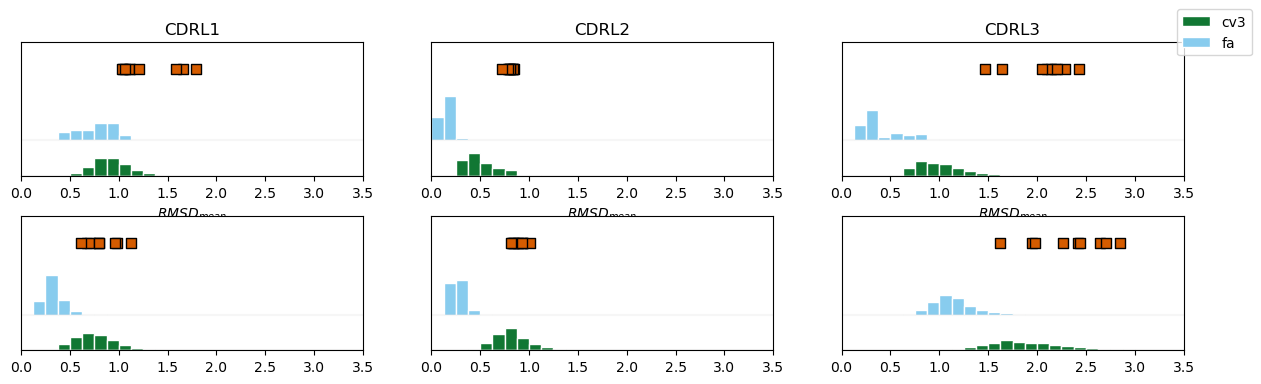

In [149]:
fig, axes = plt.subplots(2, 3, figsize=(15, 4),
                         gridspec_kw={'hspace': 0.3, 'wspace': 0.2})
colors = ['#117733','#88CCEE','#DDCC77','#CC6677','#AB6D52']  # One color per method

# Ensure axes is 2D
axes = np.atleast_2d(axes)

for row_idx, chain in enumerate(['L','H']):
    for col_idx, cdr in enumerate([1, 2, 3]):
        ax = axes[row_idx, col_idx]
        print(row_idx,col_idx)
        for method_idx, method in enumerate([data_cv3,data_fa,data_metad]):
            try:
                data = method[row_idx*3+col_idx]
                if method_idx !=2:
                    ax.hist(data, bins=40, range=[0, 5.0], facecolor=colors[method_idx], 
                            edgecolor='w', label='cv3' if method_idx == 0 else "fa",bottom=method_idx*4,density=True)
                    ax.plot([0,5],[method_idx*4,method_idx*4],color='lightgray',alpha=0.2)
                else:
                    ax.scatter([data],[[ (len(method)-2)*3 for i in data]],s=50, edgecolor='black',marker='s',color='#d55c00')
            except KeyError:
                continue

        ax.set_xlim(0, 3.5)
        ax.set_ylim([0,(len(method)-1)*3])
        ax.set_yticks([])
        if row_idx == len(pdb_list) - 1:
            ax.set_xlabel(r'$ RMSD_{mean}$')
            
        if row_idx == 0:
            ax.set_title(f"CDR{chain}{cdr}")
# Add a legend only once
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.95, 0.98))
plt.tight_layout()

#plt.savefig('../figures/7t0_comparison_crystal_multi_light.pdf')

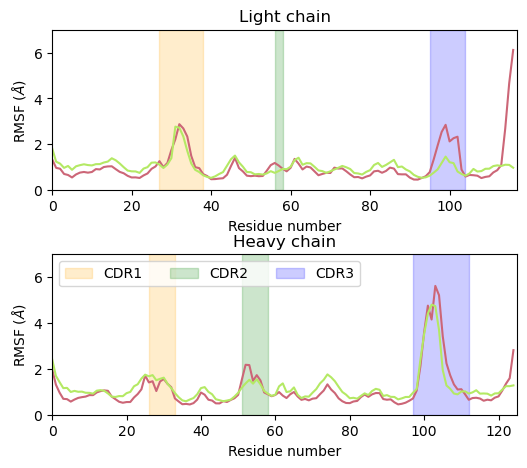

In [152]:
fig,(axs)=plt.subplots(2,1,figsize=(6,5),gridspec_kw={'hspace': 0.4})

axs[0].plot([i for i in range(len(res_light))],rmsf_sim_light,color='#CC6677')
axs[0].plot([i for i in range(len(res_light))],rmsf_fa_light[:117],color='#b4e964')

axs[0].set_xlabel('Residue number')
axs[0].set_ylabel('RMSF ($\AA$)')
axs[0].axvspan(cv3_cdrs_light_sim[0][0]-start_chain_light,cv3_cdrs_light_sim[0][1]-start_chain_light, zorder=0, alpha=0.2, color='orange', label='CDR1')
axs[0].axvspan(cv3_cdrs_light_sim[1][0]-start_chain_light,cv3_cdrs_light_sim[1][1]-start_chain_light, zorder=0, alpha=0.2, color='green', label='CDR2')
axs[0].axvspan(cv3_cdrs_light_sim[2][0]-start_chain_light,cv3_cdrs_light_sim[2][1]-start_chain_light, zorder=0, alpha=0.2, color='blue', label='CDR3')
axs[0].set_ylim(0,7)
axs[0].set_title('Light chain')
axs[0].set_xlim(0,len(res_light))


axs[1].plot([i for i in range(len(res_heavy))],rmsf_sim_heavy,color='#CC6677')
axs[1].plot([i for i in range(len(res_heavy))],rmsf_fa_heavy[:len(res_heavy)],color='#b4e964')

axs[1].set_xlabel('Residue number')
axs[1].set_ylabel('RMSF ($\AA$)')
axs[1].axvspan(cv3_cdrs_heavy_sim[0][0],cv3_cdrs_heavy_sim[0][1], zorder=0, alpha=0.2, color='orange', label='CDR1')
axs[1].axvspan(cv3_cdrs_heavy_sim[1][0],cv3_cdrs_heavy_sim[1][1], zorder=0, alpha=0.2, color='green', label='CDR2')
axs[1].axvspan(cv3_cdrs_heavy_sim[2][0],cv3_cdrs_heavy_sim[2][1], zorder=0, alpha=0.2, color='blue', label='CDR3')
axs[1].set_ylim(0,7)
axs[1].legend(ncol=3)
axs[1].set_title('Heavy chain')

axs[1].set_xlim(0,len(res_heavy))
plt.savefig(f'../figures/{system_name}_restraints_rmsf_all.pdf')
#print('RMSE light all chain:',rmse_light_all)
#print('RMSE heavy all chain:',rmse_heavy_all)

/var/folders/8w/2dqxrgsd4vj00wv819dcz51w0000gn/T/ipykernel_44258/3733390535.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


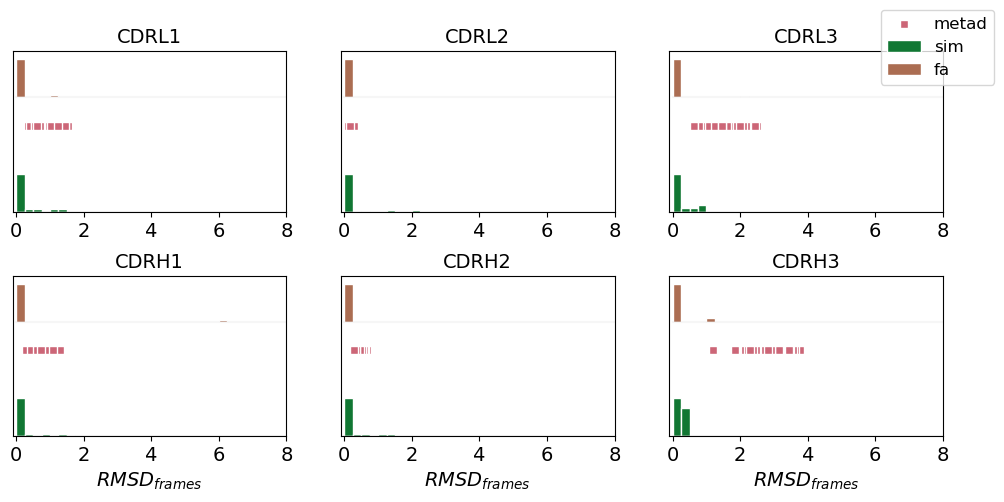

In [153]:
fig, axes = plt.subplots(2, 3, figsize=(12, 5), gridspec_kw={'hspace': 0.4, 'wspace': 0.2})
colors = ['#117733','#CC6677','#AB6D52','gray']  # One color per method
methods = list(rmsd_all_dist.keys())

# Ensure axes is 2D
axes = np.atleast_2d(axes)

for row_idx, chain in enumerate(['light','heavy']):
    for col_idx, cdr in enumerate([1, 2, 3]):
        ax = axes[row_idx, col_idx]

        for method_idx, method in enumerate(methods):
            try:
                data = rmsd_all_dist[method][chain][cdr-1]
                if method == 'pdbs':
                    y = [1.5*(len(methods)-1)] * len(data)
                    ax.scatter(data, y, facecolor=colors[method_idx], edgecolor='white',marker='s', 
                               label=method if row_idx == 0 else "")
                elif method == 'metad':
                    y = [1.5*(len(methods)-1.5)] * len(data)
                    ax.scatter(data, y, facecolor=colors[method_idx], edgecolor='white',marker='s', 
                               label=method if row_idx == 0 else "")
                else:

                    counts, bin_edges = np.histogram(data, bins=40, range=[0, 10.0])
                    pdf = counts / counts.max()
                    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
                    
                    # Plot
                    ax.bar(bin_centers, pdf, width=bin_edges[1] - bin_edges[0], 
                           color=colors[method_idx], edgecolor='w', 
                           label=method if row_idx == 0 else "", 
                           bottom=method_idx * 1.5)
                    ax.plot([0, 10], [method_idx * 1.5, method_idx * 1.5],  color='lightgray', alpha=0.2)
                    
            except KeyError:
                continue

        ax.set_xlim(-0.1, 8)
        ax.set_xticks([0,2,4,6,8])
        ax.set_xticklabels([0,2,4,6,8],fontsize=14)
        ax.set_yticks([])
        if row_idx == 1:
            ax.set_xlabel(r'$ RMSD_{frames}$',fontsize=14)
        
        ax.set_title(f"CDR{chain[0].upper()}{cdr}",fontsize=14)
# Add a legend only once
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.95, 0.98),fontsize=12)

plt.tight_layout()
plt.savefig(f'../figures/{system_name}_sim_metad_rmsd_matrix.pdf')

['sim', 'fa', 'metad']


/var/folders/8w/2dqxrgsd4vj00wv819dcz51w0000gn/T/ipykernel_44258/3199935506.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


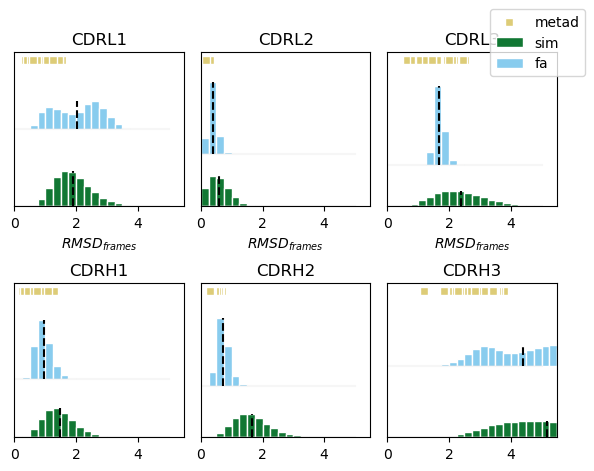

In [154]:
fig, axes = plt.subplots(2, 3, figsize=(7, 5),
                         gridspec_kw={'hspace': 0.5, 'wspace': 0.1})
colors = ['#117733','#88CCEE','#DDCC77','#CC6677','#AB6D52']  # One color per method
methods = ['sim', 'fa','metad'] 
print(methods)
# Ensure axes is 2D
axes = np.atleast_2d(axes)
for row_idx,chain_id in enumerate(['light','heavy']):
    for col_idx, cdr in enumerate([1, 2, 3]):
        ax = axes[row_idx, col_idx]
        bottom_meth=0
        for method_idx, method in enumerate(methods):
            try:
                data = rmsd_all_dist[method][chain_id][(cdr)-1]
                if method == 'metad':
                    y = [bottom_meth] * len(data)
                    ax.scatter(data, y, facecolor=colors[method_idx], edgecolor='white',marker='s', 
                               s=30., label=method if row_idx == 0 else "")
                    
                else:
                    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

                    data_sum = data.sum()
                    data_normalized = data / data_sum
                    
                    ax.bar(bin_centers, data_normalized, width=(bin_edges[1] - bin_edges[0]),color=colors[method_idx], edgecolor='w',
                           label=method if row_idx == 0 else "",bottom=bottom_meth)
                    mean = np.sum(bin_centers * data_normalized)
                    
                    ax.plot([0,5],[bottom_meth,bottom_meth],color='lightgray',alpha=0.2)
                    ax.plot([mean,mean],[bottom_meth,bottom_meth+np.max(data_normalized)],ls='--',color='k')
                    bottom_meth=bottom_meth+np.max(data_normalized)+0.2
                    
            except KeyError:
                pass
    
        ax.set_xlim(0, 5.5)
        ax.set_yticks([])
        if row_idx == len(pdb_list) - 1:
            ax.set_xlabel(r'$ RMSD_{frames}$')
        if row_idx == 0:
            ax.set_title(f"CDRL{cdr}")
        if row_idx == 1:
            ax.set_title(f"CDRH{cdr}")
# Add a legend only once
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.95, 0.98))
plt.tight_layout()

plt.savefig(f'../figures/{system_name}_sims_metad_rmsd_pairwise.pdf')

In [155]:
### comparison crystal:
with open('../src/aa_md/dist_from_fa/results_top_3v6f_.json','r') as f:
    distances_top_fa=json.load(f)

In [156]:
### comparison crystal:
with open('../src/aa_md/dist_from_fa/results_query_3v6f_.json','r') as f:
    distances_cv3_fa=json.load(f)

In [157]:
### comparison crystal:
with open('../src/aa_md/dist_from_fa/results_query_3v6f_metad.json','r') as f:
    distances_metad_fa=json.load(f)

In [158]:
rmsd_threshold=[0.05*i for i in range(100)]

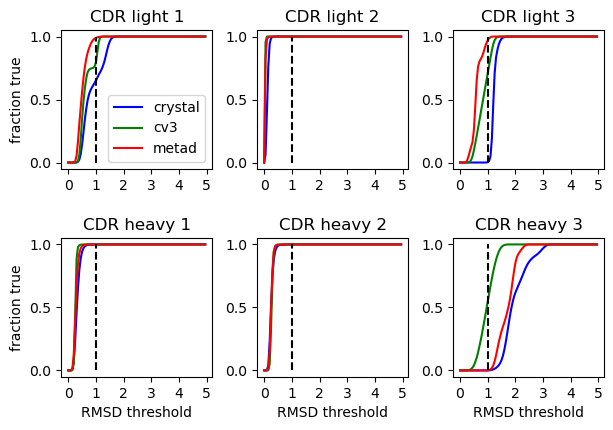

In [159]:
fig,axs = plt.subplots(2,3,figsize=(7,4.5),gridspec_kw={'hspace': 0.5, 'wspace': 0.3})
axs = np.atleast_2d(axs)
for row_idx,chain_id in enumerate(['light','heavy']):
    for col_idx, cdr in enumerate([1,2,3]):
        tp_top_thresh=[]
        tp_cv3_thresh=[]
        tp_metad_thresh=[]
        for rt in rmsd_threshold:
        
            tp_top_thresh.append(len(np.where(np.array(distances_top_fa['min'][chain_id][f'{cdr}'])< rt)[0])/len(np.array(distances_top_fa['min'][chain_id][f'{cdr}'])))
            tp_cv3_thresh.append(len(np.where(np.array(distances_cv3_fa['min'][chain_id][f'{cdr}'])< rt)[0])/len(np.array(distances_cv3_fa['min'][chain_id][f'{cdr}'])))
            tp_metad_thresh.append(len(np.where(np.array(distances_metad_fa['min'][chain_id][f'{cdr}'])< rt)[0])/len(np.array(distances_metad_fa['min'][chain_id][f'{cdr}'])))

        ax = axs[row_idx, col_idx]
        ax.plot(rmsd_threshold,tp_top_thresh,c='blue',label='crystal')
        ax.plot(rmsd_threshold,tp_cv3_thresh,c='green',label='cv3')
        ax.plot(rmsd_threshold,tp_metad_thresh,c='red',label='metad')
        ax.plot([1,1],[0,1],'k--')
        ax.set_xticks([0,1,2,3,4,5])
        ax.set_title(f'CDR {chain_id} {cdr}')
        
for ax in axs[:,0]:
    ax.set_ylabel('fraction true')
for ax in axs[-1,:]:
    ax.set_xlabel('RMSD threshold')

axs[0,0].legend()

plt.savefig(f'../figures/{system_name}_cv3_metad_crystal_tp_from_fa.pdf')

## 5I15 - unbound

#### load starting pdb

In [160]:
dict_cv2imgt='../src/sims_cv3fv/5i15_HL/5i15_dict_Fv_HL.txt'

pdb_start=os.path.abspath('../src/sims_cv3fv/5i15_HL/5i15_Fv_HL.pdb')

chain_list='HL'

In [161]:
chain_list

'HL'

In [162]:
os.listdir('../src/metaD_clusters/5I15_clusters/')

['cluster.CL-rep.c6.pdb',
 'cluster.CL-rep.c7.pdb',
 'cluster.CL-rep.c5.pdb',
 'cluster.CL-rep.c4.pdb',
 'cluster.CL-rep.c0.pdb',
 'cluster.CL-rep.c1.pdb',
 'cluster.CL-rep.c3.pdb',
 'cluster.CL-rep.c2.pdb']

In [163]:
n_cluster=len(os.listdir('../src/metaD_clusters/5I15_clusters/'))

In [164]:
dict_prob_cluster={'cluster.CL-rep.c0.pdb':0.9,'cluster.CL-rep.c1.pdb':0.8,'cluster.CL-rep.c2.pdb':0.7,'cluster.CL-rep.c3.pdb':0.6,'cluster.CL-rep.c4.pdb':0.5,
                  'cluster.CL-rep.c5.pdb':0.4,'cluster.CL-rep.c6.pdb':0.3,'cluster.CL-rep.c7.pdb':0.2}

In [165]:
cluster_pdb_list=os.listdir('../src/metaD_clusters/5I15_clusters/')
cluster_chain_list=['HL','HL','HL','HL','HL']
cluster_folder_pdbs='../src/metaD_clusters/5I15_clusters/'
cluster_pdb_prob=np.array([dict_prob_cluster[cluster] for cluster in cluster_pdb_list])

In [166]:
sys_name='5i15'
pdb_trajectories = [md.load(os.path.join('../src/metaD_clusters/5I15_clusters/',pdb_name)) for pdb_name in os.listdir('../src/metaD_clusters/5I15_clusters/')]

# Step 2: Concatenate all into a single trajectory
pdb_traj = md.join(pdb_trajectories)
pdb_traj.save_xtc(f"../src/metaD_clusters/imgt_traj_clusters/{sys_name}joined_pdbs.xtc")

pdb_traj = mda.Universe('../src/metaD_clusters/5I15_clusters/cluster.CL-rep.c0.pdb',f"../src/metaD_clusters/imgt_traj_clusters/{sys_name}joined_pdbs.xtc")


/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/XDR.py:240: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


In [167]:
rmsd_all_dist={}
rmsd_all_dist['sim']={'heavy':{},'light':{}}
rmsd_all_dist['metad']={'heavy':{},'light':{}}

In [168]:
chain_cluster=['H','L']
for chain_idx,chain_type in enumerate(['heavy','light']):
    for idx_cdr, cdr in enumerate(cdrs_list):
        rmsd_all_dist['metad'][chain_type][idx_cdr]=dist_trajs(pdb_traj,select=f'segid {chain_cluster[chain_idx]} and name CA and resid {cdr[0]-1}:{cdr[1]+1}')
        if len(rmsd_all_dist['metad'][chain_type][idx_cdr]) ==0:
            rmsd_all_dist['metad'][chain_type][idx_cdr]=np.array([0])

### load simulations

In [169]:
top_file = '../src/sims_cv3fv/5i15_HL/5i15_Fv_HL.pdb'  # Path to your PDB file
chain_sequences = extract_sequences_by_chain(top_file)

# Print sequences for each chain
for chain_id, sequence in chain_sequences.items():
    print(f"Chain {chain_id} {len(sequence)}: {sequence}")
    if chain_id == 'H':
        res_heavy=sequence
    if chain_id == 'L':
        res_light=sequence

Chain H 120: VQLVQSGAEVKKPGSSVKVSCKASGGTFSSYAISWVRQAPGQGLEWMGGIIPIFGTANYAQKFQGRVTITADESTSTAYMELSSLRSEDTAVYYCARYDGIYGELDFWGQGTLVTVSSAS
Chain L 110: DIQMTQSPSSLSASVGDRVTITCRASQSISSYLNWYQQKPGKAPKLLIYAASSLQSGVPSRFSGSGSGTDFTLTISSLQPEDFATYYCQQSYSTPLTFGQGTKVEIKRTV


In [170]:
topology_fa = "../src/sims_cv3fv/5i15_HL/5i15_Fv_HL_top.pdb"

top_pdb=mda.Universe(topology_fa,topology_fa)

dict_imgt2cv='../src/sims_cv3fv/5i15_HL/5i15_dict_Fv_HL.txt'

In [171]:
prefix_sim=os.path.abspath('../src/sims_cv3fv/5i15_HL/5i15_Fv_HL')
topology_fa= os.path.join(prefix_sim+"_top.pdb")
xtc_file = os.path.join(prefix_sim+"_aligned.xtc")

mobile = mda.Universe(topology_fa,xtc_file)
ref = mda.Universe(topology_fa,xtc_file)

mobile.trajectory  # set mobile trajectory to last frame
ref.trajectory[0]  # set reference trajectory to first frame
##dict_loc,chain,cdr_boundaries
cv3_cdrs_light_sim=[extract_cdr_coord(dict_imgt2cv,sel_chain[1],cdrs_list[0]),extract_cdr_coord(dict_imgt2cv,sel_chain[1],cdrs_list[1]),extract_cdr_coord(dict_imgt2cv,sel_chain[1],cdrs_list[2])]
cv3_cdrs_heavy_sim=[extract_cdr_coord(dict_imgt2cv,sel_chain[0],cdrs_list[0]),extract_cdr_coord(dict_imgt2cv,sel_chain[0],cdrs_list[1]),extract_cdr_coord(dict_imgt2cv,sel_chain[0],cdrs_list[2])]

In [172]:
Rref_cdr1_light,Rmean_cdr1_light=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_light_sim[0][0]}:{cv3_cdrs_light_sim[0][1]}')
Rref_cdr2_light,Rmean_cdr2_light=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_light_sim[1][0]}:{cv3_cdrs_light_sim[1][1]}')
Rref_cdr3_light,Rmean_cdr3_light=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_light_sim[2][0]}:{cv3_cdrs_light_sim[2][1]}')

Rref_cdr1_heavy,Rmean_cdr1_heavy=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_heavy_sim[0][0]}:{cv3_cdrs_heavy_sim[0][1]}')
Rref_cdr2_heavy,Rmean_cdr2_heavy=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_heavy_sim[1][0]}:{cv3_cdrs_heavy_sim[1][1]}')
Rref_cdr3_heavy,Rmean_cdr3_heavy=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_heavy_sim[2][0]}:{cv3_cdrs_heavy_sim[2][1]}')


/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/memory.py:535: DeprecationWarning: asel argument to timeseries will be renamed to'atomgroup' in 3.0, see #3911
  warnings.warn(


done
done
done
done
done
done


In [173]:
trajectory = md.load(xtc_file
, top=topology_fa)  # Adjust file names/paths as needed

# Light chain
atom_indices = trajectory.topology.select('name CA and chainid 0')
# Restrict the trajectory to the selected atoms
sub_traj = trajectory.atom_slice(atom_indices)
sub_traj.center_coordinates()
rmsf_sim = md.rmsf(sub_traj, sub_traj, 0, precentered=True) *10
rmsd_sim = md.rmsd(sub_traj, sub_traj, 0, precentered=True) *10

rmsf_sim_heavy=rmsf_sim[:len(res_heavy)]
rmsf_sim_light=rmsf_sim[-(len(res_light)):]

In [174]:
# Light chain
atom_indices = trajectory.topology.select(f'name CA and resid >= {cv3_cdrs_light_sim[2][0]} and resid <= {cv3_cdrs_light_sim[2][1]}')
# Restrict the trajectory to the selected atoms
sub_traj_CDRL3_sim = trajectory.atom_slice(atom_indices)
sub_traj_CDRL3_sim.center_coordinates()

# Light chain
atom_indices = trajectory.topology.select(f'name CA and resid >= {cv3_cdrs_heavy_sim[2][0]} and resid <= {cv3_cdrs_heavy_sim[2][1]}')
# Restrict the trajectory to the selected atoms
sub_traj_CDRH3_sim = trajectory.atom_slice(atom_indices)
sub_traj_CDRH3_sim.center_coordinates()

<mdtraj.Trajectory with 1010 frames, 12 atoms, 12 residues, and unitcells at 0x3d938b6a0>

In [175]:
rmsf_cdr1_light_sim=rmsf_sim[(cv3_cdrs_light_sim[0][0]-1):(cv3_cdrs_light_sim[0][1])]
rmsf_cdr2_light_sim=rmsf_sim[(cv3_cdrs_light_sim[1][0]-1):(cv3_cdrs_light_sim[1][1])]
rmsf_cdr3_light_sim=rmsf_sim[(cv3_cdrs_light_sim[2][0]-1):(cv3_cdrs_light_sim[2][1])]

rmsf_cdr1_heavy_sim=rmsf_sim[(cv3_cdrs_heavy_sim[0][0]-1):(cv3_cdrs_heavy_sim[0][1])]
rmsf_cdr2_heavy_sim=rmsf_sim[(cv3_cdrs_heavy_sim[1][0]-1):(cv3_cdrs_heavy_sim[1][1])]
rmsf_cdr3_heavy_sim=rmsf_sim[(cv3_cdrs_heavy_sim[2][0]-1):(cv3_cdrs_heavy_sim[2][1])]

#### rmsd pdbs

In [176]:
Rmean_cdr1_light_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[0][0]-1}:{cv3_cdrs_light_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', chain_list[1])
Rmean_cdr2_light_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[1][0]-1}:{cv3_cdrs_light_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', chain_list[1])
Rmean_cdr3_light_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[2][0]-1}:{cv3_cdrs_light_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', chain_list[1])

Rmean_cdr1_heavy_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[0][0]-1}:{cv3_cdrs_heavy_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', chain_list[0])
Rmean_cdr2_heavy_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[1][0]-1}:{cv3_cdrs_heavy_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', chain_list[0])
Rmean_cdr3_heavy_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[2][0]-1}:{cv3_cdrs_heavy_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', chain_list[0])

/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:777: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


In [177]:
Rref_cdr1_light_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_light_sim[0][0]-1}:{cv3_cdrs_light_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', chain_list[1])
Rref_cdr2_light_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_light_sim[1][0]-1}:{cv3_cdrs_light_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', chain_list[1])
Rref_cdr3_light_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_light_sim[2][0]-1}:{cv3_cdrs_light_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', chain_list[1])

Rref_cdr1_heavy_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_heavy_sim[0][0]-1}:{cv3_cdrs_heavy_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', chain_list[0])
Rref_cdr2_heavy_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_heavy_sim[1][0]-1}:{cv3_cdrs_heavy_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', chain_list[0])
Rref_cdr3_heavy_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_heavy_sim[2][0]-1}:{cv3_cdrs_heavy_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', chain_list[0])

/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/base.py:725: UserWarning: Reader has no dt information, set to 1.0 ps
  return self.ts.dt


In [178]:
Rmetad_cdr1_light_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[0][0]-1}:{cv3_cdrs_light_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', 'L')
Rmetad_cdr2_light_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[1][0]-1}:{cv3_cdrs_light_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', 'L')
Rmetad_cdr3_light_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[2][0]-1}:{cv3_cdrs_light_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', 'L')

Rmetad_cdr1_heavy_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[0][0]-1}:{cv3_cdrs_heavy_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', 'H')
Rmetad_cdr2_heavy_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[1][0]-1}:{cv3_cdrs_heavy_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', 'H')
Rmetad_cdr3_heavy_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[2][0]-1}:{cv3_cdrs_heavy_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', 'H')

1018
1018
1018
1018
1018
1018


In [179]:
chain_sim=['P000','P001']
cdr_sim=[cv3_cdrs_heavy_sim,cv3_cdrs_light_sim]
for chain_idx,chain_type in enumerate(['heavy','light']):
    for idx_cdr, cdr in enumerate(cdrs_list):
        rmsd_all_dist['sim'][chain_type][idx_cdr]=dist_trajs(mobile,select=f'segid {chain_sim[chain_idx]} and name CA and resid {cdr_sim[chain_idx][chain_idx][0]-1}:{cdr_sim[chain_idx][idx_cdr][1]+1}').flatten()

### plots

In [180]:
size_clusters=np.array([50 for cluster_file in reversed(os.listdir('../src/metaD_clusters/5I15_clusters/'))])

In [181]:
start_chain_light=len(res_heavy)

In [182]:
cluster_dot_size=[]
for cluster in os.listdir('../src/metaD_clusters/5I15_clusters/'):
    cluster_dot_size.append(dict_prob_cluster[cluster])
cluster_dot_size=np.array(cluster_dot_size)

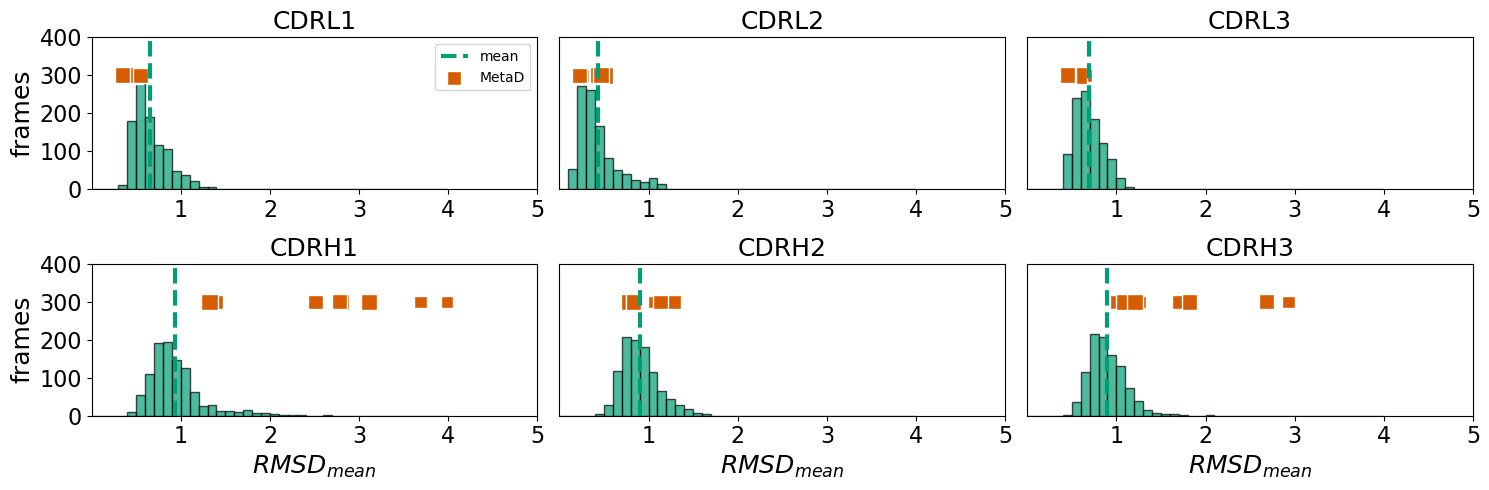

In [183]:
system_name='5I15'

fig,(axs)=plt.subplots(2,3,figsize=(15,5))

axs=axs.flatten()

counts=axs[0].hist(Rmean_cdr1_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[0].plot([np.mean(Rmean_cdr1_light[2,:]),np.mean(Rmean_cdr1_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='mean')
axs[0].scatter([Rmean_cdr1_light_pdb],[[300 for i in Rmean_cdr1_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00',label='MetaD')
axs[0].legend()

axs[0].set_title('CDRL1',fontsize=18)

counts=axs[1].hist(Rmean_cdr2_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[1].plot([np.mean(Rmean_cdr2_light[2,:]),np.mean(Rmean_cdr2_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[1].scatter([Rmean_cdr2_light_pdb],[[300 for i in Rmean_cdr2_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[1].set_title('CDRL2',fontsize=18)


counts=axs[2].hist(Rmean_cdr3_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[2].plot([np.mean(Rmean_cdr3_light[2,:]),np.mean(Rmean_cdr3_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[2].scatter([Rmean_cdr3_light_pdb],[[300 for i in Rmean_cdr3_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[2].set_title('CDRL3',fontsize=18)


counts=axs[3].hist(Rmean_cdr1_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[3].plot([np.mean(Rmean_cdr1_heavy[2,:]),np.mean(Rmean_cdr1_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[3].scatter([Rmean_cdr1_heavy_pdb],[[300 for i in Rmean_cdr1_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[3].set_title('CDRH1',fontsize=18)


counts=axs[4].hist(Rmean_cdr2_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[4].plot([np.mean(Rmean_cdr2_heavy[2,:]),np.mean(Rmean_cdr2_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[4].scatter([Rmean_cdr2_heavy_pdb],[[300 for i in Rmean_cdr2_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[4].set_title('CDRH2',fontsize=18)


counts=axs[5].hist(Rmean_cdr3_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[5].plot([np.mean(Rmean_cdr3_heavy[2,:]),np.mean(Rmean_cdr3_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[5].scatter([Rmean_cdr3_heavy_pdb],[[300 for i in Rmean_cdr3_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[5].set_title('CDRH3',fontsize=18)

for ax in axs:

    ax.set_xlim(0,5)
    ax.set_ylim(0,400)
    ax.set_yticks([0,100,200,300,400])
    ax.set_yticklabels([0,100,200,300,400],fontsize=16)
    ax.set_xticks([1,2,3,4,5])
    ax.set_xticklabels([1,2,3,4,5],fontsize=16)
axs[3].set_xlabel(r'$RMSD_{mean}$',fontsize=18)
axs[4].set_xlabel(r'$RMSD_{mean}$',fontsize=18)
axs[5].set_xlabel(r'$RMSD_{mean}$',fontsize=18)

axs[0].set_ylabel('frames',fontsize=18)
axs[3].set_ylabel('frames',fontsize=18)
axs[0].legend()

for ax in [axs[1],axs[2],axs[4],axs[5]]:
    ax.set_yticks([])


fig.tight_layout()
plt.savefig(f'../figures/{system_name}_restraints_rmsd_all_cdrs.pdf')

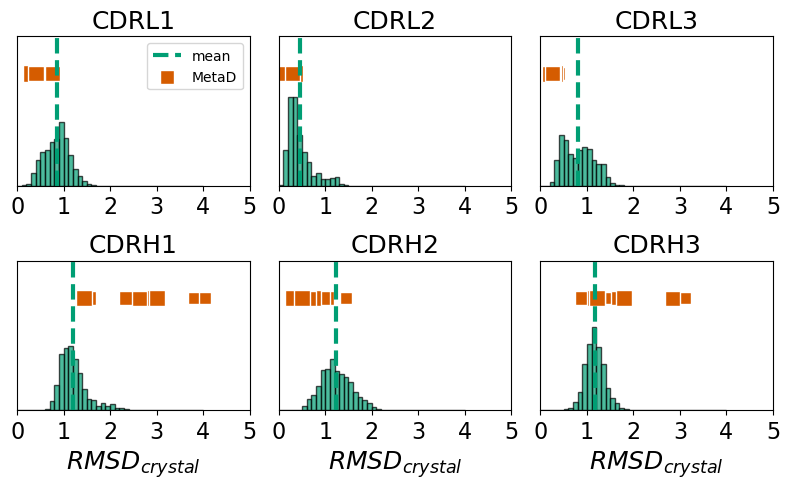

In [184]:
system_name='5I15'

fig,(axs)=plt.subplots(2,3,figsize=(8,5))

axs=axs.flatten()

counts=axs[0].hist(Rref_cdr1_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[0].plot([np.mean(Rref_cdr1_light[2,:]),np.mean(Rref_cdr1_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='mean')
axs[0].scatter([Rref_cdr1_light_pdb],[[300 for i in Rref_cdr1_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00',label='MetaD')
axs[0].legend(fontsize=18)

axs[0].set_title('CDRL1',fontsize=18)

counts=axs[1].hist(Rref_cdr2_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[1].plot([np.mean(Rref_cdr2_light[2,:]),np.mean(Rref_cdr2_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[1].scatter([Rref_cdr2_light_pdb],[[300 for i in Rref_cdr2_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[1].set_title('CDRL2',fontsize=18)


counts=axs[2].hist(Rref_cdr3_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[2].plot([np.mean(Rref_cdr3_light[2,:]),np.mean(Rref_cdr3_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[2].scatter([Rref_cdr3_light_pdb],[[300 for i in Rref_cdr3_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[2].set_title('CDRL3',fontsize=18)


counts=axs[3].hist(Rref_cdr1_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[3].plot([np.mean(Rref_cdr1_heavy[2,:]),np.mean(Rref_cdr1_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[3].scatter([Rref_cdr1_heavy_pdb],[[300 for i in Rref_cdr1_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[3].set_title('CDRH1',fontsize=18)


counts=axs[4].hist(Rref_cdr2_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[4].plot([np.mean(Rref_cdr2_heavy[2,:]),np.mean(Rref_cdr2_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[4].scatter([Rref_cdr2_heavy_pdb],[[300 for i in Rref_cdr2_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[4].set_title('CDRH2',fontsize=18)


counts=axs[5].hist(Rref_cdr3_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[5].plot([np.mean(Rref_cdr3_heavy[2,:]),np.mean(Rref_cdr3_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[5].scatter([Rref_cdr3_heavy_pdb],[[300 for i in Rref_cdr3_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[5].set_title('CDRH3',fontsize=18)

for ax in axs:

    ax.set_xlim(0,5)
    ax.set_ylim(0,400)
    ax.set_xticks([0,1,2,3,4,5])
    ax.set_xticklabels([0,1,2,3,4,5],fontsize=16)
axs[3].set_xlabel(r'$RMSD_{crystal}$',fontsize=18)
axs[4].set_xlabel(r'$RMSD_{crystal}$',fontsize=18)
axs[5].set_xlabel(r'$RMSD_{crystal}$',fontsize=18)

axs[0].legend()

for ax in axs:
    ax.set_yticks([])
fig.tight_layout()
plt.savefig(f'../figures/{system_name}_restraints_rmsd_ref_cdrs.pdf')

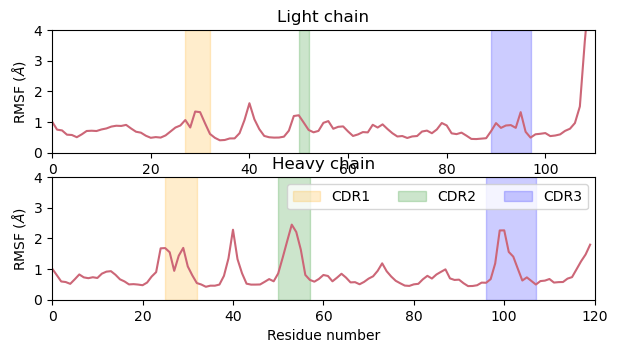

In [185]:
fig,(axs)=plt.subplots(2,1,figsize=(7,3.5))

axs[0].plot([i for i in range(len(res_light))],rmsf_sim_light,color='#CC6677')

axs[0].set_xlabel('Residue number')
axs[0].set_ylabel('RMSF ($\AA$)')
axs[0].axvspan(cv3_cdrs_light_sim[0][0]-start_chain_light,cv3_cdrs_light_sim[0][1]-start_chain_light, zorder=0, alpha=0.2, color='orange', label='CDR1')
axs[0].axvspan(cv3_cdrs_light_sim[1][0]-start_chain_light,cv3_cdrs_light_sim[1][1]-start_chain_light, zorder=0, alpha=0.2, color='green', label='CDR2')
axs[0].axvspan(cv3_cdrs_light_sim[2][0]-start_chain_light,cv3_cdrs_light_sim[2][1]-start_chain_light, zorder=0, alpha=0.2, color='blue', label='CDR3')
axs[0].set_ylim(0,4)
axs[0].set_xlim(0,len(res_light))


axs[1].plot([i for i in range(len(res_heavy))],rmsf_sim_heavy, color='#CC6677')

axs[1].set_xlabel('Residue number')
axs[1].set_ylabel('RMSF ($\AA$)')
axs[1].axvspan(cv3_cdrs_heavy_sim[0][0],cv3_cdrs_heavy_sim[0][1], zorder=0, alpha=0.2, color='orange', label='CDR1')
axs[1].axvspan(cv3_cdrs_heavy_sim[1][0],cv3_cdrs_heavy_sim[1][1], zorder=0, alpha=0.2, color='green', label='CDR2')
axs[1].axvspan(cv3_cdrs_heavy_sim[2][0],cv3_cdrs_heavy_sim[2][1], zorder=0, alpha=0.2, color='blue', label='CDR3')
axs[1].set_ylim(0,4)
axs[1].legend(ncol=3)
axs[1].set_xlim(0,len(res_heavy))

axs[1].set_title('Heavy chain')
axs[0].set_title('Light chain')

plt.savefig(f'../figures/{system_name}_restraints_rmsf_all.pdf')


/var/folders/8w/2dqxrgsd4vj00wv819dcz51w0000gn/T/ipykernel_44258/2441655020.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


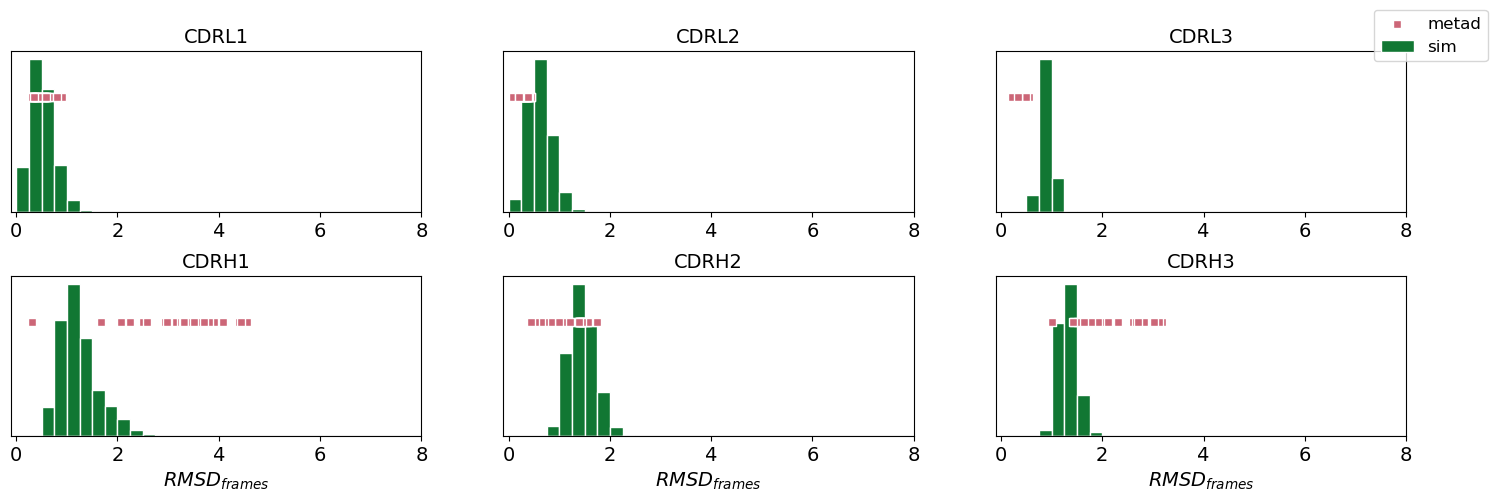

In [186]:
fig, axes = plt.subplots(2, 3, figsize=(18, 5), gridspec_kw={'hspace': 0.4, 'wspace': 0.2})
colors = ['#117733','#CC6677','#AB6D52','gray']  # One color per method
methods = list(rmsd_all_dist.keys())

# Ensure axes is 2D
axes = np.atleast_2d(axes)

for row_idx, chain in enumerate(['light','heavy']):
    for col_idx, cdr in enumerate([1, 2, 3]):
        ax = axes[row_idx, col_idx]

        for method_idx, method in enumerate(methods):
            try:
                data = rmsd_all_dist[method][chain][cdr-1]
                if method == 'pdbs':
                    y = [1.5*(len(methods)-1)] * len(data)
                    ax.scatter(data, y, facecolor=colors[method_idx], edgecolor='white',marker='s', 
                               label=method if row_idx == 0 else "")
                elif method == 'metad':
                    y = [1.5*(len(methods)-1.5)] * len(data)
                    ax.scatter(data, y, facecolor=colors[method_idx], edgecolor='white',marker='s', 
                               label=method if row_idx == 0 else "")
                else:

                    counts, bin_edges = np.histogram(data, bins=40, range=[0, 10.0])
                    pdf = counts / counts.max()
                    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
                    
                    # Plot
                    ax.bar(bin_centers, pdf, width=bin_edges[1] - bin_edges[0], 
                           color=colors[method_idx], edgecolor='w', 
                           label=method if row_idx == 0 else "", 
                           bottom=method_idx * 1.5)
                    ax.plot([0, 10], [method_idx * 1.5, method_idx * 1.5],  color='lightgray', alpha=0.2)
                    
            except KeyError:
                continue

        ax.set_xlim(-0.1, 8)
        ax.set_xticks([0,2,4,6,8])
        ax.set_xticklabels([0,2,4,6,8],fontsize=14)
        ax.set_yticks([])
        if row_idx == 1:
            ax.set_xlabel(r'$ RMSD_{frames}$',fontsize=14)
        
        ax.set_title(f"CDR{chain[0].upper()}{cdr}",fontsize=14)
# Add a legend only once
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.95, 0.98),fontsize=12)

plt.tight_layout()
plt.savefig(f'../figures/{system_name}_sim_metad_rmsd_matrix.pdf')

## 5I18 - unbound

#### load starting pdb

In [187]:
dict_cv2imgt='../src/sims_cv3fv/5i18_HL/5i18_dict_Fv_HL.txt'

pdb_start=os.path.abspath('../src/sims_cv3fv/5i18_HL/5i18_Fv_HL.pdb')

chain_list='HL'

In [188]:
chain_list

'HL'

In [189]:
os.listdir('../src/metaD_clusters/5I18_clusters/')

['cluster_8.pdb',
 'cluster_9.pdb',
 'cluster_4.pdb',
 'cluster_5.pdb',
 'cluster_7.pdb',
 'cluster_6.pdb',
 'cluster_2.pdb',
 'cluster_3.pdb',
 'cluster_1.pdb',
 'cluster_0.pdb',
 'cluster_10.pdb']

In [190]:
n_cluster=len(os.listdir('../src/metaD_clusters/5I18_clusters/'))

In [191]:
dict_prob_cluster={'cluster_0.pdb':0.9,'cluster_1.pdb':0.8,'cluster_2.pdb':0.7,'cluster_3.pdb':0.6,'cluster_4.pdb':0.5,'cluster_5.pdb':0.4,
                  'cluster_6.pdb':0.3,'cluster_7.pdb':0.2,'cluster_8.pdb':0.1,'cluster_9.pdb':0.05,'cluster_10.pdb':0.01}

In [192]:
cluster_pdb_list=os.listdir('../src/metaD_clusters/5I18_clusters/')
cluster_chain_list=['HL','HL','HL','HL','HL']
cluster_folder_pdbs='../src/metaD_clusters/5I18_clusters/'
cluster_pdb_prob=np.array([dict_prob_cluster[cluster] for cluster in cluster_pdb_list])

In [193]:
sys_name='5i18'
pdb_trajectories = [md.load(os.path.join('../src/metaD_clusters/5I18_clusters/',pdb_name)) for pdb_name in os.listdir('../src/metaD_clusters/5I18_clusters/')]

# Step 2: Concatenate all into a single trajectory
pdb_traj = md.join(pdb_trajectories)
pdb_traj.save_xtc(f"../src/metaD_clusters/imgt_traj_clusters/{sys_name}joined_pdbs.xtc")

pdb_traj = mda.Universe('../src/metaD_clusters/5I18_clusters/cluster_0.pdb',f"../src/metaD_clusters/imgt_traj_clusters/{sys_name}joined_pdbs.xtc")


/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/XDR.py:240: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


In [194]:
rmsd_all_dist={}
rmsd_all_dist['sim']={'heavy':{},'light':{}}
rmsd_all_dist['metad']={'heavy':{},'light':{}}

In [195]:
chain_cluster=['H','L']
for chain_idx,chain_type in enumerate(['heavy','light']):
    for idx_cdr, cdr in enumerate(cdrs_list):
        rmsd_all_dist['metad'][chain_type][idx_cdr]=dist_trajs(pdb_traj,select=f'segid {chain_cluster[chain_idx]} and name CA and resid {cdr[0]-1}:{cdr[1]+1}')
        if len(rmsd_all_dist['metad'][chain_type][idx_cdr]) ==0:
            rmsd_all_dist['metad'][chain_type][idx_cdr]=np.array([0])

### load simulations

In [196]:
top_file = '../src/sims_cv3fv/5i18_HL/5i18_Fv_HL.pdb'  # Path to your PDB file
chain_sequences = extract_sequences_by_chain(top_file)

# Print sequences for each chain
for chain_id, sequence in chain_sequences.items():
    print(f"Chain {chain_id} {len(sequence)}: {sequence}")
    if chain_id == 'H':
        res_heavy=sequence
    if chain_id == 'L':
        res_light=sequence

Chain H 120: VQLVQSGAEVKKPGSSVKVSCKASGGTFSSYAISWVRQAPGQGLEWMGGIIPIFGTANYAQKFQGRVTITADESTSTAYMELSSLRSEDTAVYYCARYDGIYGELDFWGQGTLVTVSSAS
Chain L 116: DIVMTQSPDSLAVSLGERATINCKSSQSVLYSSNNKNYLAWYQQKPGQPPKLLIYWASTRESGVPDRFSGSGSGTDFTLTISSLQAEDVAVYYCQQYYSTPLTFGQGTKVEIKRTV


In [197]:
sel_pdb='3g6d_Fv_HL.pdb'
sel_chain='HL'
topology_fa = "../src/sims_cv3fv/5i18_HL/5i18_Fv_HL_top.pdb"

top_pdb=mda.Universe(topology_fa,topology_fa)

dict_imgt2cv='../src/sims_cv3fv/5i18_HL/5i18_dict_Fv_HL.txt'

In [198]:
prefix_sim=os.path.abspath('../src/sims_cv3fv/5i18_HL/5i18_Fv_HL')
topology_fa= os.path.join(prefix_sim+"_top.pdb")
xtc_file = os.path.join(prefix_sim+"_aligned.xtc")

mobile = mda.Universe(topology_fa,xtc_file)
ref = mda.Universe(topology_fa,xtc_file)

mobile.trajectory  # set mobile trajectory to last frame
ref.trajectory[0]  # set reference trajectory to first frame

##dict_loc,chain,cdr_boundaries
cv3_cdrs_light_sim=[extract_cdr_coord(dict_imgt2cv,sel_chain[1],cdrs_list[0]),extract_cdr_coord(dict_imgt2cv,sel_chain[1],cdrs_list[1]),extract_cdr_coord(dict_imgt2cv,sel_chain[1],cdrs_list[2])]
cv3_cdrs_heavy_sim=[extract_cdr_coord(dict_imgt2cv,sel_chain[0],cdrs_list[0]),extract_cdr_coord(dict_imgt2cv,sel_chain[0],cdrs_list[1]),extract_cdr_coord(dict_imgt2cv,sel_chain[0],cdrs_list[2])]

In [199]:
Rref_cdr1_light,Rmean_cdr1_light=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_light_sim[0][0]}:{cv3_cdrs_light_sim[0][1]}')
Rref_cdr2_light,Rmean_cdr2_light=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_light_sim[1][0]}:{cv3_cdrs_light_sim[1][1]}')
Rref_cdr3_light,Rmean_cdr3_light=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_light_sim[2][0]}:{cv3_cdrs_light_sim[2][1]}')

Rref_cdr1_heavy,Rmean_cdr1_heavy=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_heavy_sim[0][0]}:{cv3_cdrs_heavy_sim[0][1]}')
Rref_cdr2_heavy,Rmean_cdr2_heavy=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_heavy_sim[1][0]}:{cv3_cdrs_heavy_sim[1][1]}')
Rref_cdr3_heavy,Rmean_cdr3_heavy=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_heavy_sim[2][0]}:{cv3_cdrs_heavy_sim[2][1]}')


/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/memory.py:535: DeprecationWarning: asel argument to timeseries will be renamed to'atomgroup' in 3.0, see #3911
  warnings.warn(


done
done
done
done
done
done


In [200]:
trajectory = md.load(xtc_file
, top=topology_fa)  # Adjust file names/paths as needed

# Light chain
atom_indices = trajectory.topology.select('name CA and chainid 0')
# Restrict the trajectory to the selected atoms
sub_traj = trajectory.atom_slice(atom_indices)
sub_traj.center_coordinates()
rmsf_sim = md.rmsf(sub_traj, sub_traj, 0, precentered=True) *10
rmsd_sim = md.rmsd(sub_traj, sub_traj, 0, precentered=True) *10

rmsf_sim_heavy=rmsf_sim[:len(res_heavy)]
rmsf_sim_light=rmsf_sim[-(len(res_light)):]

In [201]:
# Light chain
atom_indices = trajectory.topology.select(f'name CA and resid >= {cv3_cdrs_light_sim[2][0]} and resid <= {cv3_cdrs_light_sim[2][1]}')
# Restrict the trajectory to the selected atoms
sub_traj_CDRL3_sim = trajectory.atom_slice(atom_indices)
sub_traj_CDRL3_sim.center_coordinates()

# Light chain
atom_indices = trajectory.topology.select(f'name CA and resid >= {cv3_cdrs_heavy_sim[2][0]} and resid <= {cv3_cdrs_heavy_sim[2][1]}')
# Restrict the trajectory to the selected atoms
sub_traj_CDRH3_sim = trajectory.atom_slice(atom_indices)
sub_traj_CDRH3_sim.center_coordinates()

<mdtraj.Trajectory with 1010 frames, 12 atoms, 12 residues, and unitcells at 0x3d965abc0>

In [202]:
rmsf_cdr1_light_sim=rmsf_sim[(cv3_cdrs_light_sim[0][0]-1):(cv3_cdrs_light_sim[0][1])]
rmsf_cdr2_light_sim=rmsf_sim[(cv3_cdrs_light_sim[1][0]-1):(cv3_cdrs_light_sim[1][1])]
rmsf_cdr3_light_sim=rmsf_sim[(cv3_cdrs_light_sim[2][0]-1):(cv3_cdrs_light_sim[2][1])]

rmsf_cdr1_heavy_sim=rmsf_sim[(cv3_cdrs_heavy_sim[0][0]-1):(cv3_cdrs_heavy_sim[0][1])]
rmsf_cdr2_heavy_sim=rmsf_sim[(cv3_cdrs_heavy_sim[1][0]-1):(cv3_cdrs_heavy_sim[1][1])]
rmsf_cdr3_heavy_sim=rmsf_sim[(cv3_cdrs_heavy_sim[2][0]-1):(cv3_cdrs_heavy_sim[2][1])]

#### rmsd pdbs

In [203]:
Rmean_cdr1_light_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[0][0]-1}:{cv3_cdrs_light_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', chain_list[1])
Rmean_cdr2_light_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[1][0]-1}:{cv3_cdrs_light_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', chain_list[1])
Rmean_cdr3_light_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[2][0]-1}:{cv3_cdrs_light_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', chain_list[1])

Rmean_cdr1_heavy_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[0][0]-1}:{cv3_cdrs_heavy_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', chain_list[0])
Rmean_cdr2_heavy_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[1][0]-1}:{cv3_cdrs_heavy_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', chain_list[0])
Rmean_cdr3_heavy_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[2][0]-1}:{cv3_cdrs_heavy_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', chain_list[0])

/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:777: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


In [204]:
Rref_cdr1_light_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_light_sim[0][0]-1}:{cv3_cdrs_light_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', chain_list[1])
Rref_cdr2_light_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_light_sim[1][0]-1}:{cv3_cdrs_light_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', chain_list[1])
Rref_cdr3_light_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_light_sim[2][0]-1}:{cv3_cdrs_light_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', chain_list[1])

Rref_cdr1_heavy_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_heavy_sim[0][0]-1}:{cv3_cdrs_heavy_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', chain_list[0])
Rref_cdr2_heavy_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_heavy_sim[1][0]-1}:{cv3_cdrs_heavy_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', chain_list[0])
Rref_cdr3_heavy_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_heavy_sim[2][0]-1}:{cv3_cdrs_heavy_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', chain_list[0])

/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/base.py:725: UserWarning: Reader has no dt information, set to 1.0 ps
  return self.ts.dt


In [205]:
Rmetad_cdr1_light_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[0][0]-1}:{cv3_cdrs_light_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', 'L')
Rmetad_cdr2_light_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[1][0]-1}:{cv3_cdrs_light_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', 'L')
Rmetad_cdr3_light_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[2][0]-1}:{cv3_cdrs_light_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', 'L')

Rmetad_cdr1_heavy_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[0][0]-1}:{cv3_cdrs_heavy_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', 'H')
Rmetad_cdr2_heavy_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[1][0]-1}:{cv3_cdrs_heavy_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', 'H')
Rmetad_cdr3_heavy_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[2][0]-1}:{cv3_cdrs_heavy_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', 'H')

1021
1021
1021
1021
1021
1021


In [206]:
chain_sim=['P000','P001']
cdr_sim=[cv3_cdrs_heavy_sim,cv3_cdrs_light_sim]
for chain_idx,chain_type in enumerate(['heavy','light']):
    for idx_cdr, cdr in enumerate(cdrs_list):
        rmsd_all_dist['sim'][chain_type][idx_cdr]=dist_trajs(mobile,select=f'segid {chain_sim[chain_idx]} and name CA and resid {cdr_sim[chain_idx][chain_idx][0]-1}:{cdr_sim[chain_idx][idx_cdr][1]+1}').flatten()

### plots

In [207]:
size_clusters=np.array([50 for cluster_file in reversed(os.listdir('../src/metaD_clusters/5I18_clusters/'))])

In [208]:
start_chain_light=len(res_heavy)

In [209]:
cluster_dot_size=[]
for cluster in os.listdir('../src/metaD_clusters/5I18_clusters/'):
    cluster_dot_size.append(dict_prob_cluster[cluster])
cluster_dot_size=np.array(cluster_dot_size)

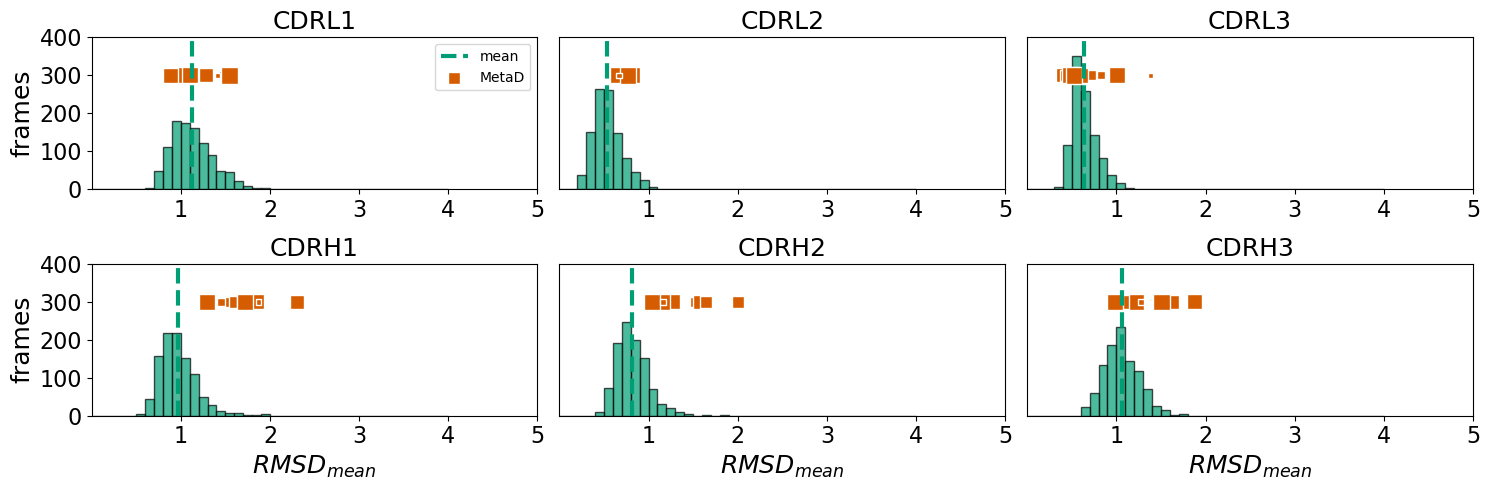

In [210]:
system_name='5I18'

fig,(axs)=plt.subplots(2,3,figsize=(15,5))

axs=axs.flatten()

counts=axs[0].hist(Rmean_cdr1_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[0].plot([np.mean(Rmean_cdr1_light[2,:]),np.mean(Rmean_cdr1_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='mean')
axs[0].scatter([Rmean_cdr1_light_pdb],[[300 for i in Rmean_cdr1_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00',label='MetaD')
axs[0].legend()

axs[0].set_title('CDRL1',fontsize=18)

counts=axs[1].hist(Rmean_cdr2_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[1].plot([np.mean(Rmean_cdr2_light[2,:]),np.mean(Rmean_cdr2_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[1].scatter([Rmean_cdr2_light_pdb],[[300 for i in Rmean_cdr2_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[1].set_title('CDRL2',fontsize=18)


counts=axs[2].hist(Rmean_cdr3_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[2].plot([np.mean(Rmean_cdr3_light[2,:]),np.mean(Rmean_cdr3_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[2].scatter([Rmean_cdr3_light_pdb],[[300 for i in Rmean_cdr3_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[2].set_title('CDRL3',fontsize=18)


counts=axs[3].hist(Rmean_cdr1_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[3].plot([np.mean(Rmean_cdr1_heavy[2,:]),np.mean(Rmean_cdr1_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[3].scatter([Rmean_cdr1_heavy_pdb],[[300 for i in Rmean_cdr1_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[3].set_title('CDRH1',fontsize=18)


counts=axs[4].hist(Rmean_cdr2_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[4].plot([np.mean(Rmean_cdr2_heavy[2,:]),np.mean(Rmean_cdr2_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[4].scatter([Rmean_cdr2_heavy_pdb],[[300 for i in Rmean_cdr2_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[4].set_title('CDRH2',fontsize=18)


counts=axs[5].hist(Rmean_cdr3_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[5].plot([np.mean(Rmean_cdr3_heavy[2,:]),np.mean(Rmean_cdr3_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[5].scatter([Rmean_cdr3_heavy_pdb],[[300 for i in Rmean_cdr3_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[5].set_title('CDRH3',fontsize=18)

for ax in axs:

    ax.set_xlim(0,5)
    ax.set_ylim(0,400)
    ax.set_yticks([0,100,200,300,400])
    ax.set_yticklabels([0,100,200,300,400],fontsize=16)
    ax.set_xticks([1,2,3,4,5])
    ax.set_xticklabels([1,2,3,4,5],fontsize=16)
axs[3].set_xlabel(r'$RMSD_{mean}$',fontsize=18)
axs[4].set_xlabel(r'$RMSD_{mean}$',fontsize=18)
axs[5].set_xlabel(r'$RMSD_{mean}$',fontsize=18)

axs[0].set_ylabel('frames',fontsize=18)
axs[3].set_ylabel('frames',fontsize=18)
axs[0].legend()

for ax in [axs[1],axs[2],axs[4],axs[5]]:
    ax.set_yticks([])


fig.tight_layout()
plt.savefig(f'../figures/{system_name}_restraints_rmsd_all_cdrs.pdf')

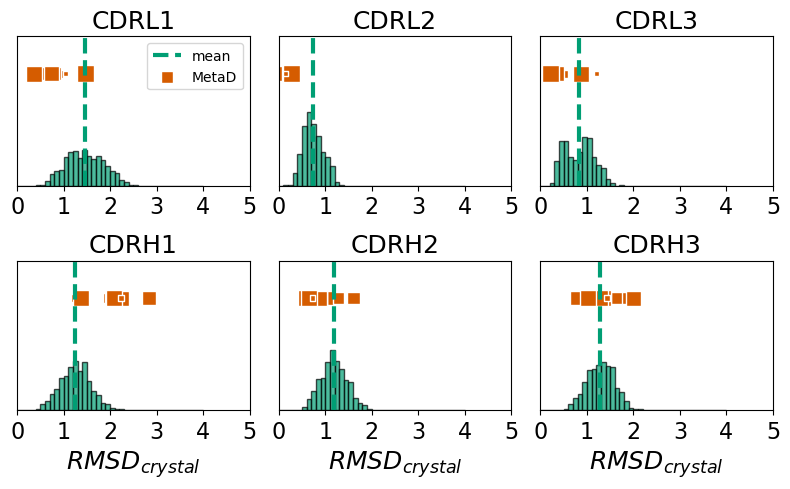

In [211]:
system_name='5I18'

fig,(axs)=plt.subplots(2,3,figsize=(8,5))

axs=axs.flatten()

counts=axs[0].hist(Rref_cdr1_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[0].plot([np.mean(Rref_cdr1_light[2,:]),np.mean(Rref_cdr1_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='mean')
axs[0].scatter([Rref_cdr1_light_pdb],[[300 for i in Rref_cdr1_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00',label='MetaD')
axs[0].legend(fontsize=18)

axs[0].set_title('CDRL1',fontsize=18)

counts=axs[1].hist(Rref_cdr2_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[1].plot([np.mean(Rref_cdr2_light[2,:]),np.mean(Rref_cdr2_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[1].scatter([Rref_cdr2_light_pdb],[[300 for i in Rref_cdr2_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[1].set_title('CDRL2',fontsize=18)


counts=axs[2].hist(Rref_cdr3_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[2].plot([np.mean(Rref_cdr3_light[2,:]),np.mean(Rref_cdr3_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[2].scatter([Rref_cdr3_light_pdb],[[300 for i in Rref_cdr3_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[2].set_title('CDRL3',fontsize=18)


counts=axs[3].hist(Rref_cdr1_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[3].plot([np.mean(Rref_cdr1_heavy[2,:]),np.mean(Rref_cdr1_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[3].scatter([Rref_cdr1_heavy_pdb],[[300 for i in Rref_cdr1_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[3].set_title('CDRH1',fontsize=18)


counts=axs[4].hist(Rref_cdr2_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[4].plot([np.mean(Rref_cdr2_heavy[2,:]),np.mean(Rref_cdr2_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[4].scatter([Rref_cdr2_heavy_pdb],[[300 for i in Rref_cdr2_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[4].set_title('CDRH2',fontsize=18)


counts=axs[5].hist(Rref_cdr3_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[5].plot([np.mean(Rref_cdr3_heavy[2,:]),np.mean(Rref_cdr3_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[5].scatter([Rref_cdr3_heavy_pdb],[[300 for i in Rref_cdr3_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[5].set_title('CDRH3',fontsize=18)

for ax in axs:

    ax.set_xlim(0,5)
    ax.set_ylim(0,400)
    ax.set_xticks([0,1,2,3,4,5])
    ax.set_xticklabels([0,1,2,3,4,5],fontsize=16)
axs[3].set_xlabel(r'$RMSD_{crystal}$',fontsize=18)
axs[4].set_xlabel(r'$RMSD_{crystal}$',fontsize=18)
axs[5].set_xlabel(r'$RMSD_{crystal}$',fontsize=18)

axs[0].legend()

for ax in axs:
    ax.set_yticks([])
fig.tight_layout()
plt.savefig(f'../figures/{system_name}_restraints_rmsd_ref_cdrs.pdf')

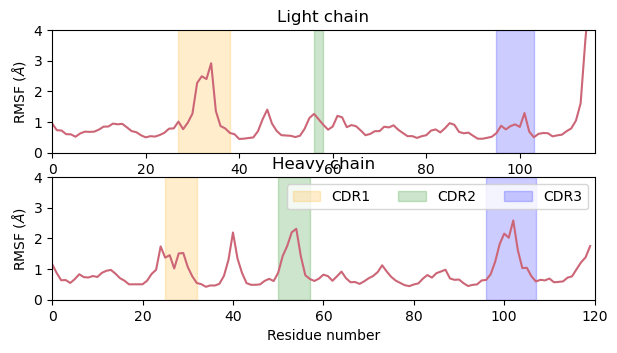

In [212]:
fig,(axs)=plt.subplots(2,1,figsize=(7,3.5))

axs[0].plot([i for i in range(len(res_light))],rmsf_sim_light,color='#CC6677')

axs[0].set_xlabel('Residue number')
axs[0].set_ylabel('RMSF ($\AA$)')
axs[0].axvspan(cv3_cdrs_light_sim[0][0]-start_chain_light,cv3_cdrs_light_sim[0][1]-start_chain_light, zorder=0, alpha=0.2, color='orange', label='CDR1')
axs[0].axvspan(cv3_cdrs_light_sim[1][0]-start_chain_light,cv3_cdrs_light_sim[1][1]-start_chain_light, zorder=0, alpha=0.2, color='green', label='CDR2')
axs[0].axvspan(cv3_cdrs_light_sim[2][0]-start_chain_light,cv3_cdrs_light_sim[2][1]-start_chain_light, zorder=0, alpha=0.2, color='blue', label='CDR3')
axs[0].set_ylim(0,4)
axs[0].set_xlim(0,len(res_light))


axs[1].plot([i for i in range(len(res_heavy))],rmsf_sim_heavy, color='#CC6677')

axs[1].set_xlabel('Residue number')
axs[1].set_ylabel('RMSF ($\AA$)')
axs[1].axvspan(cv3_cdrs_heavy_sim[0][0],cv3_cdrs_heavy_sim[0][1], zorder=0, alpha=0.2, color='orange', label='CDR1')
axs[1].axvspan(cv3_cdrs_heavy_sim[1][0],cv3_cdrs_heavy_sim[1][1], zorder=0, alpha=0.2, color='green', label='CDR2')
axs[1].axvspan(cv3_cdrs_heavy_sim[2][0],cv3_cdrs_heavy_sim[2][1], zorder=0, alpha=0.2, color='blue', label='CDR3')
axs[1].set_ylim(0,4)
axs[1].legend(ncol=3)
axs[1].set_xlim(0,len(res_heavy))

axs[1].set_title('Heavy chain')
axs[0].set_title('Light chain')

plt.savefig(f'../figures/{system_name}_restraints_rmsf_all.pdf')


/var/folders/8w/2dqxrgsd4vj00wv819dcz51w0000gn/T/ipykernel_44258/2441655020.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


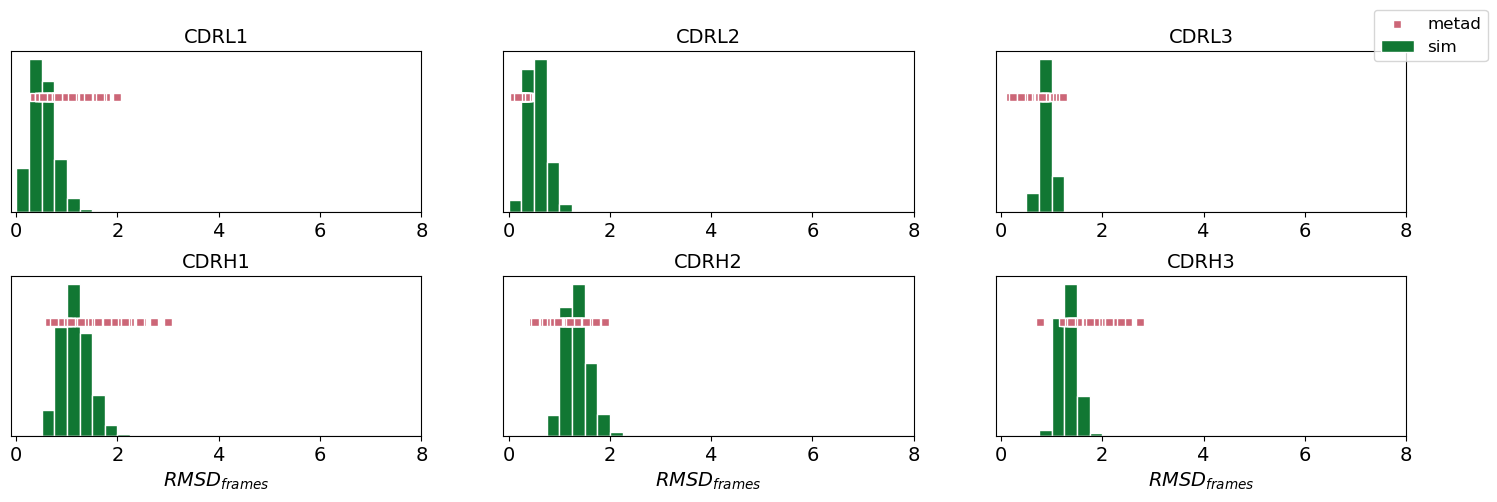

In [213]:
fig, axes = plt.subplots(2, 3, figsize=(18, 5), gridspec_kw={'hspace': 0.4, 'wspace': 0.2})
colors = ['#117733','#CC6677','#AB6D52','gray']  # One color per method
methods = list(rmsd_all_dist.keys())

# Ensure axes is 2D
axes = np.atleast_2d(axes)

for row_idx, chain in enumerate(['light','heavy']):
    for col_idx, cdr in enumerate([1, 2, 3]):
        ax = axes[row_idx, col_idx]

        for method_idx, method in enumerate(methods):
            try:
                data = rmsd_all_dist[method][chain][cdr-1]
                if method == 'pdbs':
                    y = [1.5*(len(methods)-1)] * len(data)
                    ax.scatter(data, y, facecolor=colors[method_idx], edgecolor='white',marker='s', 
                               label=method if row_idx == 0 else "")
                elif method == 'metad':
                    y = [1.5*(len(methods)-1.5)] * len(data)
                    ax.scatter(data, y, facecolor=colors[method_idx], edgecolor='white',marker='s', 
                               label=method if row_idx == 0 else "")
                else:

                    counts, bin_edges = np.histogram(data, bins=40, range=[0, 10.0])
                    pdf = counts / counts.max()
                    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
                    
                    # Plot
                    ax.bar(bin_centers, pdf, width=bin_edges[1] - bin_edges[0], 
                           color=colors[method_idx], edgecolor='w', 
                           label=method if row_idx == 0 else "", 
                           bottom=method_idx * 1.5)
                    ax.plot([0, 10], [method_idx * 1.5, method_idx * 1.5],  color='lightgray', alpha=0.2)
                    
            except KeyError:
                continue

        ax.set_xlim(-0.1, 8)
        ax.set_xticks([0,2,4,6,8])
        ax.set_xticklabels([0,2,4,6,8],fontsize=14)
        ax.set_yticks([])
        if row_idx == 1:
            ax.set_xlabel(r'$ RMSD_{frames}$',fontsize=14)
        
        ax.set_title(f"CDR{chain[0].upper()}{cdr}",fontsize=14)
# Add a legend only once
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.95, 0.98),fontsize=12)

plt.tight_layout()
plt.savefig(f'../figures/{system_name}_sim_metad_rmsd_matrix.pdf')

## 2Q76 - unbound

#### load starting pdb and pdbs

In [216]:
folder_dict='../src/extra_pdbs/imgt2cv_dict/'

folder_pdbs=os.path.abspath('../src/extra_pdbs/pdbs_imgt/')
pdbs_all=os.listdir(folder_pdbs)

pdb_list=['2q76_Fv_DC.pdb', '2q76_Fv_BA.pdb']
chain_list=['DC','BA']

In [217]:
pdb_list

['2q76_Fv_DC.pdb', '2q76_Fv_BA.pdb']

In [218]:
chain_list

['DC', 'BA']

In [219]:
n_pdbs=len(pdb_list)

In [220]:
os.listdir('../src/metaD_clusters/D44_2Q76_clusters/')

['cluster.CL-rep.c0.pdb']

In [221]:
n_cluster=len(os.listdir('../src/metaD_clusters/D44_2Q76_clusters/'))

In [222]:
dict_prob_cluster={'cluster.CL-rep.c0.pdb':1.0}

In [223]:
cluster_pdb_list=os.listdir('../src/metaD_clusters/D44_2Q76_clusters/')
cluster_chain_list=['HL','HL','HL','HL','HL']
cluster_folder_pdbs='../src/metaD_clusters/D44_2Q76_clusters/'
cluster_pdb_prob=np.array([dict_prob_cluster[cluster] for cluster in cluster_pdb_list])

In [224]:
sys_name='2q76'
pdb_trajectories = [md.load(os.path.join('../src/metaD_clusters/D44_2Q76_clusters/',pdb_name)) for pdb_name in os.listdir('../src/metaD_clusters/D44_2Q76_clusters/')]*2

# Step 2: Concatenate all into a single trajectory
pdb_traj = md.join(pdb_trajectories)
pdb_traj.save_xtc(f"../src/metaD_clusters/imgt_traj_clusters/{sys_name}joined_pdbs.xtc")

pdb_traj = mda.Universe('../src/metaD_clusters/D44_2Q76_clusters/cluster.CL-rep.c0.pdb',f"../src/metaD_clusters/imgt_traj_clusters/{sys_name}joined_pdbs.xtc")


/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/XDR.py:240: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


In [225]:
rmsd_all_dist={}
rmsd_all_dist['sim']={'heavy':{},'light':{}}
rmsd_all_dist['metad']={'heavy':{},'light':{}}
rmsd_all_dist['fa']={'heavy':{},'light':{}}

In [226]:
chain_cluster=['H','L']
for chain_idx,chain_type in enumerate(['heavy','light']):
    for idx_cdr, cdr in enumerate(cdrs_list):
        rmsd_all_dist['metad'][chain_type][idx_cdr]=dist_trajs(pdb_traj,select=f'segid {chain_cluster[chain_idx]} and name CA and resid {cdr[0]-1}:{cdr[1]+1}')
        if len(rmsd_all_dist['metad'][chain_type][idx_cdr]) ==0:
            rmsd_all_dist['metad'][chain_type][idx_cdr]=np.array([0])

### load fa simulations

In [227]:
top_file = '../src/sims_cv3fv/2q76_DC/2q76_Fv_DC.pdb'  # Path to your PDB file
chain_sequences = extract_sequences_by_chain(top_file)

# Print sequences for each chain
for chain_id, sequence in chain_sequences.items():
    print(f"Chain {chain_id} {len(sequence)}: {sequence}")
    if chain_id == 'D':
        res_heavy=sequence
    if chain_id == 'C':
        res_light=sequence

Chain D 118: EVQLEQSGAELMKPGASVKISCKATGYTFTTYWIEWIKQRPGHSLEWIGEILPGSDSTYYNEKVKGKVTFTADASSNTAYMQLSSLTSEDSAVYYCARGDGFYVYWGQGTTLTVSSAS
Chain C 110: DIELTQSPATLSVTPGDSVSLSCRASQSISNNLHWYQQKSHESPRLLIKYTSQSMSGIPSRFSGSGSGTDFTLSINSVETEDFGVYFCQQSGSWPRTFGGGTKLDIKRAD


In [228]:
top_file = '../src/aa_md/2q76.pdb'  # Path to your PDB file
xtc_file='../src/aa_md/2q76_ion_strip_aligned_merged.xtc'  ### traj need to be merged first, you can use mdanalysis for this

mobile = mda.Universe(top_file,xtc_file)
ref = mda.Universe(top_file,xtc_file)

#trajectory = md.load(xtc_file, top=top_file)  # Adjust file names/paths as needed
#top

In [229]:
cv3_cdrs_light_fa=[[27,32],[50,52],[89,97]]

In [230]:
cv3_cdrs_heavy_fa=[[238,245],[263,270],[309,317]]

In [231]:
Rref_cdr1_light_fa,Rmean_cdr1_light_fa=calc_rmsd(mobile,ref,select=f'backbone and resid {cv3_cdrs_light_fa[0][0]}:{cv3_cdrs_light_fa[0][1]}')
Rref_cdr2_light_fa,Rmean_cdr2_light_fa=calc_rmsd(mobile,ref,select=f'backbone and resid {cv3_cdrs_light_fa[1][0]}:{cv3_cdrs_light_fa[1][1]}')
Rref_cdr3_light_fa,Rmean_cdr3_light_fa=calc_rmsd(mobile,ref,select=f'backbone and resid {cv3_cdrs_light_fa[2][0]}:{cv3_cdrs_light_fa[2][1]}')

Rref_cdr1_heavy_fa,Rmean_cdr1_heavy_fa=calc_rmsd(mobile,ref,select=f'backbone and resid {cv3_cdrs_heavy_fa[0][0]}:{cv3_cdrs_heavy_fa[0][1]}')
Rref_cdr2_heavy_fa,Rmean_cdr2_heavy_fa=calc_rmsd(mobile,ref,select=f'backbone and resid {cv3_cdrs_heavy_fa[1][0]}:{cv3_cdrs_heavy_fa[1][1]}')
Rref_cdr3_heavy_fa,Rmean_cdr3_heavy_fa=calc_rmsd(mobile,ref,select=f'backbone and resid {cv3_cdrs_heavy_fa[2][0]}:{cv3_cdrs_heavy_fa[2][1]}')

/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/memory.py:535: DeprecationWarning: asel argument to timeseries will be renamed to'atomgroup' in 3.0, see #3911
  warnings.warn(


done
done
done
done
done
done


In [232]:
trajectory = md.load(xtc_file, top=top_file)  # Adjust file names/paths as needed


In [233]:
# Light chain
atom_indices = trajectory.topology.select('name CA and chainid 0')
# Restrict the trajectory to the selected atoms
sub_traj = trajectory.atom_slice(atom_indices)
sub_traj.center_coordinates()
rmsf_fa = md.rmsf(sub_traj, sub_traj, 0, precentered=True) *10

rmsf_fa_light=rmsf_fa[:214]
rmsf_fa_heavy=rmsf_fa[214:]

In [234]:
Rmean_cdr1_light_fa_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_fa[0][0]-1}:{cv3_cdrs_light_fa[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', 'L')
Rmean_cdr2_light_fa_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_fa[1][0]-1}:{cv3_cdrs_light_fa[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', 'L')
Rmean_cdr3_light_fa_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_fa[2][0]-1}:{cv3_cdrs_light_fa[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', 'L')

Rmean_cdr1_heavy_fa_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_fa[0][0]-1}:{cv3_cdrs_heavy_fa[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', 'H')
Rmean_cdr2_heavy_fa_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_fa[1][0]-1}:{cv3_cdrs_heavy_fa[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', 'H')
Rmean_cdr3_heavy_fa_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_fa[2][0]-1}:{cv3_cdrs_heavy_fa[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', 'H')

/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:777: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


In [235]:
dict_chains={'heavy':'H', 'light':'L'}
cdr_sim=[cv3_cdrs_heavy_fa,cv3_cdrs_light_fa]

for chain_idx,chain_type in enumerate(['heavy','light']):
    for idx_cdr, cdr in enumerate(cdrs_list):
        try:
            print(idx_cdr)
            dist_array=np.load(f'../src/aa_md/distances_pairwise/2q76_CDR{dict_chains[chain_type]}{idx_cdr+1}_distances.npy')
            # if idx_cdr ==2:
            #     dist_array=dist_array+0.5
            #     print(np.mean(dist_array))
            #     np.save(f'../src/aa_md/distances_pairwise/3v6f_CDR{dict_chains[chain_type]}{idx_cdr+1}_distances.npy',dist_array)
            hist_counts, bin_edges = np.histogram(dist_array, bins=40, range=(0, 5.0), density=False)
            np.save(f'../src/aa_md/histogramed_data/{sys_name}_{chain_type}_{(idx_cdr+1)}_hist_fa.npy',hist_counts)
        except:
            print('dist array not found',cdr)
        

0
dist array not found [27, 38]
1
dist array not found [56, 65]
2
dist array not found [105, 117]
0
dist array not found [27, 38]
1
dist array not found [56, 65]
2
dist array not found [105, 117]


In [236]:
dict_chains={'heavy':'H', 'light':'L'}
cdr_sim=[cv3_cdrs_heavy_fa,cv3_cdrs_light_fa]

for chain_idx,chain_type in enumerate(['heavy','light']):
    for idx_cdr, cdr in enumerate(cdrs_list):
        try:
            print(idx_cdr)
            hist_counts=np.load(f'../src/aa_md/histogramed_data/{sys_name}_{chain_type}_{(idx_cdr+1)}_hist_fa.npy')
            rmsd_all_dist['fa'][chain_type][idx_cdr]=hist_counts
        except:
            print('na yet',cdr)
        

0
1
2
0
1
2


### load simulations

In [237]:
sel_chain='DC'
topology_fa = "../src/sims_cv3fv/2q76_DC/2q76_Fv_DC_top.pdb"

top_pdb=mda.Universe(topology_fa,topology_fa)

dict_imgt2cv='../src/sims_cv3fv/2q76_DC/2q76_dict_Fv_DC.txt'

In [238]:
prefix_sim=os.path.abspath('../src/sims_cv3fv/2q76_DC/2q76_Fv_DC')
topology_fa= os.path.join(prefix_sim+"_top.pdb")
xtc_file = os.path.join(prefix_sim+"_aligned.xtc")

mobile = mda.Universe(topology_fa,xtc_file)
ref = mda.Universe(topology_fa,xtc_file)

mobile.trajectory  # set mobile trajectory to last frame
ref.trajectory[0]  # set reference trajectory to first frame

##dict_loc,chain,cdr_boundaries
cv3_cdrs_light_sim=[extract_cdr_coord(dict_imgt2cv,sel_chain[1],cdrs_list[0]),extract_cdr_coord(dict_imgt2cv,sel_chain[1],cdrs_list[1]),extract_cdr_coord(dict_imgt2cv,sel_chain[1],cdrs_list[2])]
cv3_cdrs_heavy_sim=[extract_cdr_coord(dict_imgt2cv,sel_chain[0],cdrs_list[0]),extract_cdr_coord(dict_imgt2cv,sel_chain[0],cdrs_list[1]),extract_cdr_coord(dict_imgt2cv,sel_chain[0],cdrs_list[2])]

In [241]:
Rref_cdr1_light,Rmean_cdr1_light=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_light_sim[0][0]}:{cv3_cdrs_light_sim[0][1]}')
Rref_cdr2_light,Rmean_cdr2_light=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_light_sim[1][0]}:{cv3_cdrs_light_sim[1][1]}')
Rref_cdr3_light,Rmean_cdr3_light=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_light_sim[2][0]}:{cv3_cdrs_light_sim[2][1]}')

Rref_cdr1_heavy,Rmean_cdr1_heavy=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_heavy_sim[0][0]}:{cv3_cdrs_heavy_sim[0][1]}')
Rref_cdr2_heavy,Rmean_cdr2_heavy=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_heavy_sim[1][0]}:{cv3_cdrs_heavy_sim[1][1]}')
Rref_cdr3_heavy,Rmean_cdr3_heavy=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_heavy_sim[2][0]}:{cv3_cdrs_heavy_sim[2][1]}')


done
done
done
done
done
done


In [242]:
trajectory = md.load(xtc_file, top=topology_fa)  # Adjust file names/paths as needed

# Light chain
atom_indices = trajectory.topology.select('name CA and chainid 0')
# Restrict the trajectory to the selected atoms
sub_traj = trajectory.atom_slice(atom_indices)
sub_traj.center_coordinates()
rmsf_sim = md.rmsf(sub_traj, sub_traj, 0, precentered=True) *10
rmsd_sim = md.rmsd(sub_traj, sub_traj, 0, precentered=True) *10

rmsf_sim_heavy=rmsf_sim[:len(res_heavy)]
rmsf_sim_light=rmsf_sim[-(len(res_light)):]

In [243]:
# Light chain
atom_indices = trajectory.topology.select(f'name CA and resid >= {cv3_cdrs_light_sim[2][0]} and resid <= {cv3_cdrs_light_sim[2][1]}')
# Restrict the trajectory to the selected atoms
sub_traj_CDRL3_sim = trajectory.atom_slice(atom_indices)
sub_traj_CDRL3_sim.center_coordinates()

# Light chain
atom_indices = trajectory.topology.select(f'name CA and resid >= {cv3_cdrs_heavy_sim[2][0]} and resid <= {cv3_cdrs_heavy_sim[2][1]}')
# Restrict the trajectory to the selected atoms
sub_traj_CDRH3_sim = trajectory.atom_slice(atom_indices)
sub_traj_CDRH3_sim.center_coordinates()

<mdtraj.Trajectory with 1010 frames, 9 atoms, 9 residues, and unitcells at 0x1200b59f0>

In [244]:
rmsf_cdr1_light_sim=rmsf_sim[(cv3_cdrs_light_sim[0][0]-1):(cv3_cdrs_light_sim[0][1])]
rmsf_cdr2_light_sim=rmsf_sim[(cv3_cdrs_light_sim[1][0]-1):(cv3_cdrs_light_sim[1][1])]
rmsf_cdr3_light_sim=rmsf_sim[(cv3_cdrs_light_sim[2][0]-1):(cv3_cdrs_light_sim[2][1])]

rmsf_cdr1_heavy_sim=rmsf_sim[(cv3_cdrs_heavy_sim[0][0]-1):(cv3_cdrs_heavy_sim[0][1])]
rmsf_cdr2_heavy_sim=rmsf_sim[(cv3_cdrs_heavy_sim[1][0]-1):(cv3_cdrs_heavy_sim[1][1])]
rmsf_cdr3_heavy_sim=rmsf_sim[(cv3_cdrs_heavy_sim[2][0]-1):(cv3_cdrs_heavy_sim[2][1])]

#### rmsd pdbs

In [245]:
Rmean_cdr1_light_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[0][0]-1}:{cv3_cdrs_light_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', 'L')
Rmean_cdr2_light_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[1][0]-1}:{cv3_cdrs_light_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', 'L')
Rmean_cdr3_light_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[2][0]-1}:{cv3_cdrs_light_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', 'L')

Rmean_cdr1_heavy_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[0][0]-1}:{cv3_cdrs_heavy_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', 'H')
Rmean_cdr2_heavy_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[1][0]-1}:{cv3_cdrs_heavy_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', 'H')
Rmean_cdr3_heavy_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[2][0]-1}:{cv3_cdrs_heavy_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', 'H')

In [246]:
Rref_cdr1_light_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_light_sim[0][0]-1}:{cv3_cdrs_light_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', "L")
Rref_cdr2_light_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_light_sim[1][0]-1}:{cv3_cdrs_light_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', "L")
Rref_cdr3_light_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_light_sim[2][0]-1}:{cv3_cdrs_light_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', "L")

Rref_cdr1_heavy_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_heavy_sim[0][0]-1}:{cv3_cdrs_heavy_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', "H")
Rref_cdr2_heavy_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_heavy_sim[1][0]-1}:{cv3_cdrs_heavy_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', "H")
Rref_cdr3_heavy_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_heavy_sim[2][0]-1}:{cv3_cdrs_heavy_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', "H")

/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/base.py:725: UserWarning: Reader has no dt information, set to 1.0 ps
  return self.ts.dt


In [247]:
Rmetad_cdr1_light_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[0][0]-1}:{cv3_cdrs_light_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', 'L')
Rmetad_cdr2_light_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[1][0]-1}:{cv3_cdrs_light_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', 'L')
Rmetad_cdr3_light_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[2][0]-1}:{cv3_cdrs_light_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', 'L')

Rmetad_cdr1_heavy_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[0][0]-1}:{cv3_cdrs_heavy_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', 'H')
Rmetad_cdr2_heavy_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[1][0]-1}:{cv3_cdrs_heavy_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', 'H')
Rmetad_cdr3_heavy_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[2][0]-1}:{cv3_cdrs_heavy_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', 'H')

1012
1012
1012
1012
1012
1012


In [248]:
chain_sim=['P000','P001']
cdr_sim=[cv3_cdrs_heavy_sim,cv3_cdrs_light_sim]
for chain_idx,chain_type in enumerate(['heavy','light']):
    for idx_cdr, cdr in enumerate(cdrs_list):
        try:
            print(idx_cdr)
            dist_array=dist_trajs(mobile,select=f'segid {chain_sim[chain_idx]} and name CA and resid {cdr_sim[chain_idx][idx_cdr][0]-1}:{cdr_sim[chain_idx][idx_cdr][1]+1}').flatten()
            hist_counts, bin_edges = np.histogram(dist_array, bins=40, range=(0, 5.0), density=True)
            np.save(f'../src/aa_md/histogramed_data/{sys_name}_{chain_type}_{(idx_cdr+1)}_hist_cv3.npy',hist_counts)
        except:
            print('dist array not found',cdr)
        

0
1
2
0
1
2


In [249]:
chain_sim=['P000','P001']
cdr_sim=[cv3_cdrs_heavy_sim,cv3_cdrs_light_sim]
for chain_idx,chain_type in enumerate(['heavy','light']):
    for idx_cdr, cdr in enumerate(cdrs_list):
        hist_counts=np.load(f'../src/aa_md/histogramed_data/{sys_name}_{chain_type}_{(idx_cdr+1)}_hist_cv3.npy')
        rmsd_all_dist['sim'][chain_type][idx_cdr]=hist_counts


### plots

In [250]:
size_clusters=np.array([250*np.sqrt(dict_prob_cluster[cluster_file]) for cluster_file in reversed(os.listdir('../src/metaD_clusters/D44_2Q76_clusters/'))])

In [251]:
system_name='2Q76'

In [252]:
start_chain_light=len(res_heavy)

In [253]:
cluster_dot_size=[]
for cluster in os.listdir('../src/metaD_clusters/D44_2Q76_clusters//'):
    cluster_dot_size.append(dict_prob_cluster[cluster])
cluster_dot_size=np.array(cluster_dot_size)

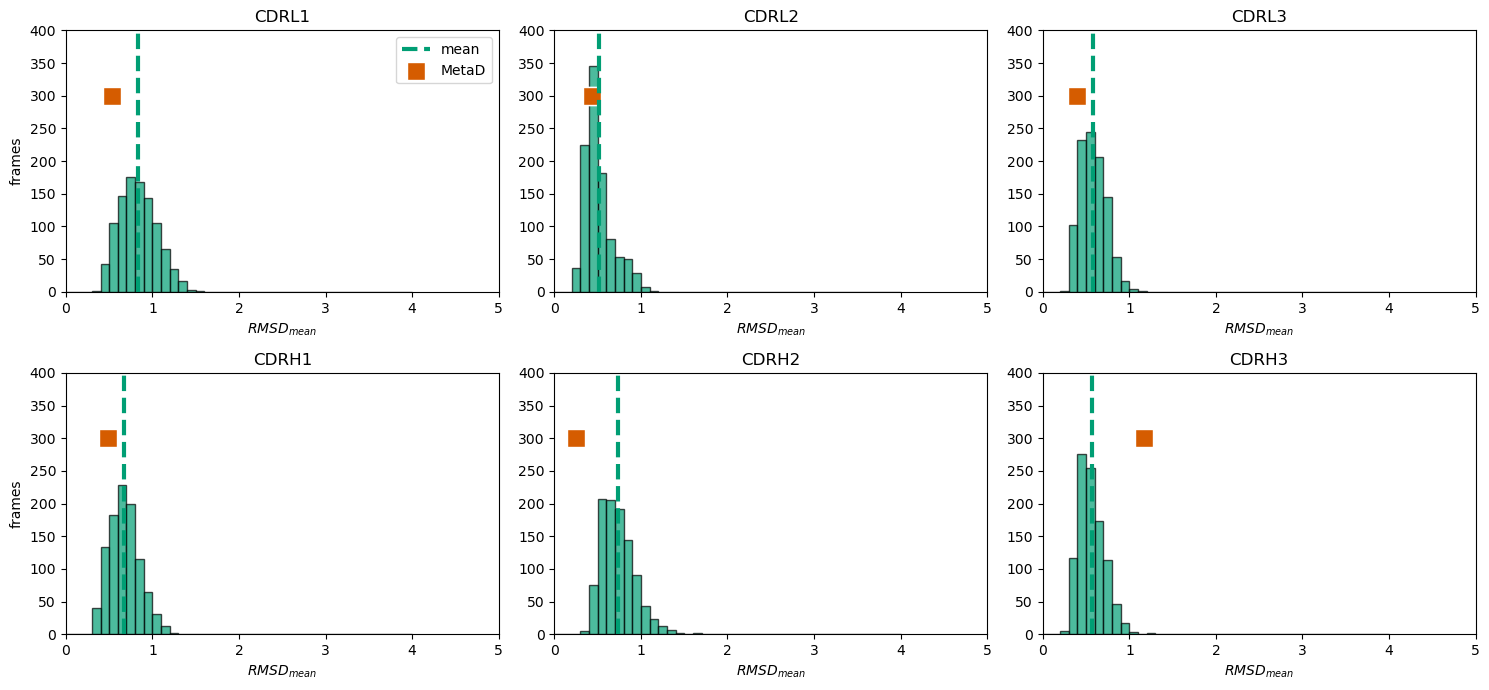

In [254]:
system_name='2Q76'

fig,(axs)=plt.subplots(2,3,figsize=(15,7))

axs=axs.flatten()

counts=axs[0].hist(Rmean_cdr1_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[0].plot([np.mean(Rmean_cdr1_light[2,:]),np.mean(Rmean_cdr1_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='mean')
axs[0].scatter([Rmean_cdr1_light_pdb],[[300 for i in Rmean_cdr1_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00',label='MetaD')
axs[0].legend()

axs[0].set_title('CDRL1')

counts=axs[1].hist(Rmean_cdr2_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[1].plot([np.mean(Rmean_cdr2_light[2,:]),np.mean(Rmean_cdr2_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[1].scatter([Rmean_cdr2_light_pdb],[[300 for i in Rmean_cdr2_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[1].set_title('CDRL2')


counts=axs[2].hist(Rmean_cdr3_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[2].plot([np.mean(Rmean_cdr3_light[2,:]),np.mean(Rmean_cdr3_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[2].scatter([Rmean_cdr3_light_pdb],[[300 for i in Rmean_cdr3_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[2].set_title('CDRL3')


counts=axs[3].hist(Rmean_cdr1_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[3].plot([np.mean(Rmean_cdr1_heavy[2,:]),np.mean(Rmean_cdr1_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[3].scatter([Rmean_cdr1_heavy_pdb],[[300 for i in Rmean_cdr1_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[3].set_title('CDRH1')


counts=axs[4].hist(Rmean_cdr2_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[4].plot([np.mean(Rmean_cdr2_heavy[2,:]),np.mean(Rmean_cdr2_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[4].scatter([Rmean_cdr2_heavy_pdb],[[300 for i in Rmean_cdr2_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[4].set_title('CDRH2')


counts=axs[5].hist(Rmean_cdr3_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[5].plot([np.mean(Rmean_cdr3_heavy[2,:]),np.mean(Rmean_cdr3_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[5].scatter([Rmean_cdr3_heavy_pdb],[[300 for i in Rmean_cdr3_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[5].set_title('CDRH3')

for ax in axs:

    ax.set_xlim(0,5)
    ax.set_xlabel(r'$RMSD_{mean}$')
    ax.set_ylim(0,400)
    
axs[0].set_ylabel('frames')
axs[3].set_ylabel('frames')
axs[0].legend()

fig.tight_layout()
plt.savefig(f'../figures/{system_name}_restraints_rmsd_all_cdrs.pdf')

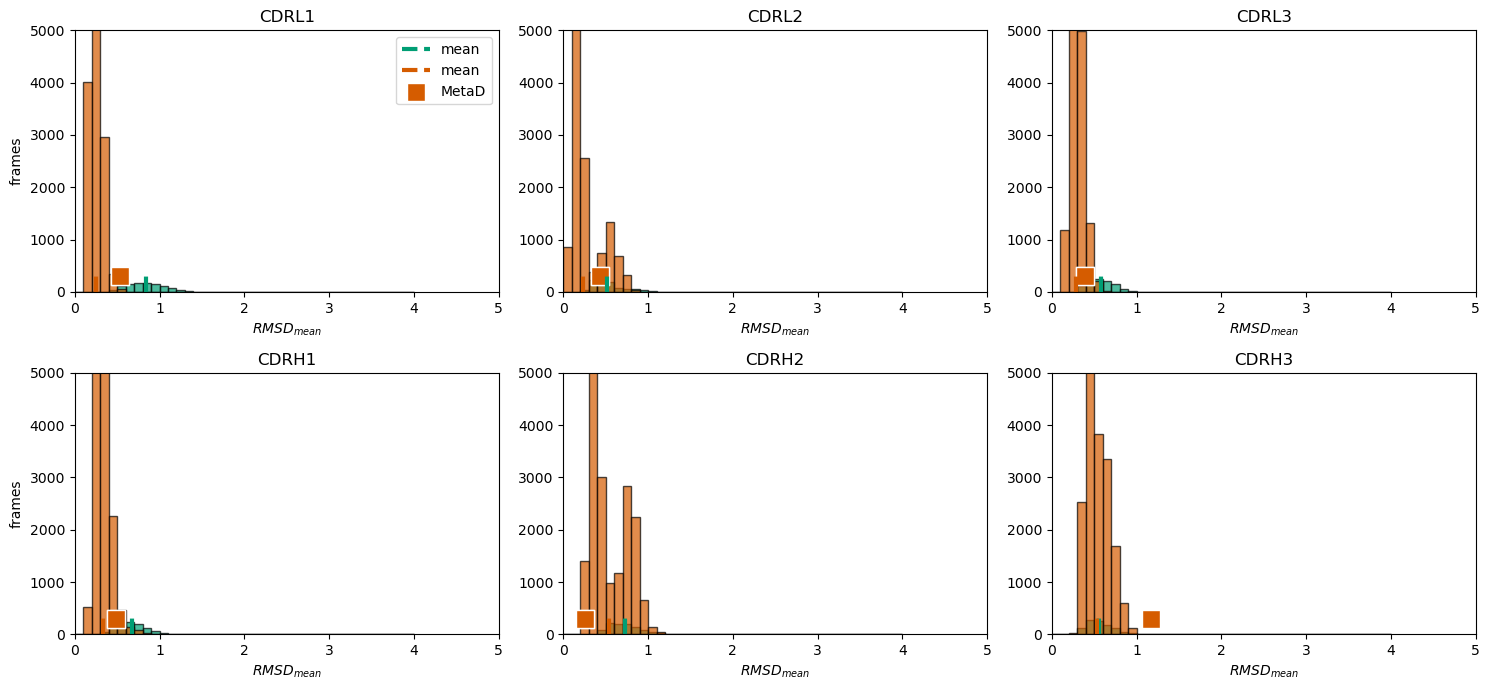

In [255]:
system_name='2Q76'

fig,(axs)=plt.subplots(2,3,figsize=(15,7))

axs=axs.flatten()

counts=axs[0].hist(Rmean_cdr1_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[0].plot([np.mean(Rmean_cdr1_light[2,:]),np.mean(Rmean_cdr1_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='mean')
counts=axs[0].hist(Rmean_cdr1_light_fa[2,15000:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#d55c00',alpha=0.7)
axs[0].plot([np.mean(Rmean_cdr1_light_fa[2,15000:]),np.mean(Rmean_cdr1_light_fa[2,15000:])],[0,400],lw=3,color='#d55c00',ls='--',label='mean')
axs[0].scatter([Rmean_cdr1_light_pdb],[[300 for i in Rmean_cdr1_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00',label='MetaD')
axs[0].legend()

axs[0].set_title('CDRL1')

counts=axs[1].hist(Rmean_cdr2_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
counts=axs[1].hist(Rmean_cdr2_light_fa[2,15000:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#d55c00',alpha=0.7)
axs[1].plot([np.mean(Rmean_cdr2_light_fa[2,15000:]),np.mean(Rmean_cdr2_light_fa[2,15000:])],[0,400],lw=3,color='#d55c00',ls='--',label='mean')
axs[1].plot([np.mean(Rmean_cdr2_light[2,:]),np.mean(Rmean_cdr2_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[1].scatter([Rmean_cdr2_light_pdb],[[300 for i in Rmean_cdr2_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[1].set_title('CDRL2')


counts=axs[2].hist(Rmean_cdr3_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[2].plot([np.mean(Rmean_cdr3_light[2,:]),np.mean(Rmean_cdr3_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
counts=axs[2].hist(Rmean_cdr3_light_fa[2,15000:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#d55c00',alpha=0.7)
axs[2].plot([np.mean(Rmean_cdr3_light_fa[2,15000:]),np.mean(Rmean_cdr3_light_fa[2,15000:])],[0,400],lw=3,color='#d55c00',ls='--',label='mean')
axs[2].scatter([Rmean_cdr3_light_pdb],[[300 for i in Rmean_cdr3_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[2].set_title('CDRL3')


counts=axs[3].hist(Rmean_cdr1_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[3].plot([np.mean(Rmean_cdr1_heavy[2,:]),np.mean(Rmean_cdr1_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
counts=axs[3].hist(Rmean_cdr1_heavy_fa[2,15000:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#d55c00',alpha=0.7)
axs[3].plot([np.mean(Rmean_cdr1_heavy_fa[2,15000:]),np.mean(Rmean_cdr1_heavy_fa[2,15000:])],[0,400],lw=3,color='#d55c00',ls='--',label='mean')
axs[3].scatter([Rmean_cdr1_heavy_pdb],[[300 for i in Rmean_cdr1_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[3].set_title('CDRH1')


counts=axs[4].hist(Rmean_cdr2_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[4].plot([np.mean(Rmean_cdr2_heavy[2,:]),np.mean(Rmean_cdr2_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
counts=axs[4].hist(Rmean_cdr2_heavy_fa[2,15000:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#d55c00',alpha=0.7)
axs[4].plot([np.mean(Rmean_cdr2_heavy_fa[2,15000:]),np.mean(Rmean_cdr2_heavy_fa[2,15000:])],[0,400],lw=3,color='#d55c00',ls='--',label='mean')
axs[4].scatter([Rmean_cdr2_heavy_pdb],[[300 for i in Rmean_cdr2_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[4].set_title('CDRH2')


counts=axs[5].hist(Rmean_cdr3_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[5].plot([np.mean(Rmean_cdr3_heavy[2,:]),np.mean(Rmean_cdr3_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[5].scatter([Rmean_cdr3_heavy_pdb],[[300 for i in Rmean_cdr3_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')
counts=axs[5].hist(Rmean_cdr3_heavy_fa[2,15000:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#d55c00',alpha=0.7)
axs[5].plot([np.mean(Rmean_cdr3_heavy_fa[2,15000:]),np.mean(Rmean_cdr3_heavy_fa[2,15000:])],[0,400],lw=3,color='#d55c00',ls='--',label='mean')
axs[5].set_title('CDRH3')

for ax in axs:

    ax.set_xlim(0,5)
    ax.set_xlabel(r'$RMSD_{mean}$')
    ax.set_ylim(0,5000)
    
axs[0].set_ylabel('frames')
axs[3].set_ylabel('frames')
axs[0].legend()

fig.tight_layout()
plt.savefig(f'../figures/{system_name}_restraints_rmsd_all_cdrs.pdf')

In [256]:
data_cv3=[Rmean_cdr1_light[2,:],Rmean_cdr2_light[2,:],Rmean_cdr3_light[2,:],Rmean_cdr1_heavy[2,:],Rmean_cdr2_heavy[2,:],Rmean_cdr3_heavy[2,:]]
data_fa=[Rmean_cdr1_light_fa[2,15000:],Rmean_cdr2_light_fa[2,15000:],Rmean_cdr3_light_fa[2,15000:],Rmean_cdr1_heavy_fa[2,15000:],Rmean_cdr2_heavy_fa[2,15000:],Rmean_cdr3_heavy_fa[2,15000:]]
data_metad=[Rmean_cdr1_light_pdb,Rmean_cdr2_light_pdb,Rmean_cdr3_light_pdb,Rmean_cdr1_heavy_pdb,Rmean_cdr2_heavy_pdb,Rmean_cdr3_heavy_pdb]

0 0
0 1
0 2
1 0
1 1
1 2


/var/folders/8w/2dqxrgsd4vj00wv819dcz51w0000gn/T/ipykernel_44258/434029881.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


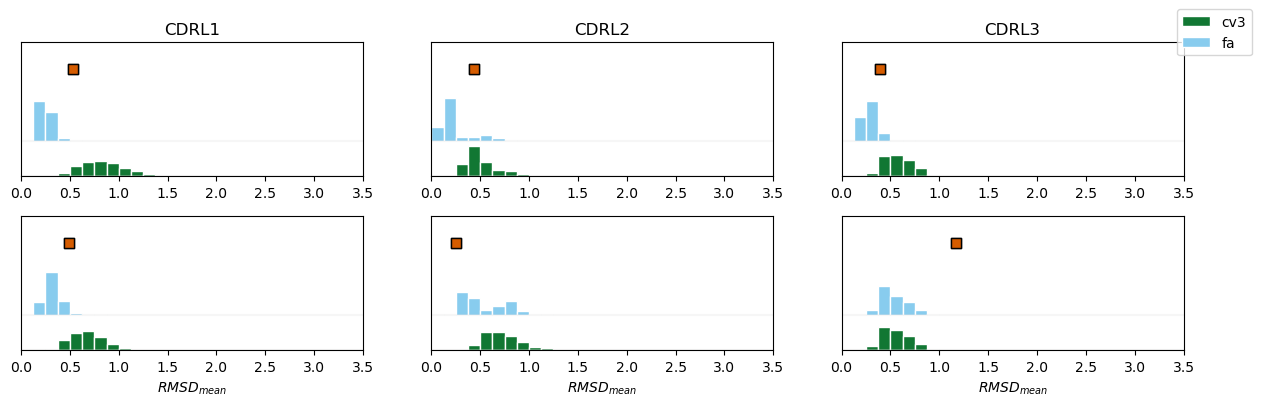

In [257]:
fig, axes = plt.subplots(len(pdb_list), 3, figsize=(15, len(pdb_list)*2),
                         gridspec_kw={'hspace': 0.3, 'wspace': 0.2})
colors = ['#117733','#88CCEE','#DDCC77','#CC6677','#AB6D52']  # One color per method

# Ensure axes is 2D
axes = np.atleast_2d(axes)

for row_idx, chain in enumerate(['L','H']):
    for col_idx, cdr in enumerate([1, 2, 3]):
        ax = axes[row_idx, col_idx]
        print(row_idx,col_idx)
        for method_idx, method in enumerate([data_cv3,data_fa,data_metad]):
            try:
                data = method[row_idx*3+col_idx]
                if method_idx !=2:
                    ax.hist(data, bins=40, range=[0, 5.0], facecolor=colors[method_idx], 
                            edgecolor='w', label='cv3' if method_idx == 0 else "fa",bottom=method_idx*4,density=True)
                    ax.plot([0,5],[method_idx*4,method_idx*4],color='lightgray',alpha=0.2)
                else:
                    ax.scatter([data],[[ (len(method)-2)*3 for i in data]],s=50, edgecolor='black',marker='s',color='#d55c00')
            except KeyError:
                continue

        ax.set_xlim(0, 3.5)
        ax.set_ylim([0,(len(method)-1)*3])
        ax.set_yticks([])
        if row_idx == len(pdb_list) - 1:
            ax.set_xlabel(r'$ RMSD_{mean}$')
            
        if row_idx == 0:
            ax.set_title(f"CDR{chain}{cdr}")
# Add a legend only once
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.95, 0.98))
plt.tight_layout()

#plt.savefig('../figures/7t0_comparison_crystal_multi_light.pdf')

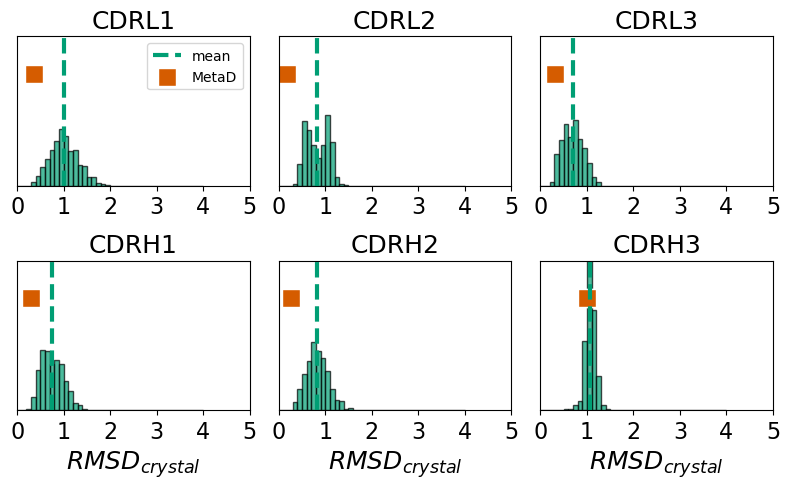

In [258]:
system_name='2Q76'
fig,(axs)=plt.subplots(2,3,figsize=(8,5))

axs=axs.flatten()

counts=axs[0].hist(Rref_cdr1_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[0].plot([np.mean(Rref_cdr1_light[2,:]),np.mean(Rref_cdr1_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='mean')
axs[0].scatter([Rref_cdr1_light_pdb],[[300 for i in Rref_cdr1_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00',label='MetaD')
axs[0].legend(fontsize=18)

axs[0].set_title('CDRL1',fontsize=18)

counts=axs[1].hist(Rref_cdr2_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[1].plot([np.mean(Rref_cdr2_light[2,:]),np.mean(Rref_cdr2_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[1].scatter([Rref_cdr2_light_pdb],[[300 for i in Rref_cdr2_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[1].set_title('CDRL2',fontsize=18)


counts=axs[2].hist(Rref_cdr3_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[2].plot([np.mean(Rref_cdr3_light[2,:]),np.mean(Rref_cdr3_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[2].scatter([Rref_cdr3_light_pdb],[[300 for i in Rref_cdr3_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[2].set_title('CDRL3',fontsize=18)


counts=axs[3].hist(Rref_cdr1_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[3].plot([np.mean(Rref_cdr1_heavy[2,:]),np.mean(Rref_cdr1_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[3].scatter([Rref_cdr1_heavy_pdb],[[300 for i in Rref_cdr1_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[3].set_title('CDRH1',fontsize=18)


counts=axs[4].hist(Rref_cdr2_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[4].plot([np.mean(Rref_cdr2_heavy[2,:]),np.mean(Rref_cdr2_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[4].scatter([Rref_cdr2_heavy_pdb],[[300 for i in Rref_cdr2_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[4].set_title('CDRH2',fontsize=18)


counts=axs[5].hist(Rref_cdr3_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[5].plot([np.mean(Rref_cdr3_heavy[2,:]),np.mean(Rref_cdr3_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[5].scatter([Rref_cdr3_heavy_pdb],[[300 for i in Rref_cdr3_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[5].set_title('CDRH3',fontsize=18)

for ax in axs:

    ax.set_xlim(0,5)
    ax.set_ylim(0,400)
    ax.set_xticks([0,1,2,3,4,5])
    ax.set_xticklabels([0,1,2,3,4,5],fontsize=16)
axs[3].set_xlabel(r'$RMSD_{crystal}$',fontsize=18)
axs[4].set_xlabel(r'$RMSD_{crystal}$',fontsize=18)
axs[5].set_xlabel(r'$RMSD_{crystal}$',fontsize=18)

axs[0].legend()

for ax in axs:
    ax.set_yticks([])
fig.tight_layout()
plt.savefig(f'../figures/{system_name}_restraints_rmsd_ref_cdrs.pdf')

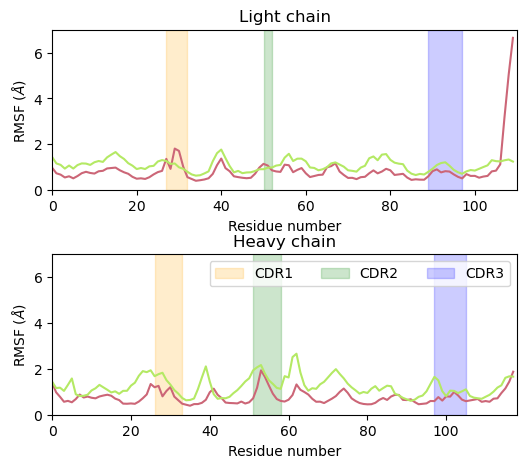

In [259]:
fig,(axs)=plt.subplots(2,1,figsize=(6,5),gridspec_kw={'hspace': 0.4})

axs[0].plot([i for i in range(len(res_light))],rmsf_sim_light,color='#CC6677')
axs[0].plot([i for i in range(len(res_light))],rmsf_fa_light[:110],color='#b4e964')

axs[0].set_xlabel('Residue number')
axs[0].set_ylabel('RMSF ($\AA$)')
axs[0].axvspan(cv3_cdrs_light_sim[0][0]-start_chain_light,cv3_cdrs_light_sim[0][1]-start_chain_light, zorder=0, alpha=0.2, color='orange', label='CDR1')
axs[0].axvspan(cv3_cdrs_light_sim[1][0]-start_chain_light,cv3_cdrs_light_sim[1][1]-start_chain_light, zorder=0, alpha=0.2, color='green', label='CDR2')
axs[0].axvspan(cv3_cdrs_light_sim[2][0]-start_chain_light,cv3_cdrs_light_sim[2][1]-start_chain_light, zorder=0, alpha=0.2, color='blue', label='CDR3')
axs[0].set_ylim(0,7)
axs[0].set_title('Light chain')
axs[0].set_xlim(0,len(res_light))


axs[1].plot([i for i in range(len(res_heavy))],rmsf_sim_heavy,color='#CC6677')
axs[1].plot([i for i in range(len(res_heavy))],rmsf_fa_heavy[:len(res_heavy)],color='#b4e964')

axs[1].set_xlabel('Residue number')
axs[1].set_ylabel('RMSF ($\AA$)')
axs[1].axvspan(cv3_cdrs_heavy_sim[0][0],cv3_cdrs_heavy_sim[0][1], zorder=0, alpha=0.2, color='orange', label='CDR1')
axs[1].axvspan(cv3_cdrs_heavy_sim[1][0],cv3_cdrs_heavy_sim[1][1], zorder=0, alpha=0.2, color='green', label='CDR2')
axs[1].axvspan(cv3_cdrs_heavy_sim[2][0],cv3_cdrs_heavy_sim[2][1], zorder=0, alpha=0.2, color='blue', label='CDR3')
axs[1].set_ylim(0,7)
axs[1].legend(ncol=3)
axs[1].set_title('Heavy chain')

axs[1].set_xlim(0,len(res_heavy))
plt.savefig(f'../figures/{system_name}_restraints_rmsf_all.pdf')
#print('RMSE light all chain:',rmse_light_all)
#print('RMSE heavy all chain:',rmse_heavy_all)

['sim', 'fa', 'metad']


/var/folders/8w/2dqxrgsd4vj00wv819dcz51w0000gn/T/ipykernel_44258/3199935506.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


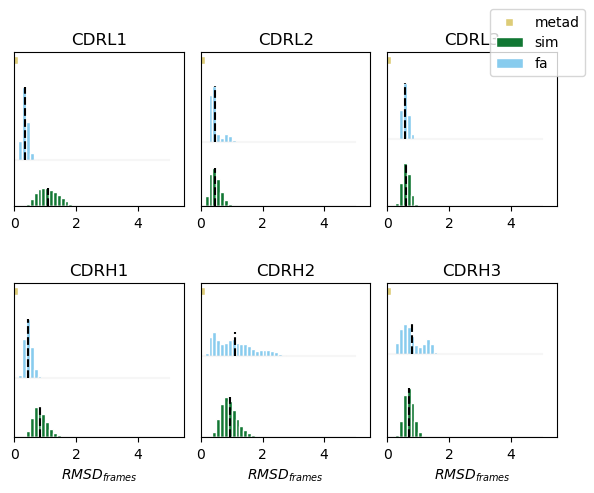

In [260]:
fig, axes = plt.subplots(2, 3, figsize=(7, 5),
                         gridspec_kw={'hspace': 0.5, 'wspace': 0.1})
colors = ['#117733','#88CCEE','#DDCC77','#CC6677','#AB6D52']  # One color per method
methods = ['sim', 'fa','metad'] 
print(methods)
# Ensure axes is 2D
axes = np.atleast_2d(axes)
for row_idx,chain_id in enumerate(['light','heavy']):
    for col_idx, cdr in enumerate([1, 2, 3]):
        ax = axes[row_idx, col_idx]
        bottom_meth=0
        for method_idx, method in enumerate(methods):
            try:
                data = rmsd_all_dist[method][chain_id][(cdr)-1]
                if method == 'metad':
                    y = [bottom_meth] * len(data)
                    ax.scatter(data, y, facecolor=colors[method_idx], edgecolor='white',marker='s', 
                               s=30., label=method if row_idx == 0 else "")
                    
                else:
                    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

                    data_sum = data.sum()
                    data_normalized = data / data_sum
                    
                    ax.bar(bin_centers, data_normalized, width=(bin_edges[1] - bin_edges[0]),color=colors[method_idx], edgecolor='w',
                           label=method if row_idx == 0 else "",bottom=bottom_meth)
                    mean = np.sum(bin_centers * data_normalized)
                    
                    ax.plot([0,5],[bottom_meth,bottom_meth],color='lightgray',alpha=0.2)
                    ax.plot([mean,mean],[bottom_meth,bottom_meth+np.max(data_normalized)],ls='--',color='k')
                    bottom_meth=bottom_meth+np.max(data_normalized)+0.2
                    
            except KeyError:
                pass
    
        ax.set_xlim(0, 5.5)
        ax.set_yticks([])
        if row_idx == len(pdb_list) - 1:
            ax.set_xlabel(r'$ RMSD_{frames}$')
        if row_idx == 0:
            ax.set_title(f"CDRL{cdr}")
        if row_idx == 1:
            ax.set_title(f"CDRH{cdr}")
# Add a legend only once
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.95, 0.98))
plt.tight_layout()

plt.savefig(f'../figures/{system_name}_sims_metad_rmsd_pairwise.pdf')

In [263]:
### comparison crystal:
with open('../src/aa_md/dist_from_fa/results_top_2q76_all.json','r') as f:
    distances_top_fa=json.load(f)

In [264]:
### comparison crystal:
with open('../src/aa_md/dist_from_fa/results_query_2q76_all.json','r') as f:
    distances_cv3_fa=json.load(f)

In [268]:
### comparison crystal:
with open('../src/aa_md/dist_from_fa/results_query_2q76_metad.json','r') as f:
    distances_metad_fa=json.load(f)

In [269]:
rmsd_threshold=[0.05*i for i in range(100)]

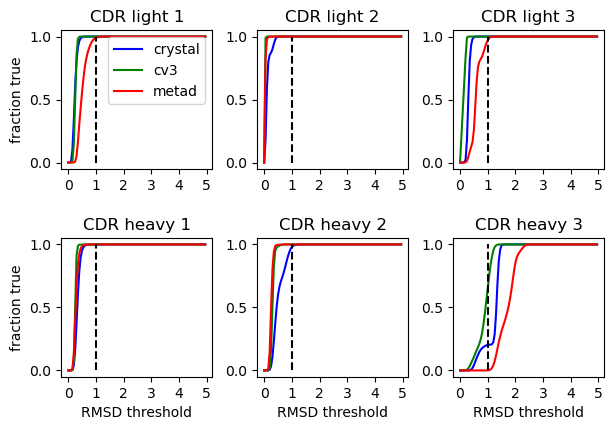

In [270]:
fig,axs = plt.subplots(2,3,figsize=(7,4.5),gridspec_kw={'hspace': 0.5, 'wspace': 0.3})
axs = np.atleast_2d(axs)
for row_idx,chain_id in enumerate(['light','heavy']):
    for col_idx, cdr in enumerate([1,2,3]):
        tp_top_thresh=[]
        tp_cv3_thresh=[]
        tp_metad_thresh=[]
        for rt in rmsd_threshold:
        
            tp_top_thresh.append(len(np.where(np.array(distances_top_fa['min'][chain_id][f'{cdr}'])< rt)[0])/len(np.array(distances_top_fa['min'][chain_id][f'{cdr}'])))
            tp_cv3_thresh.append(len(np.where(np.array(distances_cv3_fa['min'][chain_id][f'{cdr}'])< rt)[0])/len(np.array(distances_cv3_fa['min'][chain_id][f'{cdr}'])))
            tp_metad_thresh.append(len(np.where(np.array(distances_metad_fa['min'][chain_id][f'{cdr}'])< rt)[0])/len(np.array(distances_metad_fa['min'][chain_id][f'{cdr}'])))

        ax = axs[row_idx, col_idx]
        ax.plot(rmsd_threshold,tp_top_thresh,c='blue',label='crystal')
        ax.plot(rmsd_threshold,tp_cv3_thresh,c='green',label='cv3')
        ax.plot(rmsd_threshold,tp_metad_thresh,c='red',label='metad')
        ax.plot([1,1],[0,1],'k--')
        ax.set_xticks([0,1,2,3,4,5])
        ax.set_title(f'CDR {chain_id} {cdr}')
        
for ax in axs[:,0]:
    ax.set_ylabel('fraction true')
for ax in axs[-1,:]:
    ax.set_xlabel('RMSD threshold')

axs[0,0].legend()

plt.savefig(f'../figures/{system_name}_cv3_metad_crystal_tp_from_fa.pdf')

## 1JPS - bound

#### load starting pdb and pdbs

In [272]:
folder_dict='../src/extra_pdbs/imgt2cv_dict/'

folder_pdbs=os.path.abspath('../src/extra_pdbs/pdbs_imgt/')
pdbs_all=os.listdir(folder_pdbs)

pdb_list=['1jps_Fv_HL.pdb', '1pg7_Fv_HL.pdb', '1pg7_Fv_IM.pdb', '1jpt_Fv_HL.pdb']
chain_list=['HL','HL','IM','HL']

In [273]:
pdb_list

['1jps_Fv_HL.pdb', '1pg7_Fv_HL.pdb', '1pg7_Fv_IM.pdb', '1jpt_Fv_HL.pdb']

In [274]:
chain_list

['HL', 'HL', 'IM', 'HL']

In [276]:
n_pdbs=len(pdb_list)

In [277]:
os.listdir('../src/metaD_clusters/1JPS_clusters/')

['cluster.CL-rep.c5.pdb',
 'cluster.CL-rep.c4.pdb',
 'cluster.CL-rep.c0.pdb',
 'cluster.CL-rep.c1.pdb',
 'cluster.CL-rep.c3.pdb',
 'cluster.CL-rep.c2.pdb']

In [278]:
n_cluster=len(os.listdir('../src/metaD_clusters/1JPS_clusters/'))

In [279]:
dict_prob_cluster={'cluster.CL-rep.c0.pdb':0.70,'cluster.CL-rep.c1.pdb':0.23,'cluster.CL-rep.c2.pdb':0.05,'cluster.CL-rep.c3.pdb':0.01,'cluster.CL-rep.c4.pdb':0.006,'cluster.CL-rep.c5.pdb':0.004}

In [280]:
cluster_pdb_list=os.listdir('../src/metaD_clusters/1JPS_clusters/')
cluster_chain_list=['HL','HL','HL','HL','HL']
cluster_folder_pdbs='../src/metaD_clusters/1JPS_clusters/'
cluster_pdb_prob=np.array([dict_prob_cluster[cluster] for cluster in cluster_pdb_list])

In [281]:
sys_name='1jps'
pdb_trajectories = [md.load(os.path.join('../src/metaD_clusters/1JPS_clusters/',pdb_name)) for pdb_name in os.listdir('../src/metaD_clusters/1JPS_clusters/')]

# Step 2: Concatenate all into a single trajectory
pdb_traj = md.join(pdb_trajectories)
pdb_traj.save_xtc(f"../src/metaD_clusters/imgt_traj_clusters/{sys_name}joined_pdbs.xtc")

pdb_traj = mda.Universe('../src/metaD_clusters/1JPS_clusters/cluster.CL-rep.c0.pdb',f"../src/metaD_clusters/imgt_traj_clusters/{sys_name}joined_pdbs.xtc")


/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/XDR.py:240: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


In [282]:
rmsd_all_dist={}
rmsd_all_dist['sim']={'heavy':{},'light':{}}
rmsd_all_dist['metad']={'heavy':{},'light':{}}

In [283]:
chain_cluster=['H','L']
for chain_idx,chain_type in enumerate(['heavy','light']):
    for idx_cdr, cdr in enumerate(cdrs_list):
        rmsd_all_dist['metad'][chain_type][idx_cdr]=dist_trajs(pdb_traj,select=f'segid {chain_cluster[chain_idx]} and name CA and resid {cdr[0]-1}:{cdr[1]+1}')
        if len(rmsd_all_dist['metad'][chain_type][idx_cdr]) ==0:
            rmsd_all_dist['metad'][chain_type][idx_cdr]=np.array([0])

### load simulations

In [284]:
top_file = '../src/sims_cv3fv/1jps_HL/1jps_Fv_HL.pdb'  # Path to your PDB file
chain_sequences = extract_sequences_by_chain(top_file)

# Print sequences for each chain
for chain_id, sequence in chain_sequences.items():
    print(f"Chain {chain_id} {len(sequence)}: {sequence}")
    if chain_id == 'H':
        res_heavy=sequence
    if chain_id == 'L':
        res_light=sequence

Chain H 119: EVQLVESGGGLVQPGGSLRLSCAASGFNIKEYYMHWVRQAPGKGLEWVGLIDPEQGNTIYDPKFQDRATISADNSKNTAYLQMNSLRAEDTAVYYCARDTAAYFDYWGQGTLVTVSSAS
Chain L 110: DIQMTQSPSSLSASVGDRVTITCRASRDIKSYLNWYQQKPGKAPKVLIYYATSLAEGVPSRFSGSGSGTDYTLTISSLQPEDFATYYCLQHGESPWTFGQGTKVEIKRTV


In [285]:
sel_chain='HL'
topology_fa = "../src/sims_cv3fv/1jps_HL/1jps_Fv_HL_top.pdb"

top_pdb=mda.Universe(topology_fa,topology_fa)

dict_imgt2cv='../src/sims_cv3fv/1jps_HL/1jps_dict_Fv_HL.txt'

In [286]:
prefix_sim=os.path.abspath('../src/sims_cv3fv/1jps_HL/1jps_Fv_HL')
topology_fa= os.path.join(prefix_sim+"_top.pdb")
xtc_file = os.path.join(prefix_sim+"_aligned.xtc")

# topology_fa= os.path.join(prefix_sim+".pdb")
# xtc_file = os.path.join(prefix_sim+".xtc")


mobile = mda.Universe(topology_fa,xtc_file)
ref = mda.Universe(topology_fa,xtc_file)

mobile.trajectory  # set mobile trajectory to last frame
ref.trajectory[0]  # set reference trajectory to first frame
##dict_loc,chain,cdr_boundaries
cv3_cdrs_light_sim=[extract_cdr_coord(dict_imgt2cv,sel_chain[1],cdrs_list[0]),extract_cdr_coord(dict_imgt2cv,sel_chain[1],cdrs_list[1]),extract_cdr_coord(dict_imgt2cv,sel_chain[1],cdrs_list[2])]
cv3_cdrs_heavy_sim=[extract_cdr_coord(dict_imgt2cv,sel_chain[0],cdrs_list[0]),extract_cdr_coord(dict_imgt2cv,sel_chain[0],cdrs_list[1]),extract_cdr_coord(dict_imgt2cv,sel_chain[0],cdrs_list[2])]

In [287]:
Rref_cdr1_light,Rmean_cdr1_light=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_light_sim[0][0]}:{cv3_cdrs_light_sim[0][1]}')
Rref_cdr2_light,Rmean_cdr2_light=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_light_sim[1][0]}:{cv3_cdrs_light_sim[1][1]}')
Rref_cdr3_light,Rmean_cdr3_light=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_light_sim[2][0]}:{cv3_cdrs_light_sim[2][1]}')

Rref_cdr1_heavy,Rmean_cdr1_heavy=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_heavy_sim[0][0]}:{cv3_cdrs_heavy_sim[0][1]}')
Rref_cdr2_heavy,Rmean_cdr2_heavy=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_heavy_sim[1][0]}:{cv3_cdrs_heavy_sim[1][1]}')
Rref_cdr3_heavy,Rmean_cdr3_heavy=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_heavy_sim[2][0]}:{cv3_cdrs_heavy_sim[2][1]}')


/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/memory.py:535: DeprecationWarning: asel argument to timeseries will be renamed to'atomgroup' in 3.0, see #3911
  warnings.warn(


done
done
done
done
done
done


In [288]:
trajectory = md.load(xtc_file
, top=topology_fa)  # Adjust file names/paths as needed

# Light chain
atom_indices = trajectory.topology.select('name CA and chainid 0')
# Restrict the trajectory to the selected atoms
sub_traj = trajectory.atom_slice(atom_indices)
sub_traj.center_coordinates()
rmsf_sim = md.rmsf(sub_traj, sub_traj, 0, precentered=True) *10
rmsd_sim = md.rmsd(sub_traj, sub_traj, 0, precentered=True) *10

rmsf_sim_heavy=rmsf_sim[:len(res_heavy)]
rmsf_sim_light=rmsf_sim[-(len(res_light)):]

In [289]:
# Light chain
atom_indices = trajectory.topology.select(f'name CA and resid >= {cv3_cdrs_light_sim[2][0]} and resid <= {cv3_cdrs_light_sim[2][1]}')
# Restrict the trajectory to the selected atoms
sub_traj_CDRL3_sim = trajectory.atom_slice(atom_indices)
sub_traj_CDRL3_sim.center_coordinates()

# Light chain
atom_indices = trajectory.topology.select(f'name CA and resid >= {cv3_cdrs_heavy_sim[2][0]} and resid <= {cv3_cdrs_heavy_sim[2][1]}')
# Restrict the trajectory to the selected atoms
sub_traj_CDRH3_sim = trajectory.atom_slice(atom_indices)
sub_traj_CDRH3_sim.center_coordinates()

<mdtraj.Trajectory with 1010 frames, 10 atoms, 10 residues, and unitcells at 0x319f5eaa0>

In [290]:
rmsf_cdr1_light_sim=rmsf_sim[(cv3_cdrs_light_sim[0][0]-1):(cv3_cdrs_light_sim[0][1])]
rmsf_cdr2_light_sim=rmsf_sim[(cv3_cdrs_light_sim[1][0]-1):(cv3_cdrs_light_sim[1][1])]
rmsf_cdr3_light_sim=rmsf_sim[(cv3_cdrs_light_sim[2][0]-1):(cv3_cdrs_light_sim[2][1])]

rmsf_cdr1_heavy_sim=rmsf_sim[(cv3_cdrs_heavy_sim[0][0]-1):(cv3_cdrs_heavy_sim[0][1])]
rmsf_cdr2_heavy_sim=rmsf_sim[(cv3_cdrs_heavy_sim[1][0]-1):(cv3_cdrs_heavy_sim[1][1])]
rmsf_cdr3_heavy_sim=rmsf_sim[(cv3_cdrs_heavy_sim[2][0]-1):(cv3_cdrs_heavy_sim[2][1])]

#### rmsd pdbs

In [291]:
Rmean_cdr1_light_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[0][0]-1}:{cv3_cdrs_light_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', 'L')
Rmean_cdr2_light_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[1][0]-1}:{cv3_cdrs_light_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', 'L')
Rmean_cdr3_light_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[2][0]-1}:{cv3_cdrs_light_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', 'L')

Rmean_cdr1_heavy_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[0][0]-1}:{cv3_cdrs_heavy_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', 'H')
Rmean_cdr2_heavy_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[1][0]-1}:{cv3_cdrs_heavy_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', 'H')
Rmean_cdr3_heavy_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[2][0]-1}:{cv3_cdrs_heavy_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', 'H')

/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:777: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


In [292]:
Rref_cdr1_light_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_light_sim[0][0]-1}:{cv3_cdrs_light_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', 'L')
Rref_cdr2_light_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_light_sim[1][0]-1}:{cv3_cdrs_light_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', 'L')
Rref_cdr3_light_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_light_sim[2][0]-1}:{cv3_cdrs_light_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', 'L')

Rref_cdr1_heavy_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_heavy_sim[0][0]-1}:{cv3_cdrs_heavy_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', 'H')
Rref_cdr2_heavy_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_heavy_sim[1][0]-1}:{cv3_cdrs_heavy_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', 'H')
Rref_cdr3_heavy_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_heavy_sim[2][0]-1}:{cv3_cdrs_heavy_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', 'H')

/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/base.py:725: UserWarning: Reader has no dt information, set to 1.0 ps
  return self.ts.dt


In [293]:
Rmetad_cdr1_light_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[0][0]-1}:{cv3_cdrs_light_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', 'L')
Rmetad_cdr2_light_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[1][0]-1}:{cv3_cdrs_light_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', 'L')
Rmetad_cdr3_light_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[2][0]-1}:{cv3_cdrs_light_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', 'L')

Rmetad_cdr1_heavy_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[0][0]-1}:{cv3_cdrs_heavy_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', 'H')
Rmetad_cdr2_heavy_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[1][0]-1}:{cv3_cdrs_heavy_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', 'H')
Rmetad_cdr3_heavy_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[2][0]-1}:{cv3_cdrs_heavy_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', 'H')

1016
1016
1016
1016
1016
1016


In [294]:
chain_sim=['P000','P001']
cdr_sim=[cv3_cdrs_heavy_sim,cv3_cdrs_light_sim]
for chain_idx,chain_type in enumerate(['heavy','light']):
    for idx_cdr, cdr in enumerate(cdrs_list):
        rmsd_all_dist['sim'][chain_type][idx_cdr]=dist_trajs(mobile,select=f'segid {chain_sim[chain_idx]} and name CA and resid {cdr_sim[chain_idx][chain_idx][0]-1}:{cdr_sim[chain_idx][idx_cdr][1]+1}').flatten()

### plots

In [295]:
size_clusters=np.array([250*np.sqrt(dict_prob_cluster[cluster_file]) for cluster_file in reversed(os.listdir('../src/metaD_clusters/1JPS_clusters/'))])

In [296]:
len(size_clusters)

6

In [297]:
start_chain_light=len(res_heavy)

In [298]:
cluster_dot_size=[]
for cluster in os.listdir('../src/metaD_clusters/1JPS_clusters/'):
    cluster_dot_size.append(dict_prob_cluster[cluster])
cluster_dot_size=np.array(cluster_dot_size)

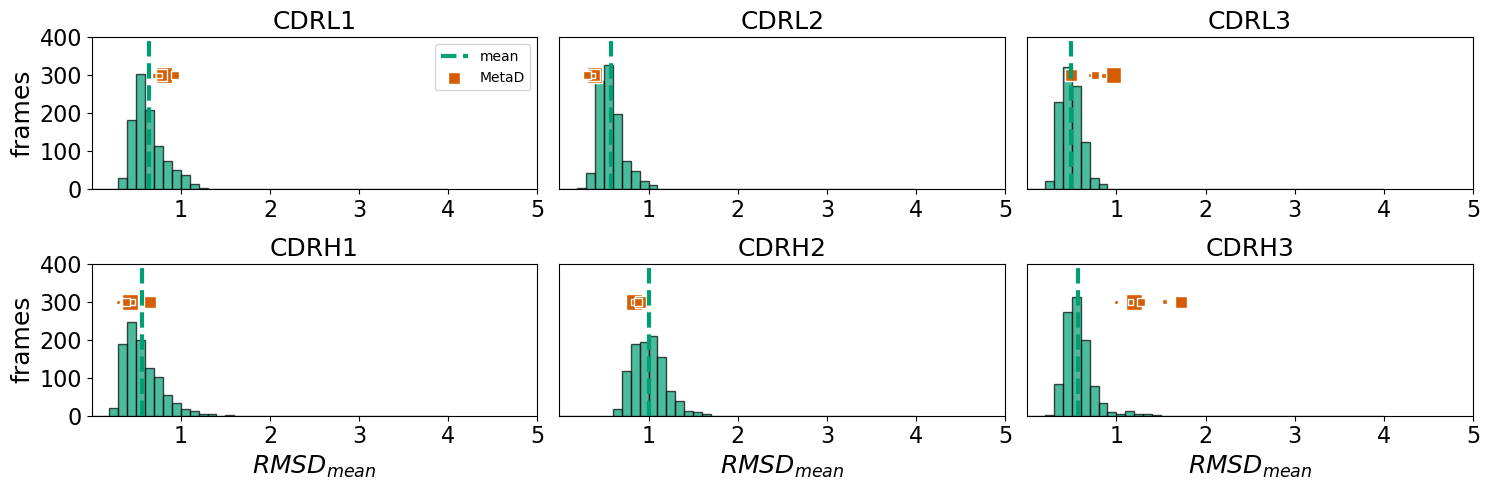

In [299]:
system_name='1JPS'

fig,(axs)=plt.subplots(2,3,figsize=(15,5))

axs=axs.flatten()

counts=axs[0].hist(Rmean_cdr1_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[0].plot([np.mean(Rmean_cdr1_light[2,:]),np.mean(Rmean_cdr1_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='mean')
axs[0].scatter([Rmean_cdr1_light_pdb],[[300 for i in Rmean_cdr1_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00',label='MetaD')
axs[0].legend()

axs[0].set_title('CDRL1',fontsize=18)

counts=axs[1].hist(Rmean_cdr2_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[1].plot([np.mean(Rmean_cdr2_light[2,:]),np.mean(Rmean_cdr2_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[1].scatter([Rmean_cdr2_light_pdb],[[300 for i in Rmean_cdr2_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[1].set_title('CDRL2',fontsize=18)


counts=axs[2].hist(Rmean_cdr3_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[2].plot([np.mean(Rmean_cdr3_light[2,:]),np.mean(Rmean_cdr3_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[2].scatter([Rmean_cdr3_light_pdb],[[300 for i in Rmean_cdr3_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[2].set_title('CDRL3',fontsize=18)


counts=axs[3].hist(Rmean_cdr1_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[3].plot([np.mean(Rmean_cdr1_heavy[2,:]),np.mean(Rmean_cdr1_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[3].scatter([Rmean_cdr1_heavy_pdb],[[300 for i in Rmean_cdr1_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[3].set_title('CDRH1',fontsize=18)


counts=axs[4].hist(Rmean_cdr2_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[4].plot([np.mean(Rmean_cdr2_heavy[2,:]),np.mean(Rmean_cdr2_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[4].scatter([Rmean_cdr2_heavy_pdb],[[300 for i in Rmean_cdr2_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[4].set_title('CDRH2',fontsize=18)


counts=axs[5].hist(Rmean_cdr3_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[5].plot([np.mean(Rmean_cdr3_heavy[2,:]),np.mean(Rmean_cdr3_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[5].scatter([Rmean_cdr3_heavy_pdb],[[300 for i in Rmean_cdr3_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[5].set_title('CDRH3',fontsize=18)

for ax in axs:

    ax.set_xlim(0,5)
    ax.set_ylim(0,400)
    ax.set_yticks([0,100,200,300,400])
    ax.set_yticklabels([0,100,200,300,400],fontsize=16)
    ax.set_xticks([1,2,3,4,5])
    ax.set_xticklabels([1,2,3,4,5],fontsize=16)
axs[3].set_xlabel(r'$RMSD_{mean}$',fontsize=18)
axs[4].set_xlabel(r'$RMSD_{mean}$',fontsize=18)
axs[5].set_xlabel(r'$RMSD_{mean}$',fontsize=18)

axs[0].set_ylabel('frames',fontsize=18)
axs[3].set_ylabel('frames',fontsize=18)
axs[0].legend()

for ax in [axs[1],axs[2],axs[4],axs[5]]:
    ax.set_yticks([])


fig.tight_layout()
plt.savefig(f'../figures/{system_name}_restraints_rmsd_all_cdrs.pdf')

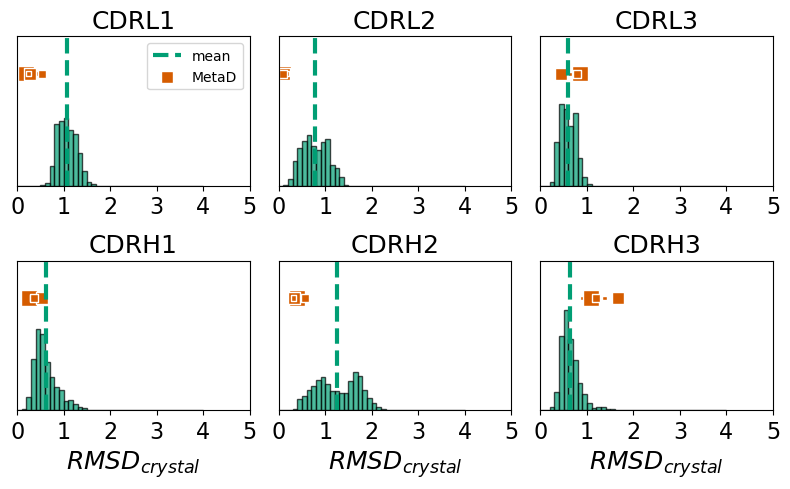

In [300]:
system_name='1JPS'
fig,(axs)=plt.subplots(2,3,figsize=(8,5))

axs=axs.flatten()

counts=axs[0].hist(Rref_cdr1_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[0].plot([np.mean(Rref_cdr1_light[2,:]),np.mean(Rref_cdr1_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='mean')
axs[0].scatter([Rref_cdr1_light_pdb],[[300 for i in Rref_cdr1_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00',label='MetaD')
axs[0].legend(fontsize=18)

axs[0].set_title('CDRL1',fontsize=18)

counts=axs[1].hist(Rref_cdr2_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[1].plot([np.mean(Rref_cdr2_light[2,:]),np.mean(Rref_cdr2_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[1].scatter([Rref_cdr2_light_pdb],[[300 for i in Rref_cdr2_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[1].set_title('CDRL2',fontsize=18)


counts=axs[2].hist(Rref_cdr3_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[2].plot([np.mean(Rref_cdr3_light[2,:]),np.mean(Rref_cdr3_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[2].scatter([Rref_cdr3_light_pdb],[[300 for i in Rref_cdr3_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[2].set_title('CDRL3',fontsize=18)


counts=axs[3].hist(Rref_cdr1_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[3].plot([np.mean(Rref_cdr1_heavy[2,:]),np.mean(Rref_cdr1_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[3].scatter([Rref_cdr1_heavy_pdb],[[300 for i in Rref_cdr1_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[3].set_title('CDRH1',fontsize=18)


counts=axs[4].hist(Rref_cdr2_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[4].plot([np.mean(Rref_cdr2_heavy[2,:]),np.mean(Rref_cdr2_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[4].scatter([Rref_cdr2_heavy_pdb],[[300 for i in Rref_cdr2_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[4].set_title('CDRH2',fontsize=18)


counts=axs[5].hist(Rref_cdr3_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[5].plot([np.mean(Rref_cdr3_heavy[2,:]),np.mean(Rref_cdr3_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[5].scatter([Rref_cdr3_heavy_pdb],[[300 for i in Rref_cdr3_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[5].set_title('CDRH3',fontsize=18)

for ax in axs:

    ax.set_xlim(0,5)
    ax.set_ylim(0,400)
    ax.set_xticks([0,1,2,3,4,5])
    ax.set_xticklabels([0,1,2,3,4,5],fontsize=16)
axs[3].set_xlabel(r'$RMSD_{crystal}$',fontsize=18)
axs[4].set_xlabel(r'$RMSD_{crystal}$',fontsize=18)
axs[5].set_xlabel(r'$RMSD_{crystal}$',fontsize=18)

axs[0].legend()

for ax in axs:
    ax.set_yticks([])
fig.tight_layout()
plt.savefig(f'../figures/{system_name}_restraints_rmsd_ref_cdrs.pdf')

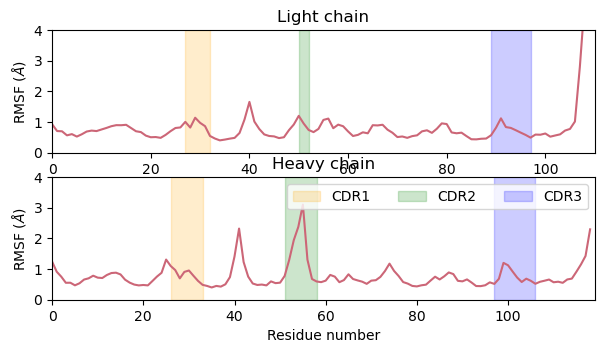

In [302]:
fig,(axs)=plt.subplots(2,1,figsize=(7,3.5))

axs[0].plot([i for i in range(len(res_light))],rmsf_sim_light,color='#CC6677')

axs[0].set_xlabel('Residue number')
axs[0].set_ylabel('RMSF ($\AA$)')
axs[0].axvspan(cv3_cdrs_light_sim[0][0]-start_chain_light,cv3_cdrs_light_sim[0][1]-start_chain_light, zorder=0, alpha=0.2, color='orange', label='CDR1')
axs[0].axvspan(cv3_cdrs_light_sim[1][0]-start_chain_light,cv3_cdrs_light_sim[1][1]-start_chain_light, zorder=0, alpha=0.2, color='green', label='CDR2')
axs[0].axvspan(cv3_cdrs_light_sim[2][0]-start_chain_light,cv3_cdrs_light_sim[2][1]-start_chain_light, zorder=0, alpha=0.2, color='blue', label='CDR3')
axs[0].set_ylim(0,4)
axs[0].set_xlim(0,len(res_light))


axs[1].plot([i for i in range(len(res_heavy))],rmsf_sim_heavy, color='#CC6677')

axs[1].set_xlabel('Residue number')
axs[1].set_ylabel('RMSF ($\AA$)')
axs[1].axvspan(cv3_cdrs_heavy_sim[0][0],cv3_cdrs_heavy_sim[0][1], zorder=0, alpha=0.2, color='orange', label='CDR1')
axs[1].axvspan(cv3_cdrs_heavy_sim[1][0],cv3_cdrs_heavy_sim[1][1], zorder=0, alpha=0.2, color='green', label='CDR2')
axs[1].axvspan(cv3_cdrs_heavy_sim[2][0],cv3_cdrs_heavy_sim[2][1], zorder=0, alpha=0.2, color='blue', label='CDR3')
axs[1].set_ylim(0,4)
axs[1].legend(ncol=3)
axs[1].set_xlim(0,len(res_heavy))

axs[1].set_title('Heavy chain')
axs[0].set_title('Light chain')

plt.savefig(f'../figures/{system_name}_restraints_rmsf_all.pdf')


/var/folders/8w/2dqxrgsd4vj00wv819dcz51w0000gn/T/ipykernel_44258/2441655020.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


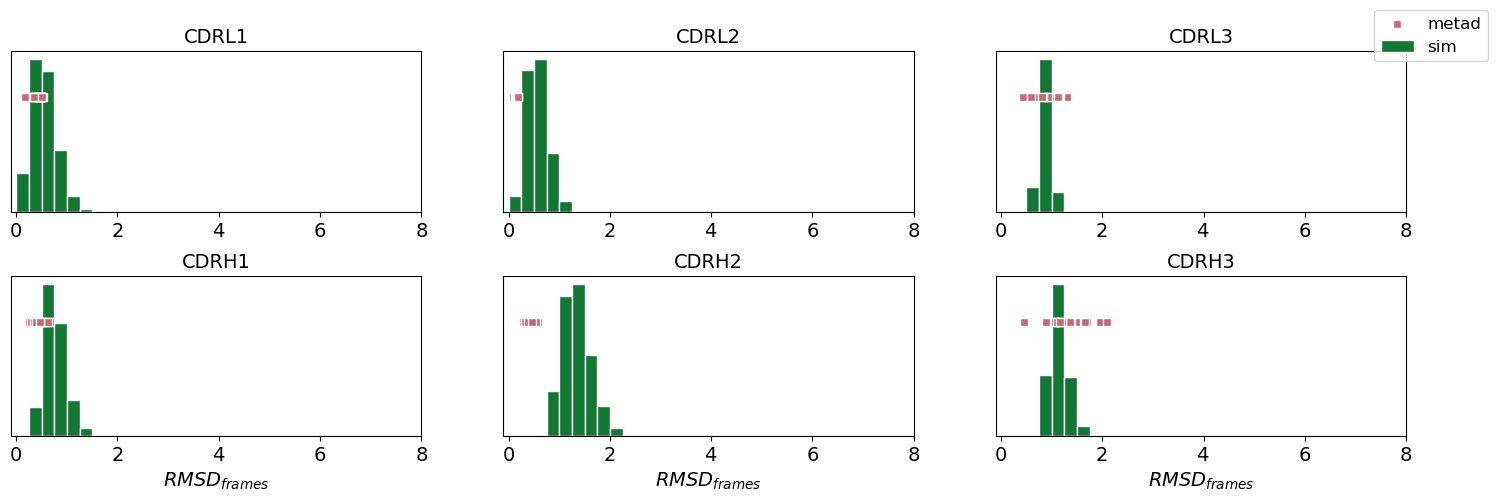

In [303]:
fig, axes = plt.subplots(2, 3, figsize=(18, 5), gridspec_kw={'hspace': 0.4, 'wspace': 0.2})
colors = ['#117733','#CC6677','#AB6D52','gray']  # One color per method
methods = list(rmsd_all_dist.keys())

# Ensure axes is 2D
axes = np.atleast_2d(axes)

for row_idx, chain in enumerate(['light','heavy']):
    for col_idx, cdr in enumerate([1, 2, 3]):
        ax = axes[row_idx, col_idx]

        for method_idx, method in enumerate(methods):
            try:
                data = rmsd_all_dist[method][chain][cdr-1]
                if method == 'pdbs':
                    y = [1.5*(len(methods)-1)] * len(data)
                    ax.scatter(data, y, facecolor=colors[method_idx], edgecolor='white',marker='s', 
                               label=method if row_idx == 0 else "")
                elif method == 'metad':
                    y = [1.5*(len(methods)-1.5)] * len(data)
                    ax.scatter(data, y, facecolor=colors[method_idx], edgecolor='white',marker='s', 
                               label=method if row_idx == 0 else "")
                else:

                    counts, bin_edges = np.histogram(data, bins=40, range=[0, 10.0])
                    pdf = counts / counts.max()
                    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
                    
                    # Plot
                    ax.bar(bin_centers, pdf, width=bin_edges[1] - bin_edges[0], 
                           color=colors[method_idx], edgecolor='w', 
                           label=method if row_idx == 0 else "", 
                           bottom=method_idx * 1.5)
                    ax.plot([0, 10], [method_idx * 1.5, method_idx * 1.5],  color='lightgray', alpha=0.2)
                    
            except KeyError:
                continue

        ax.set_xlim(-0.1, 8)
        ax.set_xticks([0,2,4,6,8])
        ax.set_xticklabels([0,2,4,6,8],fontsize=14)
        ax.set_yticks([])
        if row_idx == 1:
            ax.set_xlabel(r'$ RMSD_{frames}$',fontsize=14)
        
        ax.set_title(f"CDR{chain[0].upper()}{cdr}",fontsize=14)
# Add a legend only once
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.95, 0.98),fontsize=12)

plt.tight_layout()
plt.savefig(f'../figures/{system_name}_sim_metad_rmsd_matrix.pdf')

## 3HI6 - bound

#### load starting pdb and pdbs

In [304]:
folder_dict='../src/extra_pdbs/imgt2cv_dict/'

folder_pdbs=os.path.abspath('../src/extra_pdbs/pdbs_imgt/')
pdbs_all=os.listdir(folder_pdbs)

pdb_list=['3hi6_Fv_HL.pdb', '3hi6_Fv_XY.pdb', '3hi5_Fv_HL.pdb']
chain_list=['HL','XY','HL']

In [305]:
pdb_list

['3hi6_Fv_HL.pdb', '3hi6_Fv_XY.pdb', '3hi5_Fv_HL.pdb']

In [306]:
chain_list

['HL', 'XY', 'HL']

In [307]:
n_pdbs=len(pdb_list)

In [308]:
os.listdir('../src/metaD_clusters/3HI6_clusters/')

['cluster.CL-rep.c9.pdb',
 'cluster.CL-rep.c8.pdb',
 'cluster.CL-rep.c6.pdb',
 'cluster.CL-rep.c7.pdb',
 'cluster.CL-rep.c5.pdb',
 'cluster.CL-rep.c4.pdb',
 'cluster.CL-rep.c0.pdb',
 'cluster.CL-rep.c1.pdb',
 'cluster.CL-rep.c3.pdb',
 'cluster.CL-rep.c2.pdb',
 'cluster.CL-rep.c11.pdb',
 'cluster.CL-rep.c10.pdb']

In [309]:
n_cluster=len(os.listdir('../src/metaD_clusters/3HI6_clusters/'))

In [310]:
dict_prob_cluster={'cluster.CL-rep.c0.pdb':0.33,'cluster.CL-rep.c1.pdb':0.27,'cluster.CL-rep.c2.pdb':0.15,'cluster.CL-rep.c3.pdb':0.08,'cluster.CL-rep.c4.pdb':0.05,'cluster.CL-rep.c5.pdb':0.03,
                  'cluster.CL-rep.c6.pdb':0.03,'cluster.CL-rep.c7.pdb':0.02,'cluster.CL-rep.c8.pdb':0.02,'cluster.CL-rep.c9.pdb':0.01,'cluster.CL-rep.c10.pdb':0.006,'cluster.CL-rep.c11.pdb':0.004}

In [311]:
cluster_pdb_list=os.listdir('../src/metaD_clusters/3HI6_clusters/')
cluster_chain_list=['HL','HL','HL','HL','HL']
cluster_folder_pdbs='../src/metaD_clusters/3HI6_clusters/'
cluster_pdb_prob=np.array([dict_prob_cluster[cluster] for cluster in cluster_pdb_list])

In [312]:
sys_name='3hi6'
pdb_trajectories = [md.load(os.path.join('../src/metaD_clusters/3HI6_clusters/',pdb_name)) for pdb_name in os.listdir('../src/metaD_clusters/3HI6_clusters/')]

# Step 2: Concatenate all into a single trajectory
pdb_traj = md.join(pdb_trajectories)
pdb_traj.save_xtc(f"../src/metaD_clusters/imgt_traj_clusters/{sys_name}joined_pdbs.xtc")

pdb_traj = mda.Universe('../src/metaD_clusters/3HI6_clusters/cluster.CL-rep.c0.pdb',f"../src/metaD_clusters/imgt_traj_clusters/{sys_name}joined_pdbs.xtc")


/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/XDR.py:240: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


In [313]:
rmsd_all_dist={}
rmsd_all_dist['sim']={'heavy':{},'light':{}}
rmsd_all_dist['metad']={'heavy':{},'light':{}}

In [314]:
chain_cluster=['H','L']
for chain_idx,chain_type in enumerate(['heavy','light']):
    for idx_cdr, cdr in enumerate(cdrs_list):
        rmsd_all_dist['metad'][chain_type][idx_cdr]=dist_trajs(pdb_traj,select=f'segid {chain_cluster[chain_idx]} and name CA and resid {cdr[0]-1}:{cdr[1]+1}')
        if len(rmsd_all_dist['metad'][chain_type][idx_cdr]) ==0:
            rmsd_all_dist['metad'][chain_type][idx_cdr]=np.array([0])

### load simulations

In [315]:
top_file = '/Users/bqm193/lavoro/PD_Oxford/OPIG/prj_loop_ensemble_pred/validation_AB_MD_monika/imgt2calvados_relaxed_new/3hi6_Fv_HL.pdb'  # Path to your PDB file
chain_sequences = extract_sequences_by_chain(top_file)

# Print sequences for each chain
for chain_id, sequence in chain_sequences.items():
    print(f"Chain {chain_id} {len(sequence)}: {sequence}")
    if chain_id == 'H':
        res_heavy=sequence
    if chain_id == 'L':
        res_light=sequence

Chain H 120: EVQLLESGGGLVQPGGSLRLSCAASGFTFSRYVMWWVRQAPGKGLEWVSYIWPSGGNTYYADSVKGRFTISRDNSKNTLYLQMNSLRAEDTAVYYCASSYDFWSNAFDIWGQGTMVTVSS
Chain L 106: IQMTQSPSSLSASVGDRVTITCRASQSIGSYLNWYQQKTGKAPKALIYAASSLQSGVPSRFSGSGSGTDFTLTISSLQLEDFATYYCQQSYSTPSFGQGTKVEIKR


In [316]:
sel_chain='HL'
topology_fa = "../src/sims_cv3fv/3hi6_HL/3hi6_Fv_HL_top.pdb"

top_pdb=mda.Universe(topology_fa,topology_fa)

dict_imgt2cv='../src/sims_cv3fv/3hi6_HL/3hi6_dict_Fv_HL.txt'

In [317]:
prefix_sim=os.path.abspath('../src/sims_cv3fv/3hi6_HL/3hi6_Fv_HL')

topology_fa= os.path.join(prefix_sim+"_top.pdb")
xtc_file = os.path.join(prefix_sim+"_aligned.xtc")

mobile = mda.Universe(topology_fa,xtc_file)
ref = mda.Universe(topology_fa,xtc_file)

mobile.trajectory  # set mobile trajectory to last frame
ref.trajectory[0]  # set reference trajectory to first frame

##dict_loc,chain,cdr_boundaries
cv3_cdrs_light_sim=[extract_cdr_coord(dict_imgt2cv,sel_chain[1],cdrs_list[0]),extract_cdr_coord(dict_imgt2cv,sel_chain[1],cdrs_list[1]),extract_cdr_coord(dict_imgt2cv,sel_chain[1],cdrs_list[2])]
cv3_cdrs_heavy_sim=[extract_cdr_coord(dict_imgt2cv,sel_chain[0],cdrs_list[0]),extract_cdr_coord(dict_imgt2cv,sel_chain[0],cdrs_list[1]),extract_cdr_coord(dict_imgt2cv,sel_chain[0],cdrs_list[2])]

In [318]:
Rref_cdr1_light,Rmean_cdr1_light=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_light_sim[0][0]}:{cv3_cdrs_light_sim[0][1]}')
Rref_cdr2_light,Rmean_cdr2_light=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_light_sim[1][0]}:{cv3_cdrs_light_sim[1][1]}')
Rref_cdr3_light,Rmean_cdr3_light=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_light_sim[2][0]}:{cv3_cdrs_light_sim[2][1]}')

Rref_cdr1_heavy,Rmean_cdr1_heavy=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_heavy_sim[0][0]}:{cv3_cdrs_heavy_sim[0][1]}')
Rref_cdr2_heavy,Rmean_cdr2_heavy=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_heavy_sim[1][0]}:{cv3_cdrs_heavy_sim[1][1]}')
Rref_cdr3_heavy,Rmean_cdr3_heavy=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_heavy_sim[2][0]}:{cv3_cdrs_heavy_sim[2][1]}')


/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/memory.py:535: DeprecationWarning: asel argument to timeseries will be renamed to'atomgroup' in 3.0, see #3911
  warnings.warn(


done
done
done
done
done
done


In [319]:
trajectory = md.load(xtc_file
, top=topology_fa)  # Adjust file names/paths as needed

# Light chain
atom_indices = trajectory.topology.select('name CA and chainid 0')
# Restrict the trajectory to the selected atoms
sub_traj = trajectory.atom_slice(atom_indices)
sub_traj.center_coordinates()
rmsf_sim = md.rmsf(sub_traj, sub_traj, 0, precentered=True) *10
rmsd_sim = md.rmsd(sub_traj, sub_traj, 0, precentered=True) *10

rmsf_sim_heavy=rmsf_sim[:len(res_heavy)]
rmsf_sim_light=rmsf_sim[-(len(res_light)):]

In [320]:
# Light chain
atom_indices = trajectory.topology.select(f'name CA and resid >= {cv3_cdrs_light_sim[2][0]} and resid <= {cv3_cdrs_light_sim[2][1]}')
# Restrict the trajectory to the selected atoms
sub_traj_CDRL3_sim = trajectory.atom_slice(atom_indices)
sub_traj_CDRL3_sim.center_coordinates()

# Light chain
atom_indices = trajectory.topology.select(f'name CA and resid >= {cv3_cdrs_heavy_sim[2][0]} and resid <= {cv3_cdrs_heavy_sim[2][1]}')
# Restrict the trajectory to the selected atoms
sub_traj_CDRH3_sim = trajectory.atom_slice(atom_indices)
sub_traj_CDRH3_sim.center_coordinates()

<mdtraj.Trajectory with 1010 frames, 13 atoms, 13 residues, and unitcells at 0x319c7d0f0>

In [321]:
rmsf_cdr1_light_sim=rmsf_sim[(cv3_cdrs_light_sim[0][0]-1):(cv3_cdrs_light_sim[0][1])]
rmsf_cdr2_light_sim=rmsf_sim[(cv3_cdrs_light_sim[1][0]-1):(cv3_cdrs_light_sim[1][1])]
rmsf_cdr3_light_sim=rmsf_sim[(cv3_cdrs_light_sim[2][0]-1):(cv3_cdrs_light_sim[2][1])]

rmsf_cdr1_heavy_sim=rmsf_sim[(cv3_cdrs_heavy_sim[0][0]-1):(cv3_cdrs_heavy_sim[0][1])]
rmsf_cdr2_heavy_sim=rmsf_sim[(cv3_cdrs_heavy_sim[1][0]-1):(cv3_cdrs_heavy_sim[1][1])]
rmsf_cdr3_heavy_sim=rmsf_sim[(cv3_cdrs_heavy_sim[2][0]-1):(cv3_cdrs_heavy_sim[2][1])]

#### rmsd pdbs

In [322]:
Rmean_cdr1_light_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[0][0]-1}:{cv3_cdrs_light_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', 'L')
Rmean_cdr2_light_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[1][0]-1}:{cv3_cdrs_light_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', 'L')
Rmean_cdr3_light_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[2][0]-1}:{cv3_cdrs_light_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', 'L')

Rmean_cdr1_heavy_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[0][0]-1}:{cv3_cdrs_heavy_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', 'H')
Rmean_cdr2_heavy_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[1][0]-1}:{cv3_cdrs_heavy_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', 'H')
Rmean_cdr3_heavy_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[2][0]-1}:{cv3_cdrs_heavy_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', 'H')

/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:777: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


In [323]:
Rref_cdr1_light_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_light_sim[0][0]-1}:{cv3_cdrs_light_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', "L")
Rref_cdr2_light_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_light_sim[1][0]-1}:{cv3_cdrs_light_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', "L")
Rref_cdr3_light_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_light_sim[2][0]-1}:{cv3_cdrs_light_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', "L")

Rref_cdr1_heavy_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_heavy_sim[0][0]-1}:{cv3_cdrs_heavy_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', "H")
Rref_cdr2_heavy_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_heavy_sim[1][0]-1}:{cv3_cdrs_heavy_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', "H")
Rref_cdr3_heavy_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_heavy_sim[2][0]-1}:{cv3_cdrs_heavy_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', "H")

/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/base.py:725: UserWarning: Reader has no dt information, set to 1.0 ps
  return self.ts.dt


In [324]:
Rmetad_cdr1_light_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[0][0]-1}:{cv3_cdrs_light_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', 'L')
Rmetad_cdr2_light_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[1][0]-1}:{cv3_cdrs_light_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', 'L')
Rmetad_cdr3_light_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[2][0]-1}:{cv3_cdrs_light_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', 'L')

Rmetad_cdr1_heavy_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[0][0]-1}:{cv3_cdrs_heavy_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', 'H')
Rmetad_cdr2_heavy_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[1][0]-1}:{cv3_cdrs_heavy_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', 'H')
Rmetad_cdr3_heavy_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[2][0]-1}:{cv3_cdrs_heavy_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', 'H')

1022
1022
1022
1022
1022
1022


In [325]:
chain_sim=['P000','P001']
cdr_sim=[cv3_cdrs_heavy_sim,cv3_cdrs_light_sim]
for chain_idx,chain_type in enumerate(['heavy','light']):
    for idx_cdr, cdr in enumerate(cdrs_list):
        rmsd_all_dist['sim'][chain_type][idx_cdr]=dist_trajs(mobile,select=f'segid {chain_sim[chain_idx]} and name CA and resid {cdr_sim[chain_idx][chain_idx][0]-1}:{cdr_sim[chain_idx][idx_cdr][1]+1}').flatten()

### plots

In [326]:
size_clusters=np.array([250*np.sqrt(dict_prob_cluster[cluster_file]) for cluster_file in reversed(os.listdir('../src/metaD_clusters/3HI6_clusters/'))])

In [327]:
len(size_clusters)

12

In [328]:
start_chain_light=len(res_heavy)

In [329]:
cluster_dot_size=[]
for cluster in os.listdir('../src/metaD_clusters/3HI6_clusters/'):
    cluster_dot_size.append(dict_prob_cluster[cluster])
cluster_dot_size=np.array(cluster_dot_size)

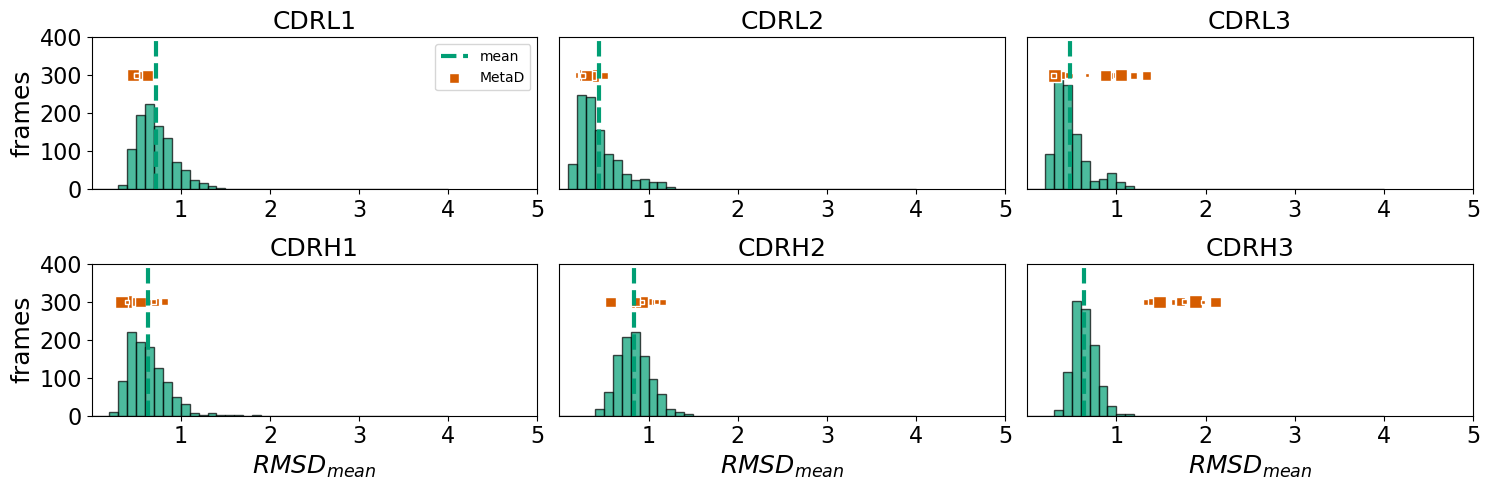

In [330]:
system_name='3HI6'

fig,(axs)=plt.subplots(2,3,figsize=(15,5))

axs=axs.flatten()

counts=axs[0].hist(Rmean_cdr1_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[0].plot([np.mean(Rmean_cdr1_light[2,:]),np.mean(Rmean_cdr1_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='mean')
axs[0].scatter([Rmean_cdr1_light_pdb],[[300 for i in Rmean_cdr1_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00',label='MetaD')
axs[0].legend()

axs[0].set_title('CDRL1',fontsize=18)

counts=axs[1].hist(Rmean_cdr2_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[1].plot([np.mean(Rmean_cdr2_light[2,:]),np.mean(Rmean_cdr2_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[1].scatter([Rmean_cdr2_light_pdb],[[300 for i in Rmean_cdr2_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[1].set_title('CDRL2',fontsize=18)


counts=axs[2].hist(Rmean_cdr3_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[2].plot([np.mean(Rmean_cdr3_light[2,:]),np.mean(Rmean_cdr3_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[2].scatter([Rmean_cdr3_light_pdb],[[300 for i in Rmean_cdr3_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[2].set_title('CDRL3',fontsize=18)


counts=axs[3].hist(Rmean_cdr1_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[3].plot([np.mean(Rmean_cdr1_heavy[2,:]),np.mean(Rmean_cdr1_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[3].scatter([Rmean_cdr1_heavy_pdb],[[300 for i in Rmean_cdr1_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[3].set_title('CDRH1',fontsize=18)


counts=axs[4].hist(Rmean_cdr2_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[4].plot([np.mean(Rmean_cdr2_heavy[2,:]),np.mean(Rmean_cdr2_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[4].scatter([Rmean_cdr2_heavy_pdb],[[300 for i in Rmean_cdr2_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[4].set_title('CDRH2',fontsize=18)


counts=axs[5].hist(Rmean_cdr3_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[5].plot([np.mean(Rmean_cdr3_heavy[2,:]),np.mean(Rmean_cdr3_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[5].scatter([Rmean_cdr3_heavy_pdb],[[300 for i in Rmean_cdr3_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[5].set_title('CDRH3',fontsize=18)

for ax in axs:

    ax.set_xlim(0,5)
    ax.set_ylim(0,400)
    ax.set_yticks([0,100,200,300,400])
    ax.set_yticklabels([0,100,200,300,400],fontsize=16)
    ax.set_xticks([1,2,3,4,5])
    ax.set_xticklabels([1,2,3,4,5],fontsize=16)
axs[3].set_xlabel(r'$RMSD_{mean}$',fontsize=18)
axs[4].set_xlabel(r'$RMSD_{mean}$',fontsize=18)
axs[5].set_xlabel(r'$RMSD_{mean}$',fontsize=18)

axs[0].set_ylabel('frames',fontsize=18)
axs[3].set_ylabel('frames',fontsize=18)
axs[0].legend()

for ax in [axs[1],axs[2],axs[4],axs[5]]:
    ax.set_yticks([])


fig.tight_layout()
plt.savefig(f'../figures/{system_name}_restraints_rmsd_all_cdrs.pdf')

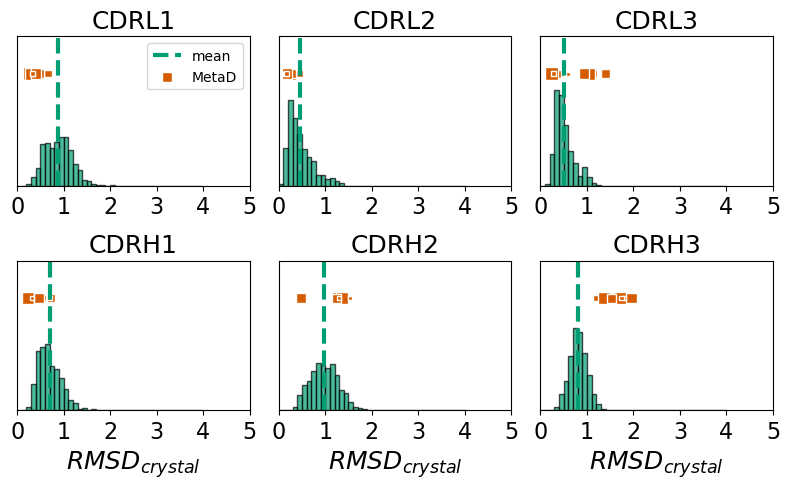

In [331]:
system_name='3HI6'

fig,(axs)=plt.subplots(2,3,figsize=(8,5))

axs=axs.flatten()

counts=axs[0].hist(Rref_cdr1_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[0].plot([np.mean(Rref_cdr1_light[2,:]),np.mean(Rref_cdr1_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='mean')
axs[0].scatter([Rref_cdr1_light_pdb],[[300 for i in Rref_cdr1_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00',label='MetaD')
axs[0].legend(fontsize=18)

axs[0].set_title('CDRL1',fontsize=18)

counts=axs[1].hist(Rref_cdr2_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[1].plot([np.mean(Rref_cdr2_light[2,:]),np.mean(Rref_cdr2_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[1].scatter([Rref_cdr2_light_pdb],[[300 for i in Rref_cdr2_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[1].set_title('CDRL2',fontsize=18)


counts=axs[2].hist(Rref_cdr3_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[2].plot([np.mean(Rref_cdr3_light[2,:]),np.mean(Rref_cdr3_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[2].scatter([Rref_cdr3_light_pdb],[[300 for i in Rref_cdr3_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[2].set_title('CDRL3',fontsize=18)


counts=axs[3].hist(Rref_cdr1_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[3].plot([np.mean(Rref_cdr1_heavy[2,:]),np.mean(Rref_cdr1_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[3].scatter([Rref_cdr1_heavy_pdb],[[300 for i in Rref_cdr1_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[3].set_title('CDRH1',fontsize=18)


counts=axs[4].hist(Rref_cdr2_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[4].plot([np.mean(Rref_cdr2_heavy[2,:]),np.mean(Rref_cdr2_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[4].scatter([Rref_cdr2_heavy_pdb],[[300 for i in Rref_cdr2_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[4].set_title('CDRH2',fontsize=18)


counts=axs[5].hist(Rref_cdr3_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[5].plot([np.mean(Rref_cdr3_heavy[2,:]),np.mean(Rref_cdr3_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[5].scatter([Rref_cdr3_heavy_pdb],[[300 for i in Rref_cdr3_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[5].set_title('CDRH3',fontsize=18)

for ax in axs:

    ax.set_xlim(0,5)
    ax.set_ylim(0,400)
    ax.set_xticks([0,1,2,3,4,5])
    ax.set_xticklabels([0,1,2,3,4,5],fontsize=16)
axs[3].set_xlabel(r'$RMSD_{crystal}$',fontsize=18)
axs[4].set_xlabel(r'$RMSD_{crystal}$',fontsize=18)
axs[5].set_xlabel(r'$RMSD_{crystal}$',fontsize=18)

axs[0].legend()

for ax in axs:
    ax.set_yticks([])
fig.tight_layout()
plt.savefig(f'../figures/{system_name}_restraints_rmsd_ref_cdrs.pdf')

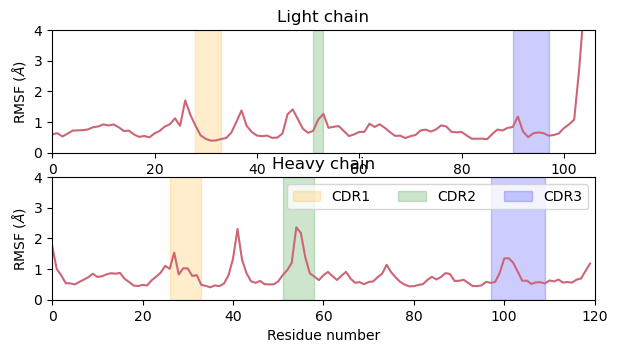

In [332]:
fig,(axs)=plt.subplots(2,1,figsize=(7,3.5))

axs[0].plot([i for i in range(len(res_light))],rmsf_sim_light,color='#CC6677')

axs[0].set_xlabel('Residue number')
axs[0].set_ylabel('RMSF ($\AA$)')
axs[0].axvspan(cv3_cdrs_light_sim[0][0]-start_chain_light,cv3_cdrs_light_sim[0][1]-start_chain_light, zorder=0, alpha=0.2, color='orange', label='CDR1')
axs[0].axvspan(cv3_cdrs_light_sim[1][0]-start_chain_light,cv3_cdrs_light_sim[1][1]-start_chain_light, zorder=0, alpha=0.2, color='green', label='CDR2')
axs[0].axvspan(cv3_cdrs_light_sim[2][0]-start_chain_light,cv3_cdrs_light_sim[2][1]-start_chain_light, zorder=0, alpha=0.2, color='blue', label='CDR3')
axs[0].set_ylim(0,4)
axs[0].set_xlim(0,len(res_light))


axs[1].plot([i for i in range(len(res_heavy))],rmsf_sim_heavy, color='#CC6677')

axs[1].set_xlabel('Residue number')
axs[1].set_ylabel('RMSF ($\AA$)')
axs[1].axvspan(cv3_cdrs_heavy_sim[0][0],cv3_cdrs_heavy_sim[0][1], zorder=0, alpha=0.2, color='orange', label='CDR1')
axs[1].axvspan(cv3_cdrs_heavy_sim[1][0],cv3_cdrs_heavy_sim[1][1], zorder=0, alpha=0.2, color='green', label='CDR2')
axs[1].axvspan(cv3_cdrs_heavy_sim[2][0],cv3_cdrs_heavy_sim[2][1], zorder=0, alpha=0.2, color='blue', label='CDR3')
axs[1].set_ylim(0,4)
axs[1].legend(ncol=3)
axs[1].set_xlim(0,len(res_heavy))

axs[1].set_title('Heavy chain')
axs[0].set_title('Light chain')

plt.savefig(f'../figures/{system_name}_restraints_rmsf_all.pdf')


/var/folders/8w/2dqxrgsd4vj00wv819dcz51w0000gn/T/ipykernel_44258/2441655020.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


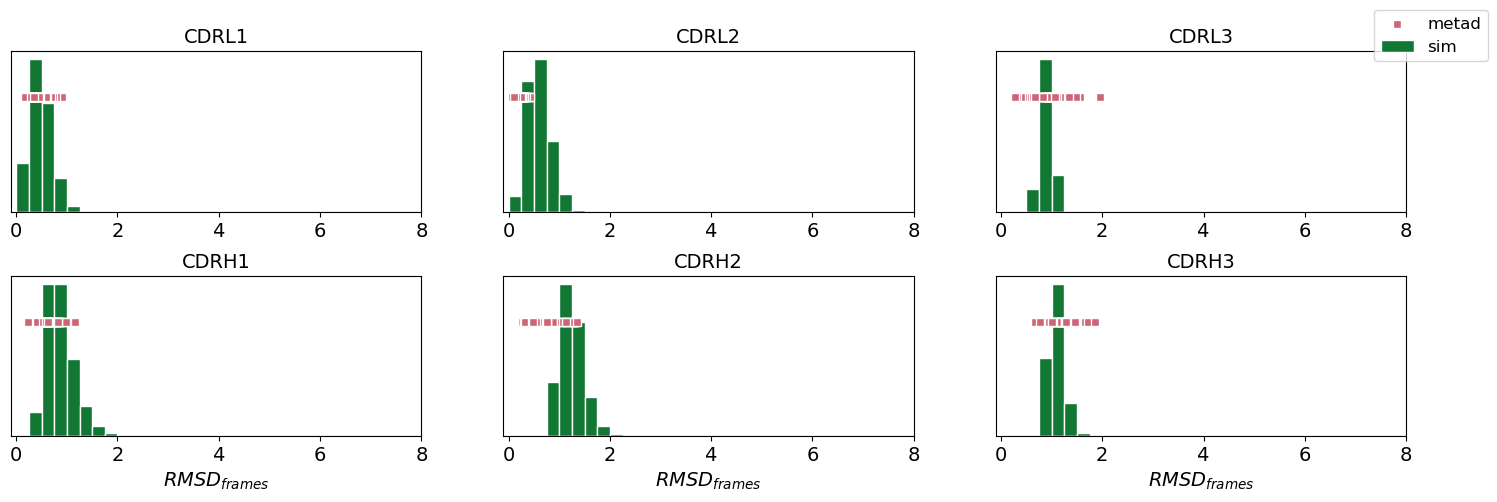

In [333]:
fig, axes = plt.subplots(2, 3, figsize=(18, 5), gridspec_kw={'hspace': 0.4, 'wspace': 0.2})
colors = ['#117733','#CC6677','#AB6D52','gray']  # One color per method
methods = list(rmsd_all_dist.keys())

# Ensure axes is 2D
axes = np.atleast_2d(axes)

for row_idx, chain in enumerate(['light','heavy']):
    for col_idx, cdr in enumerate([1, 2, 3]):
        ax = axes[row_idx, col_idx]

        for method_idx, method in enumerate(methods):
            try:
                data = rmsd_all_dist[method][chain][cdr-1]
                if method == 'pdbs':
                    y = [1.5*(len(methods)-1)] * len(data)
                    ax.scatter(data, y, facecolor=colors[method_idx], edgecolor='white',marker='s', 
                               label=method if row_idx == 0 else "")
                elif method == 'metad':
                    y = [1.5*(len(methods)-1.5)] * len(data)
                    ax.scatter(data, y, facecolor=colors[method_idx], edgecolor='white',marker='s', 
                               label=method if row_idx == 0 else "")
                else:

                    counts, bin_edges = np.histogram(data, bins=40, range=[0, 10.0])
                    pdf = counts / counts.max()
                    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
                    
                    # Plot
                    ax.bar(bin_centers, pdf, width=bin_edges[1] - bin_edges[0], 
                           color=colors[method_idx], edgecolor='w', 
                           label=method if row_idx == 0 else "", 
                           bottom=method_idx * 1.5)
                    ax.plot([0, 10], [method_idx * 1.5, method_idx * 1.5],  color='lightgray', alpha=0.2)
                    
            except KeyError:
                continue

        ax.set_xlim(-0.1, 8)
        ax.set_xticks([0,2,4,6,8])
        ax.set_xticklabels([0,2,4,6,8],fontsize=14)
        ax.set_yticks([])
        if row_idx == 1:
            ax.set_xlabel(r'$ RMSD_{frames}$',fontsize=14)
        
        ax.set_title(f"CDR{chain[0].upper()}{cdr}",fontsize=14)
# Add a legend only once
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.95, 0.98),fontsize=12)

plt.tight_layout()
plt.savefig(f'../figures/{system_name}_sim_metad_rmsd_matrix.pdf')

## 2Y06 - bound

#### load starting pdb

In [334]:
dict_cv2imgt='../src/sims_cv3fv/2y06_HL/2y06_dict_Fv_HL.txt'

pdb_start=os.path.abspath('../src/sims_cv3fv/2y06_HL/2y06_Fv_HL.pdb')

chain_list='HL'

In [335]:
chain_list

'HL'

In [336]:
os.listdir('../src/metaD_clusters/2Y06_clusters/')

['cluster_4.pdb',
 'cluster_5.pdb',
 'cluster_7.pdb',
 'cluster_6.pdb',
 'cluster_2.pdb',
 'cluster_3.pdb',
 'cluster_1.pdb',
 'cluster_0.pdb']

In [337]:
n_cluster=len(os.listdir('../src/metaD_clusters/2Y06_clusters/'))

In [338]:
dict_prob_cluster={'cluster_0.pdb':0.43,'cluster_1.pdb':0.22,'cluster_2.pdb':0.14,'cluster_3.pdb':0.12,'cluster_4.pdb':0.05,'cluster_5.pdb':0.02,'cluster_6.pdb':0.01,'cluster_7.pdb':0.01}

In [339]:
cluster_pdb_list=os.listdir('../src/metaD_clusters/2Y06_clusters/')
cluster_chain_list=['HL','HL','HL','HL','HL']
cluster_folder_pdbs='../src/metaD_clusters/2Y06_clusters/'
cluster_pdb_prob=np.array([dict_prob_cluster[cluster] for cluster in cluster_pdb_list])

In [340]:
sys_name='2y06'
pdb_trajectories = [md.load(os.path.join('../src/metaD_clusters/2Y06_clusters/',pdb_name)) for pdb_name in os.listdir('../src/metaD_clusters/2Y06_clusters/')]

# Step 2: Concatenate all into a single trajectory
pdb_traj = md.join(pdb_trajectories)
pdb_traj.save_xtc(f"../src/metaD_clusters/imgt_traj_clusters/{sys_name}joined_pdbs.xtc")

pdb_traj = mda.Universe('../src/metaD_clusters/2Y06_clusters/cluster_0.pdb',f"../src/metaD_clusters/imgt_traj_clusters/{sys_name}joined_pdbs.xtc")

/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/XDR.py:240: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


In [341]:
rmsd_all_dist={}
rmsd_all_dist['sim']={'heavy':{},'light':{}}
rmsd_all_dist['metad']={'heavy':{},'light':{}}

In [342]:
chain_cluster=['H','L']
for chain_idx,chain_type in enumerate(['heavy','light']):
    for idx_cdr, cdr in enumerate(cdrs_list):
        rmsd_all_dist['metad'][chain_type][idx_cdr]=dist_trajs(pdb_traj,select=f'segid {chain_cluster[chain_idx]} and name CA and resid {cdr[0]-1}:{cdr[1]+1}')
        if len(rmsd_all_dist['metad'][chain_type][idx_cdr]) ==0:
            rmsd_all_dist['metad'][chain_type][idx_cdr]=np.array([0])

### load simulations

In [343]:
top_file = '../src/sims_cv3fv/2y06_HL/2y06_Fv_HL.pdb'  # Path to your PDB file
chain_sequences = extract_sequences_by_chain(top_file)

# Print sequences for each chain
for chain_id, sequence in chain_sequences.items():
    print(f"Chain {chain_id} {len(sequence)}: {sequence}")
    if chain_id == 'H':
        res_heavy=sequence
    if chain_id == 'L':
        res_light=sequence

Chain H 122: QVQLQQPGAELVKPGASVKLSCKASGYTFTSYWMHWVKQRPGRGLEWIGRIDPNSGGTAYNEKFKSKATLTVDKPSSTAYMALSSLTSADSAVYYCARYDYYGGSYFDYWGQGTTLTVSSGG
Chain L 112: QAVVTQESALTTSPGETVTLTCRSSTGAVTTSNYANWVQEKPDHLFTGLIGGTNNRAPGVPARFSGSLIGDKAALTITGGQTEDEAIYFCALWYSNHWVFGGGTKLTVLGQP


In [344]:
sel_chain='HL'
topology_fa = "../src/sims_cv3fv/2y06_HL/2y06_Fv_HL_top.pdb"

top_pdb=mda.Universe(topology_fa,topology_fa)

dict_imgt2cv='../src/sims_cv3fv/2y06_HL/2y06_dict_Fv_HL.txt'

In [345]:
prefix_sim=os.path.abspath('../src/sims_cv3fv/2y06_HL/2y06_Fv_HL')
topology_fa= os.path.join(prefix_sim+"_top.pdb")
xtc_file = os.path.join(prefix_sim+"_aligned.xtc")

mobile = mda.Universe(topology_fa,xtc_file)
ref = mda.Universe(topology_fa,xtc_file)

mobile.trajectory  # set mobile trajectory to last frame
ref.trajectory[0]  # set reference trajectory to first frame

##dict_loc,chain,cdr_boundaries
cv3_cdrs_light_sim=[extract_cdr_coord(dict_imgt2cv,sel_chain[1],cdrs_list[0]),extract_cdr_coord(dict_imgt2cv,sel_chain[1],cdrs_list[1]),extract_cdr_coord(dict_imgt2cv,sel_chain[1],cdrs_list[2])]
cv3_cdrs_heavy_sim=[extract_cdr_coord(dict_imgt2cv,sel_chain[0],cdrs_list[0]),extract_cdr_coord(dict_imgt2cv,sel_chain[0],cdrs_list[1]),extract_cdr_coord(dict_imgt2cv,sel_chain[0],cdrs_list[2])]

In [346]:
Rref_cdr1_light,Rmean_cdr1_light=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_light_sim[0][0]}:{cv3_cdrs_light_sim[0][1]}')
Rref_cdr2_light,Rmean_cdr2_light=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_light_sim[1][0]}:{cv3_cdrs_light_sim[1][1]}')
Rref_cdr3_light,Rmean_cdr3_light=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_light_sim[2][0]}:{cv3_cdrs_light_sim[2][1]}')

Rref_cdr1_heavy,Rmean_cdr1_heavy=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_heavy_sim[0][0]}:{cv3_cdrs_heavy_sim[0][1]}')
Rref_cdr2_heavy,Rmean_cdr2_heavy=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_heavy_sim[1][0]}:{cv3_cdrs_heavy_sim[1][1]}')
Rref_cdr3_heavy,Rmean_cdr3_heavy=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_heavy_sim[2][0]}:{cv3_cdrs_heavy_sim[2][1]}')


/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/memory.py:535: DeprecationWarning: asel argument to timeseries will be renamed to'atomgroup' in 3.0, see #3911
  warnings.warn(


done
done
done
done
done
done


In [347]:
trajectory = md.load(xtc_file
, top=topology_fa)  # Adjust file names/paths as needed

# Light chain
atom_indices = trajectory.topology.select('name CA and chainid 0')
# Restrict the trajectory to the selected atoms
sub_traj = trajectory.atom_slice(atom_indices)
sub_traj.center_coordinates()
rmsf_sim = md.rmsf(sub_traj, sub_traj, 0, precentered=True) *10
rmsd_sim = md.rmsd(sub_traj, sub_traj, 0, precentered=True) *10

rmsf_sim_heavy=rmsf_sim[:len(res_heavy)]
rmsf_sim_light=rmsf_sim[-(len(res_light)):]

In [348]:
# Light chain
atom_indices = trajectory.topology.select(f'name CA and resid >= {cv3_cdrs_light_sim[2][0]} and resid <= {cv3_cdrs_light_sim[2][1]}')
# Restrict the trajectory to the selected atoms
sub_traj_CDRL3_sim = trajectory.atom_slice(atom_indices)
sub_traj_CDRL3_sim.center_coordinates()

# Light chain
atom_indices = trajectory.topology.select(f'name CA and resid >= {cv3_cdrs_heavy_sim[2][0]} and resid <= {cv3_cdrs_heavy_sim[2][1]}')
# Restrict the trajectory to the selected atoms
sub_traj_CDRH3_sim = trajectory.atom_slice(atom_indices)
sub_traj_CDRH3_sim.center_coordinates()

<mdtraj.Trajectory with 1010 frames, 13 atoms, 13 residues, and unitcells at 0x319f37d30>

In [349]:
rmsf_cdr1_light_sim=rmsf_sim[(cv3_cdrs_light_sim[0][0]-1):(cv3_cdrs_light_sim[0][1])]
rmsf_cdr2_light_sim=rmsf_sim[(cv3_cdrs_light_sim[1][0]-1):(cv3_cdrs_light_sim[1][1])]
rmsf_cdr3_light_sim=rmsf_sim[(cv3_cdrs_light_sim[2][0]-1):(cv3_cdrs_light_sim[2][1])]

rmsf_cdr1_heavy_sim=rmsf_sim[(cv3_cdrs_heavy_sim[0][0]-1):(cv3_cdrs_heavy_sim[0][1])]
rmsf_cdr2_heavy_sim=rmsf_sim[(cv3_cdrs_heavy_sim[1][0]-1):(cv3_cdrs_heavy_sim[1][1])]
rmsf_cdr3_heavy_sim=rmsf_sim[(cv3_cdrs_heavy_sim[2][0]-1):(cv3_cdrs_heavy_sim[2][1])]

#### rmsd pdbs

In [350]:
Rmean_cdr1_light_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[0][0]-1}:{cv3_cdrs_light_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', 'L')
Rmean_cdr2_light_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[1][0]-1}:{cv3_cdrs_light_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', 'L')
Rmean_cdr3_light_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[2][0]-1}:{cv3_cdrs_light_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', 'L')

Rmean_cdr1_heavy_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[0][0]-1}:{cv3_cdrs_heavy_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', 'H')
Rmean_cdr2_heavy_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[1][0]-1}:{cv3_cdrs_heavy_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', 'H')
Rmean_cdr3_heavy_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[2][0]-1}:{cv3_cdrs_heavy_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', 'H')

/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:777: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


In [351]:
Rref_cdr1_light_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_light_sim[0][0]-1}:{cv3_cdrs_light_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', "L")
Rref_cdr2_light_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_light_sim[1][0]-1}:{cv3_cdrs_light_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', "L")
Rref_cdr3_light_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_light_sim[2][0]-1}:{cv3_cdrs_light_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', "L")

Rref_cdr1_heavy_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_heavy_sim[0][0]-1}:{cv3_cdrs_heavy_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', "H")
Rref_cdr2_heavy_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_heavy_sim[1][0]-1}:{cv3_cdrs_heavy_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', "H")
Rref_cdr3_heavy_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_heavy_sim[2][0]-1}:{cv3_cdrs_heavy_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', "H")

/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/base.py:725: UserWarning: Reader has no dt information, set to 1.0 ps
  return self.ts.dt


In [352]:
Rmetad_cdr1_light_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[0][0]-1}:{cv3_cdrs_light_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', 'L')
Rmetad_cdr2_light_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[1][0]-1}:{cv3_cdrs_light_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', 'L')
Rmetad_cdr3_light_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[2][0]-1}:{cv3_cdrs_light_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', 'L')

Rmetad_cdr1_heavy_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[0][0]-1}:{cv3_cdrs_heavy_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', 'H')
Rmetad_cdr2_heavy_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[1][0]-1}:{cv3_cdrs_heavy_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', 'H')
Rmetad_cdr3_heavy_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[2][0]-1}:{cv3_cdrs_heavy_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', 'H')

1018
1018
1018
1018
1018
1018


In [353]:
chain_sim=['P000','P001']
cdr_sim=[cv3_cdrs_heavy_sim,cv3_cdrs_light_sim]
for chain_idx,chain_type in enumerate(['heavy','light']):
    for idx_cdr, cdr in enumerate(cdrs_list):
        rmsd_all_dist['sim'][chain_type][idx_cdr]=dist_trajs(mobile,select=f'segid {chain_sim[chain_idx]} and name CA and resid {cdr_sim[chain_idx][chain_idx][0]-1}:{cdr_sim[chain_idx][idx_cdr][1]+1}').flatten()

### plots

In [354]:
size_clusters=np.array([250*np.sqrt(dict_prob_cluster[cluster_file]) for cluster_file in reversed(os.listdir('../src/metaD_clusters/2Y06_clusters/'))])

In [355]:
len(size_clusters)

8

In [356]:
start_chain_light=len(res_heavy)

In [357]:
cluster_dot_size=[]
for cluster in os.listdir('../src/metaD_clusters/2Y06_clusters/'):
    cluster_dot_size.append(dict_prob_cluster[cluster])
cluster_dot_size=np.array(cluster_dot_size)

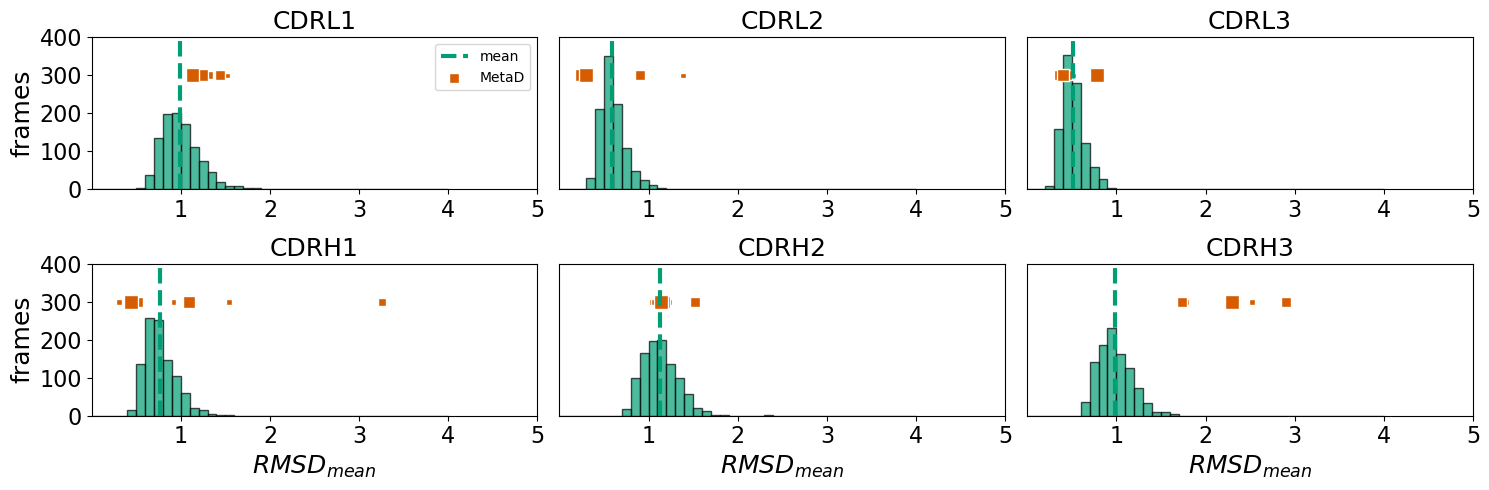

In [358]:
system_name='2Y06'
fig,(axs)=plt.subplots(2,3,figsize=(15,5))

axs=axs.flatten()

counts=axs[0].hist(Rmean_cdr1_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[0].plot([np.mean(Rmean_cdr1_light[2,:]),np.mean(Rmean_cdr1_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='mean')
axs[0].scatter([Rmean_cdr1_light_pdb],[[300 for i in Rmean_cdr1_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00',label='MetaD')
axs[0].legend()

axs[0].set_title('CDRL1',fontsize=18)

counts=axs[1].hist(Rmean_cdr2_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[1].plot([np.mean(Rmean_cdr2_light[2,:]),np.mean(Rmean_cdr2_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[1].scatter([Rmean_cdr2_light_pdb],[[300 for i in Rmean_cdr2_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[1].set_title('CDRL2',fontsize=18)


counts=axs[2].hist(Rmean_cdr3_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[2].plot([np.mean(Rmean_cdr3_light[2,:]),np.mean(Rmean_cdr3_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[2].scatter([Rmean_cdr3_light_pdb],[[300 for i in Rmean_cdr3_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[2].set_title('CDRL3',fontsize=18)


counts=axs[3].hist(Rmean_cdr1_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[3].plot([np.mean(Rmean_cdr1_heavy[2,:]),np.mean(Rmean_cdr1_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[3].scatter([Rmean_cdr1_heavy_pdb],[[300 for i in Rmean_cdr1_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[3].set_title('CDRH1',fontsize=18)


counts=axs[4].hist(Rmean_cdr2_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[4].plot([np.mean(Rmean_cdr2_heavy[2,:]),np.mean(Rmean_cdr2_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[4].scatter([Rmean_cdr2_heavy_pdb],[[300 for i in Rmean_cdr2_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[4].set_title('CDRH2',fontsize=18)


counts=axs[5].hist(Rmean_cdr3_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[5].plot([np.mean(Rmean_cdr3_heavy[2,:]),np.mean(Rmean_cdr3_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[5].scatter([Rmean_cdr3_heavy_pdb],[[300 for i in Rmean_cdr3_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[5].set_title('CDRH3',fontsize=18)

for ax in axs:

    ax.set_xlim(0,5)
    ax.set_ylim(0,400)
    ax.set_yticks([0,100,200,300,400])
    ax.set_yticklabels([0,100,200,300,400],fontsize=16)
    ax.set_xticks([1,2,3,4,5])
    ax.set_xticklabels([1,2,3,4,5],fontsize=16)
axs[3].set_xlabel(r'$RMSD_{mean}$',fontsize=18)
axs[4].set_xlabel(r'$RMSD_{mean}$',fontsize=18)
axs[5].set_xlabel(r'$RMSD_{mean}$',fontsize=18)

axs[0].set_ylabel('frames',fontsize=18)
axs[3].set_ylabel('frames',fontsize=18)
axs[0].legend()

for ax in [axs[1],axs[2],axs[4],axs[5]]:
    ax.set_yticks([])


fig.tight_layout()
plt.savefig(f'../figures/{system_name}_restraints_rmsd_all_cdrs.pdf')

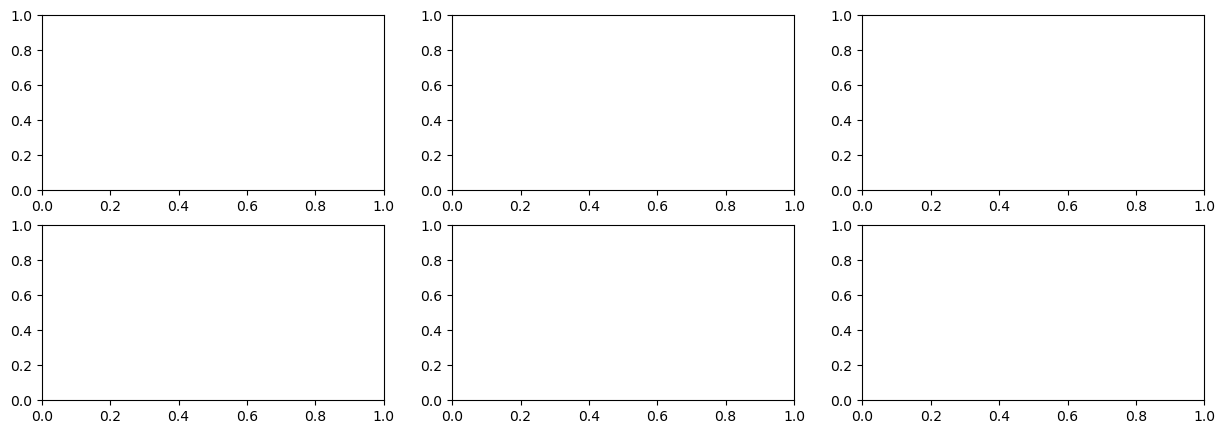

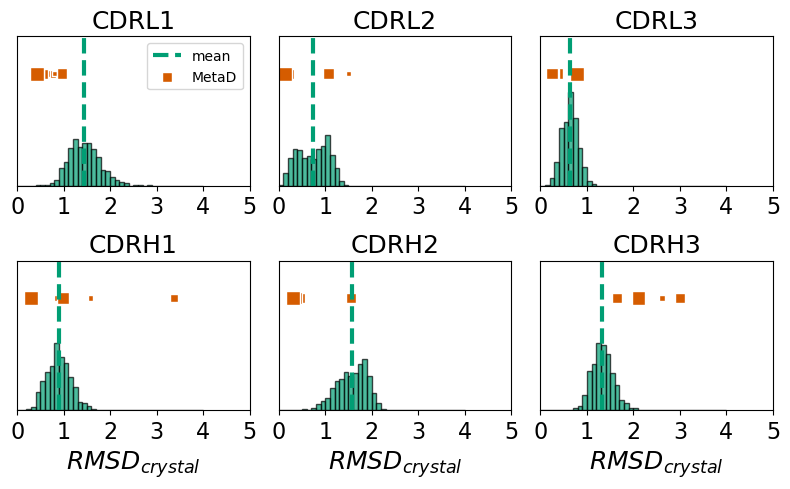

In [359]:
system_name='2Y06'
fig,(axs)=plt.subplots(2,3,figsize=(15,5))

fig,(axs)=plt.subplots(2,3,figsize=(8,5))

axs=axs.flatten()

counts=axs[0].hist(Rref_cdr1_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[0].plot([np.mean(Rref_cdr1_light[2,:]),np.mean(Rref_cdr1_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='mean')
axs[0].scatter([Rref_cdr1_light_pdb],[[300 for i in Rref_cdr1_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00',label='MetaD')
axs[0].legend(fontsize=18)

axs[0].set_title('CDRL1',fontsize=18)

counts=axs[1].hist(Rref_cdr2_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[1].plot([np.mean(Rref_cdr2_light[2,:]),np.mean(Rref_cdr2_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[1].scatter([Rref_cdr2_light_pdb],[[300 for i in Rref_cdr2_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[1].set_title('CDRL2',fontsize=18)


counts=axs[2].hist(Rref_cdr3_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[2].plot([np.mean(Rref_cdr3_light[2,:]),np.mean(Rref_cdr3_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[2].scatter([Rref_cdr3_light_pdb],[[300 for i in Rref_cdr3_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[2].set_title('CDRL3',fontsize=18)


counts=axs[3].hist(Rref_cdr1_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[3].plot([np.mean(Rref_cdr1_heavy[2,:]),np.mean(Rref_cdr1_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[3].scatter([Rref_cdr1_heavy_pdb],[[300 for i in Rref_cdr1_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[3].set_title('CDRH1',fontsize=18)


counts=axs[4].hist(Rref_cdr2_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[4].plot([np.mean(Rref_cdr2_heavy[2,:]),np.mean(Rref_cdr2_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[4].scatter([Rref_cdr2_heavy_pdb],[[300 for i in Rref_cdr2_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[4].set_title('CDRH2',fontsize=18)


counts=axs[5].hist(Rref_cdr3_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[5].plot([np.mean(Rref_cdr3_heavy[2,:]),np.mean(Rref_cdr3_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[5].scatter([Rref_cdr3_heavy_pdb],[[300 for i in Rref_cdr3_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[5].set_title('CDRH3',fontsize=18)

for ax in axs:

    ax.set_xlim(0,5)
    ax.set_ylim(0,400)
    ax.set_xticks([0,1,2,3,4,5])
    ax.set_xticklabels([0,1,2,3,4,5],fontsize=16)
axs[3].set_xlabel(r'$RMSD_{crystal}$',fontsize=18)
axs[4].set_xlabel(r'$RMSD_{crystal}$',fontsize=18)
axs[5].set_xlabel(r'$RMSD_{crystal}$',fontsize=18)

axs[0].legend()

for ax in axs:
    ax.set_yticks([])
fig.tight_layout()
plt.savefig(f'../figures/{system_name}_restraints_rmsd_ref_cdrs.pdf')

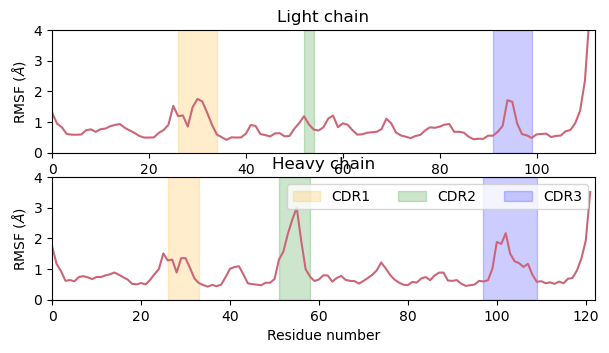

In [360]:
fig,(axs)=plt.subplots(2,1,figsize=(7,3.5))

axs[0].plot([i for i in range(len(res_light))],rmsf_sim_light,color='#CC6677')

axs[0].set_xlabel('Residue number')
axs[0].set_ylabel('RMSF ($\AA$)')
axs[0].axvspan(cv3_cdrs_light_sim[0][0]-start_chain_light,cv3_cdrs_light_sim[0][1]-start_chain_light, zorder=0, alpha=0.2, color='orange', label='CDR1')
axs[0].axvspan(cv3_cdrs_light_sim[1][0]-start_chain_light,cv3_cdrs_light_sim[1][1]-start_chain_light, zorder=0, alpha=0.2, color='green', label='CDR2')
axs[0].axvspan(cv3_cdrs_light_sim[2][0]-start_chain_light,cv3_cdrs_light_sim[2][1]-start_chain_light, zorder=0, alpha=0.2, color='blue', label='CDR3')
axs[0].set_ylim(0,4)
axs[0].set_xlim(0,len(res_light))


axs[1].plot([i for i in range(len(res_heavy))],rmsf_sim_heavy, color='#CC6677')

axs[1].set_xlabel('Residue number')
axs[1].set_ylabel('RMSF ($\AA$)')
axs[1].axvspan(cv3_cdrs_heavy_sim[0][0],cv3_cdrs_heavy_sim[0][1], zorder=0, alpha=0.2, color='orange', label='CDR1')
axs[1].axvspan(cv3_cdrs_heavy_sim[1][0],cv3_cdrs_heavy_sim[1][1], zorder=0, alpha=0.2, color='green', label='CDR2')
axs[1].axvspan(cv3_cdrs_heavy_sim[2][0],cv3_cdrs_heavy_sim[2][1], zorder=0, alpha=0.2, color='blue', label='CDR3')
axs[1].set_ylim(0,4)
axs[1].legend(ncol=3)
axs[1].set_xlim(0,len(res_heavy))

axs[1].set_title('Heavy chain')
axs[0].set_title('Light chain')
plt.savefig(f'../figures/{system_name}_restraints_rmsf_all.pdf')

/var/folders/8w/2dqxrgsd4vj00wv819dcz51w0000gn/T/ipykernel_44258/2441655020.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


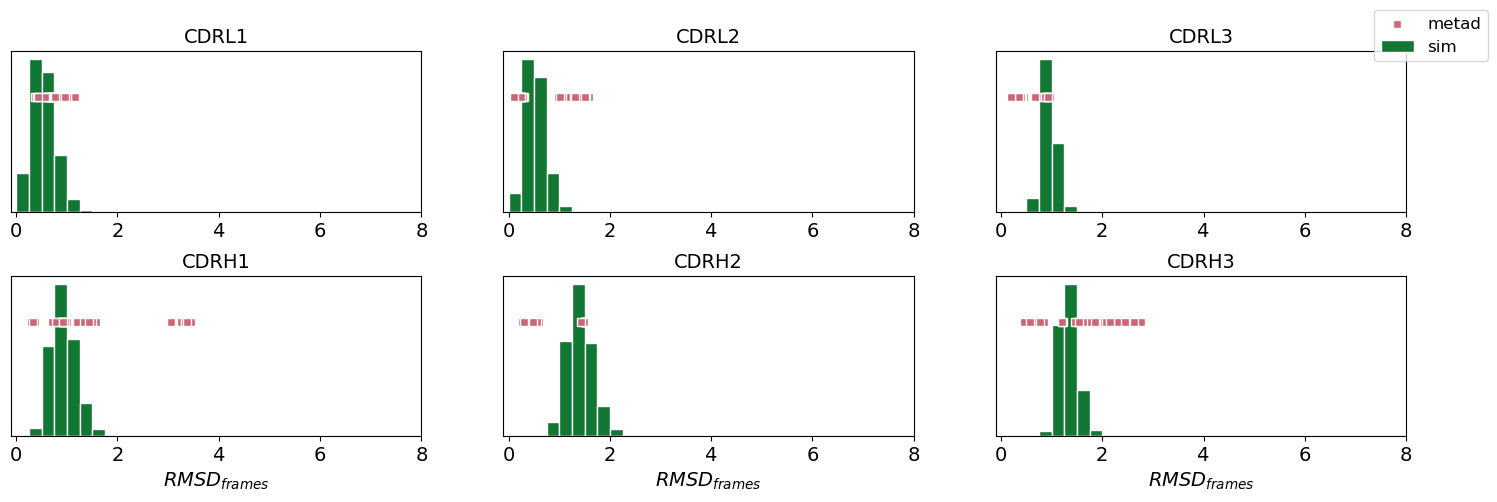

In [361]:
fig, axes = plt.subplots(2, 3, figsize=(18, 5), gridspec_kw={'hspace': 0.4, 'wspace': 0.2})
colors = ['#117733','#CC6677','#AB6D52','gray']  # One color per method
methods = list(rmsd_all_dist.keys())

# Ensure axes is 2D
axes = np.atleast_2d(axes)

for row_idx, chain in enumerate(['light','heavy']):
    for col_idx, cdr in enumerate([1, 2, 3]):
        ax = axes[row_idx, col_idx]

        for method_idx, method in enumerate(methods):
            try:
                data = rmsd_all_dist[method][chain][cdr-1]
                if method == 'pdbs':
                    y = [1.5*(len(methods)-1)] * len(data)
                    ax.scatter(data, y, facecolor=colors[method_idx], edgecolor='white',marker='s', 
                               label=method if row_idx == 0 else "")
                elif method == 'metad':
                    y = [1.5*(len(methods)-1.5)] * len(data)
                    ax.scatter(data, y, facecolor=colors[method_idx], edgecolor='white',marker='s', 
                               label=method if row_idx == 0 else "")
                else:

                    counts, bin_edges = np.histogram(data, bins=40, range=[0, 10.0])
                    pdf = counts / counts.max()
                    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
                    
                    # Plot
                    ax.bar(bin_centers, pdf, width=bin_edges[1] - bin_edges[0], 
                           color=colors[method_idx], edgecolor='w', 
                           label=method if row_idx == 0 else "", 
                           bottom=method_idx * 1.5)
                    ax.plot([0, 10], [method_idx * 1.5, method_idx * 1.5],  color='lightgray', alpha=0.2)
                    
            except KeyError:
                continue

        ax.set_xlim(-0.1, 8)
        ax.set_xticks([0,2,4,6,8])
        ax.set_xticklabels([0,2,4,6,8],fontsize=14)
        ax.set_yticks([])
        if row_idx == 1:
            ax.set_xlabel(r'$ RMSD_{frames}$',fontsize=14)
        
        ax.set_title(f"CDR{chain[0].upper()}{cdr}",fontsize=14)
# Add a legend only once
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.95, 0.98),fontsize=12)

plt.tight_layout()
plt.savefig(f'../figures/{system_name}_sim_metad_rmsd_matrix.pdf')

## 3EOA - bound

#### load starting pdb and pdbs

In [362]:
folder_dict='../src/extra_pdbs/imgt2cv_dict/'

folder_pdbs=os.path.abspath('../src/extra_pdbs/pdbs_imgt/')
pdbs_all=os.listdir(folder_pdbs)

pdb_list=['3eoa_Fv_HL.pdb', '3eoa_Fv_BA.pdb', '3eo9_Fv_HL.pdb']
chain_list=['HL','BA','HL']

In [363]:
pdb_list

['3eoa_Fv_HL.pdb', '3eoa_Fv_BA.pdb', '3eo9_Fv_HL.pdb']

In [364]:
chain_list

['HL', 'BA', 'HL']

In [365]:
n_pdbs=len(pdb_list)

In [366]:
os.listdir('../src/metaD_clusters/3EOA_clusters/')

['cluster.CL-rep.c4.pdb',
 'cluster.CL-rep.c0.pdb',
 'cluster.CL-rep.c1.pdb',
 'cluster.CL-rep.c3.pdb',
 'cluster.CL-rep.c2.pdb']

In [367]:
n_cluster=len(os.listdir('../src/metaD_clusters/3EOA_clusters/'))

In [368]:
dict_prob_cluster={'cluster.CL-rep.c0.pdb':0.41,'cluster.CL-rep.c1.pdb':0.24,'cluster.CL-rep.c2.pdb':0.17,'cluster.CL-rep.c3.pdb':0.11,'cluster.CL-rep.c4.pdb':0.07}

In [369]:
cluster_pdb_list=os.listdir('../src/metaD_clusters/3EOA_clusters/')
cluster_chain_list=['HL','HL','HL','HL','HL']
cluster_folder_pdbs='../src/metaD_clusters/3EOA_clusters/'
cluster_pdb_prob=np.array([dict_prob_cluster[cluster] for cluster in cluster_pdb_list])

In [370]:
sys_name='3eoa'
pdb_trajectories = [md.load(os.path.join('../src/metaD_clusters/3EOA_clusters/',pdb_name)) for pdb_name in os.listdir('../src/metaD_clusters/3EOA_clusters/')]

# Step 2: Concatenate all into a single trajectory
pdb_traj = md.join(pdb_trajectories)
pdb_traj.save_xtc(f"../src/metaD_clusters/imgt_traj_clusters/{sys_name}joined_pdbs.xtc")

pdb_traj = mda.Universe('../src/metaD_clusters/3EOA_clusters/cluster.CL-rep.c0.pdb',f"../src/metaD_clusters/imgt_traj_clusters/{sys_name}joined_pdbs.xtc")


/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/XDR.py:240: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


In [371]:
rmsd_all_dist={}
rmsd_all_dist['sim']={'heavy':{},'light':{}}
rmsd_all_dist['metad']={'heavy':{},'light':{}}

In [372]:
chain_cluster=['H','L']
for chain_idx,chain_type in enumerate(['heavy','light']):
    for idx_cdr, cdr in enumerate(cdrs_list):
        rmsd_all_dist['metad'][chain_type][idx_cdr]=dist_trajs(pdb_traj,select=f'segid {chain_cluster[chain_idx]} and name CA and resid {cdr[0]-1}:{cdr[1]+1}')
        if len(rmsd_all_dist['metad'][chain_type][idx_cdr]) ==0:
            rmsd_all_dist['metad'][chain_type][idx_cdr]=np.array([0])

### load simulations

In [373]:
top_file = '../src/sims_cv3fv/3eoa_HL/3eoa_Fv_HL.pdb'  # Path to your PDB file
chain_sequences = extract_sequences_by_chain(top_file)

# Print sequences for each chain
for chain_id, sequence in chain_sequences.items():
    print(f"Chain {chain_id} {len(sequence)}: {sequence}")
    if chain_id == 'H':
        res_heavy=sequence
    if chain_id == 'L':
        res_light=sequence

Chain H 123: EVQLVESGGGLVQPGGSLRLSCAASGYSFTGHWMNWVRQAPGKGLEWVGMIHPSDSETRYNQKFKDRFTISVDKSKNTLYLQMNSLRAEDTAVYYCARGIYFYGTTYFDYWGQGTLVTVSSAS
Chain L 110: DIQMTQSPSSLSASVGDRVTITCRASKTISKYLAWYQQKPGKAPKLLIYSGSTLQSGVPSRFSGSGSGTDFTLTISSLQPEDFATYYCQQHNEYPLTFGQGTKVEIKRTV


In [374]:
sel_chain='HL'
topology_fa = "../src/sims_cv3fv/3eoa_HL/3eoa_Fv_HL_top.pdb"

top_pdb=mda.Universe(topology_fa,topology_fa)

dict_imgt2cv='../src/sims_cv3fv/3eoa_HL/3eoa_dict_Fv_HL.txt'

In [375]:
prefix_sim=os.path.abspath('../src/sims_cv3fv/3eoa_HL/3eoa_Fv_HL')
topology_fa= os.path.join(prefix_sim+"_top.pdb")
xtc_file = os.path.join(prefix_sim+"_aligned.xtc")

# topology_fa= os.path.join(prefix_sim+".pdb")
# xtc_file = os.path.join(prefix_sim+".xtc")

mobile = mda.Universe(topology_fa,xtc_file)
ref = mda.Universe(topology_fa,xtc_file)

mobile.trajectory  # set mobile trajectory to last frame
ref.trajectory[0]  # set reference trajectory to first frame

##dict_loc,chain,cdr_boundaries
cv3_cdrs_light_sim=[extract_cdr_coord(dict_imgt2cv,sel_chain[1],cdrs_list[0]),extract_cdr_coord(dict_imgt2cv,sel_chain[1],cdrs_list[1]),extract_cdr_coord(dict_imgt2cv,sel_chain[1],cdrs_list[2])]
cv3_cdrs_heavy_sim=[extract_cdr_coord(dict_imgt2cv,sel_chain[0],cdrs_list[0]),extract_cdr_coord(dict_imgt2cv,sel_chain[0],cdrs_list[1]),extract_cdr_coord(dict_imgt2cv,sel_chain[0],cdrs_list[2])]

In [376]:
Rref_cdr1_light,Rmean_cdr1_light=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_light_sim[0][0]}:{cv3_cdrs_light_sim[0][1]}')
Rref_cdr2_light,Rmean_cdr2_light=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_light_sim[1][0]}:{cv3_cdrs_light_sim[1][1]}')
Rref_cdr3_light,Rmean_cdr3_light=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_light_sim[2][0]}:{cv3_cdrs_light_sim[2][1]}')

Rref_cdr1_heavy,Rmean_cdr1_heavy=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_heavy_sim[0][0]}:{cv3_cdrs_heavy_sim[0][1]}')
Rref_cdr2_heavy,Rmean_cdr2_heavy=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_heavy_sim[1][0]}:{cv3_cdrs_heavy_sim[1][1]}')
Rref_cdr3_heavy,Rmean_cdr3_heavy=calc_rmsd(mobile,top_pdb,select=f'backbone and resid {cv3_cdrs_heavy_sim[2][0]}:{cv3_cdrs_heavy_sim[2][1]}')


/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/memory.py:535: DeprecationWarning: asel argument to timeseries will be renamed to'atomgroup' in 3.0, see #3911
  warnings.warn(


done
done
done
done
done
done


In [377]:
trajectory = md.load(xtc_file
, top=topology_fa)  # Adjust file names/paths as needed

# Light chain
atom_indices = trajectory.topology.select('name CA and chainid 0')
# Restrict the trajectory to the selected atoms
sub_traj = trajectory.atom_slice(atom_indices)
sub_traj.center_coordinates()
rmsf_sim = md.rmsf(sub_traj, sub_traj, 0, precentered=True) *10
rmsd_sim = md.rmsd(sub_traj, sub_traj, 0, precentered=True) *10

rmsf_sim_heavy=rmsf_sim[:len(res_heavy)]
rmsf_sim_light=rmsf_sim[-(len(res_light)):]

In [378]:
# Light chain
atom_indices = trajectory.topology.select(f'name CA and resid >= {cv3_cdrs_light_sim[2][0]} and resid <= {cv3_cdrs_light_sim[2][1]}')
# Restrict the trajectory to the selected atoms
sub_traj_CDRL3_sim = trajectory.atom_slice(atom_indices)
sub_traj_CDRL3_sim.center_coordinates()

# Light chain
atom_indices = trajectory.topology.select(f'name CA and resid >= {cv3_cdrs_heavy_sim[2][0]} and resid <= {cv3_cdrs_heavy_sim[2][1]}')
# Restrict the trajectory to the selected atoms
sub_traj_CDRH3_sim = trajectory.atom_slice(atom_indices)
sub_traj_CDRH3_sim.center_coordinates()

<mdtraj.Trajectory with 1010 frames, 14 atoms, 14 residues, and unitcells at 0x120262f80>

In [379]:
rmsf_cdr1_light_sim=rmsf_sim[(cv3_cdrs_light_sim[0][0]-1):(cv3_cdrs_light_sim[0][1])]
rmsf_cdr2_light_sim=rmsf_sim[(cv3_cdrs_light_sim[1][0]-1):(cv3_cdrs_light_sim[1][1])]
rmsf_cdr3_light_sim=rmsf_sim[(cv3_cdrs_light_sim[2][0]-1):(cv3_cdrs_light_sim[2][1])]

rmsf_cdr1_heavy_sim=rmsf_sim[(cv3_cdrs_heavy_sim[0][0]-1):(cv3_cdrs_heavy_sim[0][1])]
rmsf_cdr2_heavy_sim=rmsf_sim[(cv3_cdrs_heavy_sim[1][0]-1):(cv3_cdrs_heavy_sim[1][1])]
rmsf_cdr3_heavy_sim=rmsf_sim[(cv3_cdrs_heavy_sim[2][0]-1):(cv3_cdrs_heavy_sim[2][1])]

#### rmsd pdbs

In [380]:
Rmean_cdr1_light_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[0][0]-1}:{cv3_cdrs_light_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', 'L')
Rmean_cdr2_light_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[1][0]-1}:{cv3_cdrs_light_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', 'L')
Rmean_cdr3_light_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[2][0]-1}:{cv3_cdrs_light_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', 'L')

Rmean_cdr1_heavy_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[0][0]-1}:{cv3_cdrs_heavy_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', 'H')
Rmean_cdr2_heavy_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[1][0]-1}:{cv3_cdrs_heavy_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', 'H')
Rmean_cdr3_heavy_pdb=calc_rmsd_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[2][0]-1}:{cv3_cdrs_heavy_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', 'H')

/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:777: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


In [381]:
Rref_cdr1_light_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_light_sim[0][0]-1}:{cv3_cdrs_light_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', "L")
Rref_cdr2_light_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_light_sim[1][0]-1}:{cv3_cdrs_light_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', "L")
Rref_cdr3_light_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_light_sim[2][0]-1}:{cv3_cdrs_light_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', "L")

Rref_cdr1_heavy_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_heavy_sim[0][0]-1}:{cv3_cdrs_heavy_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', "H")
Rref_cdr2_heavy_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_heavy_sim[1][0]-1}:{cv3_cdrs_heavy_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', "H")
Rref_cdr3_heavy_pdb=calc_rmsd_pdb(pdb_traj,top_pdb,f'name CA and resid {cv3_cdrs_heavy_sim[2][0]-1}:{cv3_cdrs_heavy_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', "H")

/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/base.py:725: UserWarning: Reader has no dt information, set to 1.0 ps
  return self.ts.dt


In [382]:
Rmetad_cdr1_light_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[0][0]-1}:{cv3_cdrs_light_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', 'L')
Rmetad_cdr2_light_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[1][0]-1}:{cv3_cdrs_light_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', 'L')
Rmetad_cdr3_light_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_light_sim[2][0]-1}:{cv3_cdrs_light_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', 'L')

Rmetad_cdr1_heavy_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[0][0]-1}:{cv3_cdrs_heavy_sim[0][1]+1}',f'name CA and resid {cdrs_list[0][0]-1}:{cdrs_list[0][1]+1}', 'H')
Rmetad_cdr2_heavy_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[1][0]-1}:{cv3_cdrs_heavy_sim[1][1]+1}',f'name CA and resid {cdrs_list[1][0]-1}:{cdrs_list[1][1]+1}', 'H')
Rmetad_cdr3_heavy_pdb=calc_rmsd_from_pdb(pdb_traj,mobile,f'name CA and resid {cv3_cdrs_heavy_sim[2][0]-1}:{cv3_cdrs_heavy_sim[2][1]+1}',f'name CA and resid {cdrs_list[2][0]-1}:{cdrs_list[2][1]+1}', 'H')

1015
1015
1015
1015
1015
1015


In [383]:
chain_sim=['P000','P001']
cdr_sim=[cv3_cdrs_heavy_sim,cv3_cdrs_light_sim]
for chain_idx,chain_type in enumerate(['heavy','light']):
    for idx_cdr, cdr in enumerate(cdrs_list):
        rmsd_all_dist['sim'][chain_type][idx_cdr]=dist_trajs(mobile,select=f'segid {chain_sim[chain_idx]} and name CA and resid {cdr_sim[chain_idx][chain_idx][0]-1}:{cdr_sim[chain_idx][idx_cdr][1]+1}').flatten()

### plots

In [384]:
size_clusters=np.array([250*np.sqrt(dict_prob_cluster[cluster_file]) for cluster_file in reversed(os.listdir('../src/metaD_clusters/3EOA_clusters/'))])

In [385]:
len(size_clusters)

5

/var/folders/8w/2dqxrgsd4vj00wv819dcz51w0000gn/T/ipykernel_44258/1881988891.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


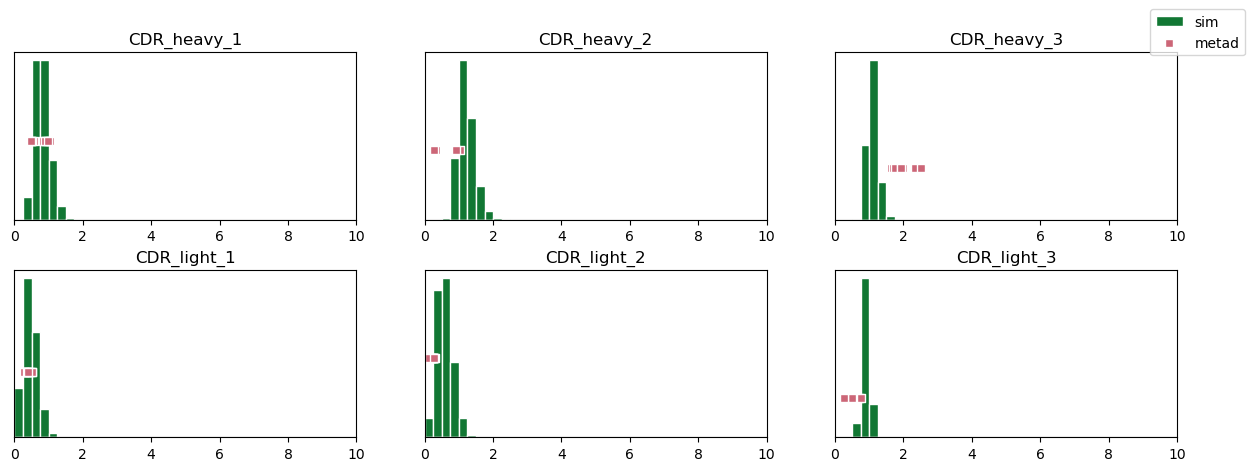

In [386]:
fig, axes = plt.subplots(2, 3, figsize=(15, 5), gridspec_kw={'hspace': 0.3, 'wspace': 0.2})
colors = ['#117733','#CC6677','#AB6D52','gray']  # One color per method
methods = list(rmsd_all_dist.keys())

# Ensure axes is 2D
axes = np.atleast_2d(axes)

for row_idx, chain in enumerate(['heavy','light']):
    for col_idx, cdr in enumerate([1, 2, 3]):
        ax = axes[row_idx, col_idx]

        for method_idx, method in enumerate(methods):
            try:
                data = rmsd_all_dist[method][chain][cdr-1]
                if method == 'pdbs':
                    y = [1.5*(len(methods)-1)] * len(data)
                    ax.scatter(data, y, facecolor=colors[method_idx], edgecolor='white',marker='s', 
                               label=method if row_idx == 0 else "")
                elif method == 'metad':
                    y = [1.5*(len(methods)-1.5)] * len(data)
                    ax.scatter(data, y, facecolor=colors[method_idx], edgecolor='white',marker='s', 
                               label=method if row_idx == 0 else "")
                else:
                    ax.hist(data, bins=40, range=[0, 10.0], facecolor=colors[method_idx], 
                            edgecolor='w', label=method if row_idx == 0 else "",bottom=method_idx*1.5,density=True)
                    ax.plot([0,10],[method_idx*1.5,method_idx*1.5],color='lightgray',alpha=0.2)
            except KeyError:
                continue

        ax.set_xlim(0, 10)
        ax.set_yticks([])
        if row_idx == len(pdb_list) - 1:
            ax.set_xlabel(r'$ RMSD$')
        
        ax.set_title(f"CDR_{chain}_{cdr}")
# Add a legend only once
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.95, 0.98))

plt.tight_layout()
#plt.savefig('../figures/1JPS_comparison_rmsd_matrix.pdf')

In [387]:
start_chain_light=len(res_heavy)

In [388]:
np.array(list(dict_prob_cluster.values()))*20

array([8.2, 4.8, 3.4, 2.2, 1.4])

In [389]:
cluster_dot_size=[]
for cluster in os.listdir('../src/metaD_clusters/3EOA_clusters/'):
    cluster_dot_size.append(dict_prob_cluster[cluster])
cluster_dot_size=np.array(cluster_dot_size)

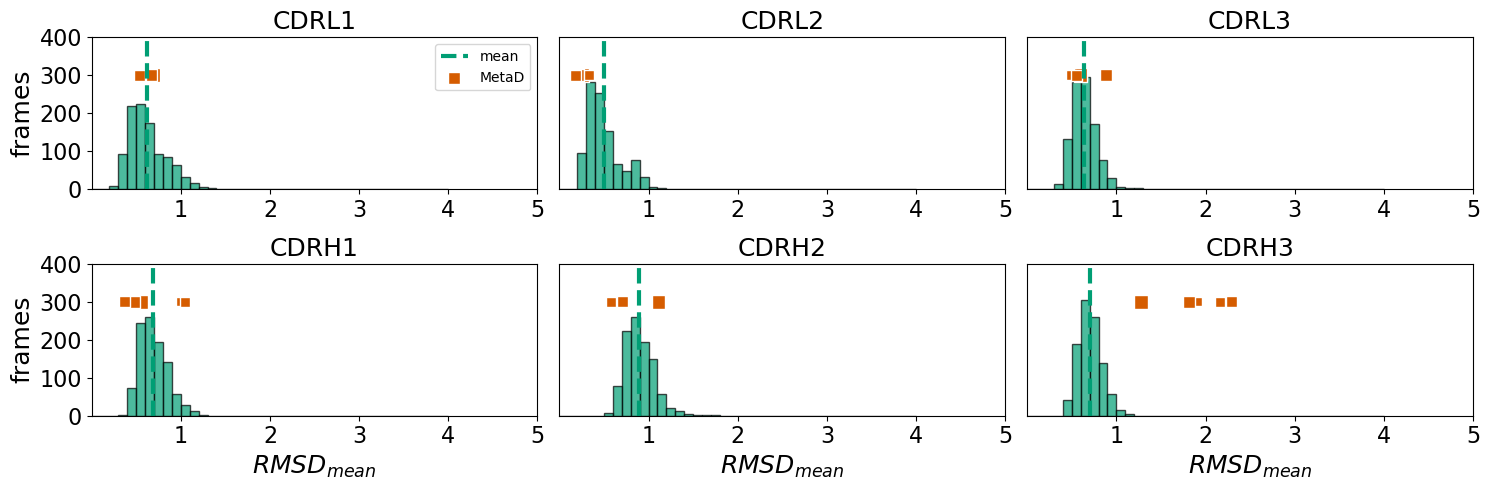

In [390]:
system_name='3EOA'
fig,(axs)=plt.subplots(2,3,figsize=(15,5))

axs=axs.flatten()

counts=axs[0].hist(Rmean_cdr1_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[0].plot([np.mean(Rmean_cdr1_light[2,:]),np.mean(Rmean_cdr1_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='mean')
axs[0].scatter([Rmean_cdr1_light_pdb],[[300 for i in Rmean_cdr1_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00',label='MetaD')
axs[0].legend()

axs[0].set_title('CDRL1',fontsize=18)

counts=axs[1].hist(Rmean_cdr2_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[1].plot([np.mean(Rmean_cdr2_light[2,:]),np.mean(Rmean_cdr2_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[1].scatter([Rmean_cdr2_light_pdb],[[300 for i in Rmean_cdr2_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[1].set_title('CDRL2',fontsize=18)


counts=axs[2].hist(Rmean_cdr3_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[2].plot([np.mean(Rmean_cdr3_light[2,:]),np.mean(Rmean_cdr3_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[2].scatter([Rmean_cdr3_light_pdb],[[300 for i in Rmean_cdr3_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[2].set_title('CDRL3',fontsize=18)


counts=axs[3].hist(Rmean_cdr1_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[3].plot([np.mean(Rmean_cdr1_heavy[2,:]),np.mean(Rmean_cdr1_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[3].scatter([Rmean_cdr1_heavy_pdb],[[300 for i in Rmean_cdr1_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[3].set_title('CDRH1',fontsize=18)


counts=axs[4].hist(Rmean_cdr2_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[4].plot([np.mean(Rmean_cdr2_heavy[2,:]),np.mean(Rmean_cdr2_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[4].scatter([Rmean_cdr2_heavy_pdb],[[300 for i in Rmean_cdr2_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[4].set_title('CDRH2',fontsize=18)


counts=axs[5].hist(Rmean_cdr3_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[5].plot([np.mean(Rmean_cdr3_heavy[2,:]),np.mean(Rmean_cdr3_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[5].scatter([Rmean_cdr3_heavy_pdb],[[300 for i in Rmean_cdr3_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[5].set_title('CDRH3',fontsize=18)

for ax in axs:

    ax.set_xlim(0,5)
    ax.set_ylim(0,400)
    ax.set_yticks([0,100,200,300,400])
    ax.set_yticklabels([0,100,200,300,400],fontsize=16)
    ax.set_xticks([1,2,3,4,5])
    ax.set_xticklabels([1,2,3,4,5],fontsize=16)
axs[3].set_xlabel(r'$RMSD_{mean}$',fontsize=18)
axs[4].set_xlabel(r'$RMSD_{mean}$',fontsize=18)
axs[5].set_xlabel(r'$RMSD_{mean}$',fontsize=18)

axs[0].set_ylabel('frames',fontsize=18)
axs[3].set_ylabel('frames',fontsize=18)
axs[0].legend()

for ax in [axs[1],axs[2],axs[4],axs[5]]:
    ax.set_yticks([])


fig.tight_layout()
plt.savefig(f'../figures/{system_name}_restraints_rmsd_all_cdrs.pdf')

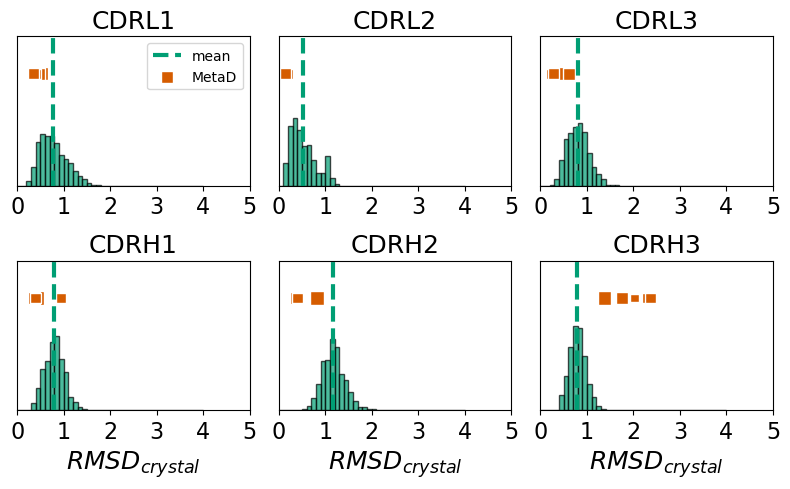

In [391]:
system_name='3EOA'

fig,(axs)=plt.subplots(2,3,figsize=(8,5))

axs=axs.flatten()

counts=axs[0].hist(Rref_cdr1_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[0].plot([np.mean(Rref_cdr1_light[2,:]),np.mean(Rref_cdr1_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='mean')
axs[0].scatter([Rref_cdr1_light_pdb],[[300 for i in Rref_cdr1_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00',label='MetaD')
axs[0].legend(fontsize=18)

axs[0].set_title('CDRL1',fontsize=18)

counts=axs[1].hist(Rref_cdr2_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[1].plot([np.mean(Rref_cdr2_light[2,:]),np.mean(Rref_cdr2_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[1].scatter([Rref_cdr2_light_pdb],[[300 for i in Rref_cdr2_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[1].set_title('CDRL2',fontsize=18)


counts=axs[2].hist(Rref_cdr3_light[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[2].plot([np.mean(Rref_cdr3_light[2,:]),np.mean(Rref_cdr3_light[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[2].scatter([Rref_cdr3_light_pdb],[[300 for i in Rref_cdr3_light_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[2].set_title('CDRL3',fontsize=18)


counts=axs[3].hist(Rref_cdr1_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[3].plot([np.mean(Rref_cdr1_heavy[2,:]),np.mean(Rref_cdr1_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[3].scatter([Rref_cdr1_heavy_pdb],[[300 for i in Rref_cdr1_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[3].set_title('CDRH1',fontsize=18)


counts=axs[4].hist(Rref_cdr2_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[4].plot([np.mean(Rref_cdr2_heavy[2,:]),np.mean(Rref_cdr2_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[4].scatter([Rref_cdr2_heavy_pdb],[[300 for i in Rref_cdr2_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[4].set_title('CDRH2',fontsize=18)


counts=axs[5].hist(Rref_cdr3_heavy[2,:],bins=40,range=[0,4.0],edgecolor='k',facecolor='#009e74',alpha=0.7)
axs[5].plot([np.mean(Rref_cdr3_heavy[2,:]),np.mean(Rref_cdr3_heavy[2,:])],[0,400],lw=3,color='#009e74',ls='--',label='ss')
axs[5].scatter([Rref_cdr3_heavy_pdb],[[300 for i in Rref_cdr3_heavy_pdb]],s=np.sqrt(cluster_dot_size)*150, edgecolor='white',marker='s',color='#d55c00')

axs[5].set_title('CDRH3',fontsize=18)

for ax in axs:

    ax.set_xlim(0,5)
    ax.set_ylim(0,400)
    ax.set_xticks([0,1,2,3,4,5])
    ax.set_xticklabels([0,1,2,3,4,5],fontsize=16)
axs[3].set_xlabel(r'$RMSD_{crystal}$',fontsize=18)
axs[4].set_xlabel(r'$RMSD_{crystal}$',fontsize=18)
axs[5].set_xlabel(r'$RMSD_{crystal}$',fontsize=18)

axs[0].legend()

for ax in axs:
    ax.set_yticks([])
fig.tight_layout()
plt.savefig(f'../figures/{system_name}_restraints_rmsd_ref_cdrs.pdf')

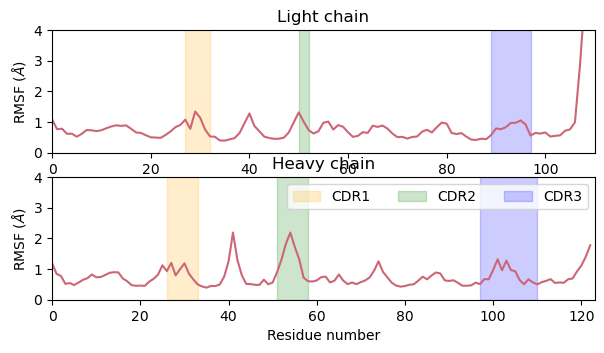

In [392]:
fig,(axs)=plt.subplots(2,1,figsize=(7,3.5))

axs[0].plot([i for i in range(len(res_light))],rmsf_sim_light,color='#CC6677')

axs[0].set_xlabel('Residue number')
axs[0].set_ylabel('RMSF ($\AA$)')
axs[0].axvspan(cv3_cdrs_light_sim[0][0]-start_chain_light,cv3_cdrs_light_sim[0][1]-start_chain_light, zorder=0, alpha=0.2, color='orange', label='CDR1')
axs[0].axvspan(cv3_cdrs_light_sim[1][0]-start_chain_light,cv3_cdrs_light_sim[1][1]-start_chain_light, zorder=0, alpha=0.2, color='green', label='CDR2')
axs[0].axvspan(cv3_cdrs_light_sim[2][0]-start_chain_light,cv3_cdrs_light_sim[2][1]-start_chain_light, zorder=0, alpha=0.2, color='blue', label='CDR3')
axs[0].set_ylim(0,4)
axs[0].set_xlim(0,len(res_light))

axs[1].plot([i for i in range(len(res_heavy))],rmsf_sim_heavy, color='#CC6677')

axs[1].set_xlabel('Residue number')
axs[1].set_ylabel('RMSF ($\AA$)')
axs[1].axvspan(cv3_cdrs_heavy_sim[0][0],cv3_cdrs_heavy_sim[0][1], zorder=0, alpha=0.2, color='orange', label='CDR1')
axs[1].axvspan(cv3_cdrs_heavy_sim[1][0],cv3_cdrs_heavy_sim[1][1], zorder=0, alpha=0.2, color='green', label='CDR2')
axs[1].axvspan(cv3_cdrs_heavy_sim[2][0],cv3_cdrs_heavy_sim[2][1], zorder=0, alpha=0.2, color='blue', label='CDR3')
axs[1].set_ylim(0,4)
axs[1].legend(ncol=3)
axs[1].set_xlim(0,len(res_heavy))

axs[1].set_title('Heavy chain')
axs[0].set_title('Light chain')

plt.savefig(f'../figures/{system_name}_restraints_rmsf_all.pdf')


/var/folders/8w/2dqxrgsd4vj00wv819dcz51w0000gn/T/ipykernel_44258/2441655020.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


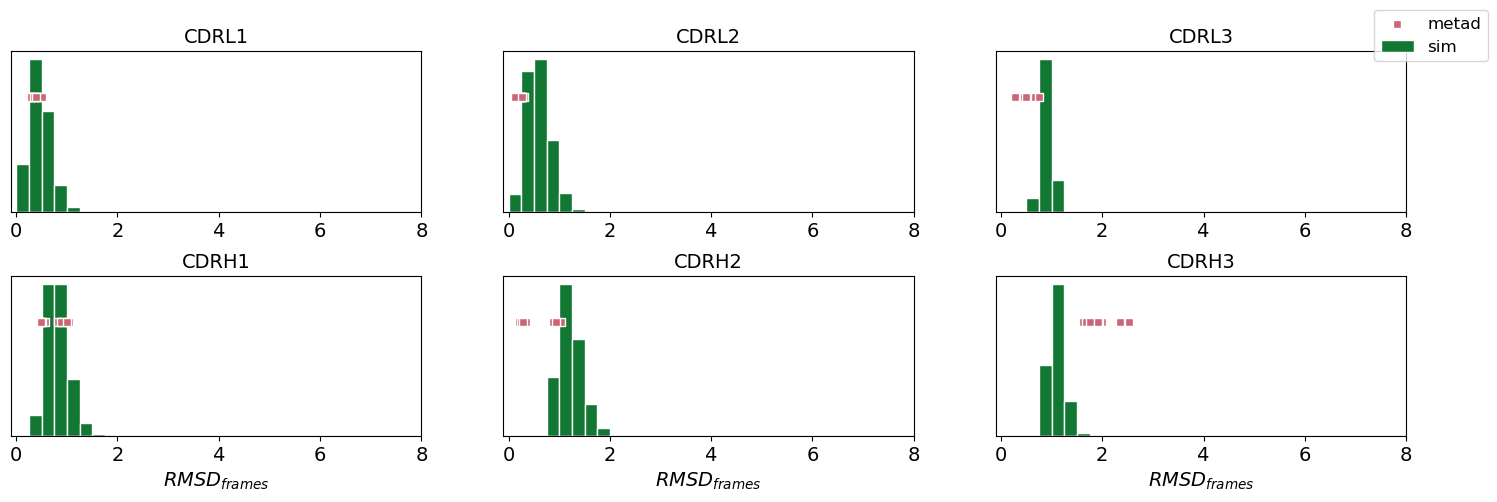

In [393]:
fig, axes = plt.subplots(2, 3, figsize=(18, 5), gridspec_kw={'hspace': 0.4, 'wspace': 0.2})
colors = ['#117733','#CC6677','#AB6D52','gray']  # One color per method
methods = list(rmsd_all_dist.keys())

# Ensure axes is 2D
axes = np.atleast_2d(axes)

for row_idx, chain in enumerate(['light','heavy']):
    for col_idx, cdr in enumerate([1, 2, 3]):
        ax = axes[row_idx, col_idx]

        for method_idx, method in enumerate(methods):
            try:
                data = rmsd_all_dist[method][chain][cdr-1]
                if method == 'pdbs':
                    y = [1.5*(len(methods)-1)] * len(data)
                    ax.scatter(data, y, facecolor=colors[method_idx], edgecolor='white',marker='s', 
                               label=method if row_idx == 0 else "")
                elif method == 'metad':
                    y = [1.5*(len(methods)-1.5)] * len(data)
                    ax.scatter(data, y, facecolor=colors[method_idx], edgecolor='white',marker='s', 
                               label=method if row_idx == 0 else "")
                else:

                    counts, bin_edges = np.histogram(data, bins=40, range=[0, 10.0])
                    pdf = counts / counts.max()
                    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
                    
                    # Plot
                    ax.bar(bin_centers, pdf, width=bin_edges[1] - bin_edges[0], 
                           color=colors[method_idx], edgecolor='w', 
                           label=method if row_idx == 0 else "", 
                           bottom=method_idx * 1.5)
                    ax.plot([0, 10], [method_idx * 1.5, method_idx * 1.5],  color='lightgray', alpha=0.2)
                    
            except KeyError:
                continue

        ax.set_xlim(-0.1, 8)
        ax.set_xticks([0,2,4,6,8])
        ax.set_xticklabels([0,2,4,6,8],fontsize=14)
        ax.set_yticks([])
        if row_idx == 1:
            ax.set_xlabel(r'$ RMSD_{frames}$',fontsize=14)
        
        ax.set_title(f"CDR{chain[0].upper()}{cdr}",fontsize=14)
# Add a legend only once
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.95, 0.98),fontsize=12)

plt.tight_layout()
plt.savefig(f'../figures/{system_name}_sim_metad_rmsd_matrix.pdf')